Author: Jessica Miles

# Introduction


## Business Problem

COVID-19 vaccines became available to subsets of the American public at the end of 2020. States and cities differed in terms of which groups of people were initially eligible, and the timeline for expanding eligibility, but [by April 19th](https://www.nytimes.com/2021/04/19/world/adults-eligible-covid-vaccine.html), all adults were eligible.

Appointment availability was initially scarce in some places, but this very quickly shifted to a growing number of appointments going unfilled across the country. [Only 61% of adults have received at least one dose](https://covid.cdc.gov/covid-data-tracker/#datatracker-home) (as of this writing, on May 22th, 2021), so there are still plenty of people who haven't received any doses, even though 82% of people in the latest survey say they definitely or probably intend to.

Vaccination rate is an important metric being considered as state and local governments decide how and when to relax mask-wearing, occupancy, and other COVID restrictions. These entities are already wondering about the best methods to encourage their populations to get vaccinated, and starting campaigns offering perks such as cash and food vouchers. It's worth asking whether these are likely to be the most effective strategies, or whether there are other approaches to consider.

To aid in this understanding, I will build a predictive model to classify whether someone is likely to be vaccine optimistic, or vaccine hesitant, based on their other answers to the Household Pulse Survey that the US Census has been conducting bi-weekly during the pandemic. Interpreting the factors which are most important in predicting vaccine hesitancy among populations may provide insights that will allow state and local governments to develop effective outreach strategies.




# OBTAIN

## Data Understanding

For this analysis, I will use a [publicly available microdata sample](https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html) from the bi-weekly Household Pulse Surveys that the US Census Bureau has been conducting during the pandemic. Each observation represents an individual's anonymized response to the survey.

Respondents were randomly sampled from all 50 states and the top 15 metropolitan areas, and asked to fill out the survey online. They were asked a variety of questions about their household, including whether they've received any doses of the vaccine, and if not, what their intent was to do so in the future. I will engineer these features into a binary target variable representing vaccine optimism versus vaccine hesitancy, and use each respondent's answers to other survey questions as the predictors.

Some survey questions were only presented to the respondent if they answered a certain way to a prior question, such as only asking about intention to get a vaccine in the future if the respondent indicated they had not yet received any doses. I will carefully review the data dictionary provided by the Census Bureau to understand these relationships, and  engineer features from the groups of questions as appropriate.

I will use the most recent microdata file available as of this writing, May 14, 2021, which includes a sample of about 78,000 responses from Phase 3 of the survey, covering the timeframe of March 3 to March 15, 2021. This is referred to as the "week 26" period.  Note that the survey is ongoing and currently in Phase 3.1, but microdata was not yet available for the "week 27" period or first period of Phase 3.1, so I have used the most recent data available at the time.

For more technical information on the sampling methodology and full questionnaire, [see here](https://www.census.gov/programs-surveys/household-pulse-survey/technical-documentation.html).

In [1310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

import seaborn as sns
import missingno
import plotly.express as px
import dstools
from textwrap import wrap

pd.set_option('display.max_info_rows', 300)
pd.set_option('display.max_info_columns', 300)

%autoreload 2

In [1311]:
# import data from downloaded CSV
df = pd.read_csv(r"data/pulse2021_puf_26.csv.tar.gz")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78307 entries, 0 to 78306
Data columns (total 204 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   ._pulse2021_puf_26.csv  object 
 1   WEEK                    float64
 2   EST_ST                  float64
 3   EST_MSA                 float64
 4   REGION                  float64
 5   HWEIGHT                 float64
 6   PWEIGHT                 float64
 7   TBIRTH_YEAR             float64
 8   ABIRTH_YEAR             float64
 9   EGENDER                 float64
 10  AGENDER                 float64
 11  RHISPANIC               float64
 12  AHISPANIC               float64
 13  RRACE                   float64
 14  ARACE                   float64
 15  EEDUC                   float64
 16  AEDUC                   float64
 17  MS                      float64
 18  THHLD_NUMPER            float64
 19  AHHLD_NUMPER            float64
 20  THHLD_NUMKID            float64
 21  AHHLD_NUMKID            float64
 2

In [1312]:
# drop placeholder column
df.drop(columns=['._pulse2021_puf_26.csv'], inplace=True)
df

,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,AGENDER,...,PSWHYCHG1,PSWHYCHG2,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,INCOME
0,26.0,1.0,NaN,2.0,1546.046792,2976.976997,1956.0,2.0,1.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
1,26.0,1.0,NaN,2.0,3481.483789,6703.740928,1995.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,6.0
2,26.0,1.0,NaN,2.0,581.457250,1119.619967,1961.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
3,26.0,1.0,NaN,2.0,2462.927760,7113.703795,1971.0,2.0,1.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,3.0
4,26.0,1.0,NaN,2.0,629.103937,605.682816,1941.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78302,26.0,56.0,NaN,4.0,182.025916,168.795754,1985.0,2.0,2.0,2.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,4.0
78303,26.0,6.0,NaN,4.0,671.196803,1281.472182,1997.0,2.0,2.0,2.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,-99.0,4.0
78304,26.0,26.0,19820.0,3.0,320.220440,597.103115,1992.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,6.0
78305,26.0,56.0,NaN,4.0,127.938345,237.278844,1981.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,1.0


I will primarily use the data dictionary provided by the Census Bureau to determine which fields to include in my initial model.

Although all the data fields are stored as floats, based on the dictionary some of them are actually ordinally encoded categorical variables, and most are nominal categorical variables. I will need to determine which are which, and whether any can be treated as continuous or numeric variables.

# SCRUB

I will need to engineer multiple features, including my target. As written and organized into a question per column, the data is not in ideal format for analysis due to the presence of main question and sub-question groups; some questions are conceptually spread across multiple columns.

Since predictors are mostly categorical, I'm concerned about the size of the feature space when they are eventually one-hot-encoded. As I scrub and explore this data, I'll engineer features that I think might be simpler alternatives to the originals but still capture the main information. I can experiment with the engineered features versus original ones in the modeling phase to let the models decide which, if any, perform better.

One notable challenge will be dealing with missing data. The data dictionary indicates that there are two placeholders that represent a non-answer: 
- -88: Missing / Did not report
- -99: Question seen but category not selected

The Census Bureau provides no additional information in the data dictionary about why a response might be missing and placed in the -88 category as opposed to the -99 category that represents a lack of a response from the respondent. Although some instances appear to be filled in to account for the fact that a sub-question wasn't presented to a respondent because of how they answered a prior question, there are some columns with -88 placeholders that do not appear to be sub-questions, so in my understanding should have been presented to everyone. 

Since there are a significant number of these -88 placeholders in some top-level question columns, I will likely encode them as a separate category instead of dropping them or attempting to impute them. But I will explore further before deciding how to proceed.

## Target columns

I want to create a binary target that represents a respondent's vaccine outlook: hesitant, or optimistic.

I will need to engineer this target from two questions: 
- `RECVDVACC` asked the respondent whether they have received any doses of the COVID vaccine
- `GETVACC` is a sub-question asked of the respondent if they said they had not received any doses. It asked about the respondent's intent to get a vaccine in the future. Choices include:

1. Definitely get a vaccine
2. Probably get a vaccine
3. Probably NOT get a vaccine 
4. Definitely NOT get a vaccine

At the time of the survey back in early March, only certain subsets of the population were eligible to make a vaccine appointment, based on state-specific criteria such as age, occupation, health risk indicators, and other factors. I want to make sure my class takes into account people who have been vaccinated but doesn't penalize people who have not yet been vaccinated yet, given there is no easy way to know if they were eligible for vaccination when they were surveyed. 

I will create the binary target by combining answers to these two questions in the following way:

**Vaccine optimistic**
- Has received at least one dose OR
- Has not received any doses yet AND:
    - Intends to Definitely get a vaccine OR
    - Intends to Probably get a vaccine

**Vaccine hesitant**
- Has not received any doses yet AND:
    - Intends to Probably NOT get a vaccine OR
    - Intends to Definitely NOT get a vaccine


In [1313]:
# First question asking whether they have received any doses
df['RECVDVACC'].value_counts()

 2.0     42085
 1.0     35840
-99.0      381
Name: RECVDVACC, dtype: int64

In [1314]:
df['RECVDVACC'].isna().sum()

1

In [1315]:
to_drop = df.loc[df['RECVDVACC'] == -99.0].index
df.drop(index=to_drop, inplace=True)

df['RECVDVACC'].value_counts()

2.0    42085
1.0    35840
Name: RECVDVACC, dtype: int64

- Value of 1 indicates Yes, at least one dose
- Value of 2 indicates No, no doses yet
- Value of -99 indicates the respondent did not answer the question

I will drop the -99 values, since there are few of them and I wouldn't be comfortable imputing target variables.

In [1316]:
df.tail(5)

,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,AGENDER,...,PSWHYCHG1,PSWHYCHG2,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,INCOME
78302,26.0,56.0,NaN,4.0,182.025916,168.795754,1985.0,2.0,2.0,2.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,4.0
78303,26.0,6.0,NaN,4.0,671.196803,1281.472182,1997.0,2.0,2.0,2.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,-99.0,4.0
78304,26.0,26.0,19820.0,3.0,320.220440,597.103115,1992.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,6.0
78305,26.0,56.0,NaN,4.0,127.938345,237.278844,1981.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,1.0
78306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like there was an extra blank line at the end of the file that is NaN for all values, so I'll remove that too.

In [1317]:
df.dropna(axis=0, how='all', inplace=True)

In [1318]:
df.tail(5)

,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,AGENDER,...,PSWHYCHG1,PSWHYCHG2,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,INCOME
78301,26.0,56.0,NaN,4.0,122.306386,340.250428,1964.0,2.0,1.0,2.0,...,-99.0,-99.0,-99.0,1.0,-99.0,-99.0,-99.0,-99.0,-99.0,6.0
78302,26.0,56.0,NaN,4.0,182.025916,168.795754,1985.0,2.0,2.0,2.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,4.0
78303,26.0,6.0,NaN,4.0,671.196803,1281.472182,1997.0,2.0,2.0,2.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,-99.0,4.0
78304,26.0,26.0,19820.0,3.0,320.220440,597.103115,1992.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,6.0
78305,26.0,56.0,NaN,4.0,127.938345,237.278844,1981.0,2.0,2.0,2.0,...,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,1.0


In [1319]:
# Review values for second vaccine-related question
df['GETVACC'].value_counts()

-88.0    35840
 1.0     24576
 2.0      7904
 3.0      5271
 4.0      4234
-99.0      100
Name: GETVACC, dtype: int64

In [1320]:
df['GETVACC'].isna().sum()

0

This question was only asked of respondents who said they had not received any doses yet.

- Value of 1 indicates will Definitely get a vaccine
- Value of 2 indicates will Probably get a vaccine
- Value of 3 indicates will Probably NOT get a vaccine 
- Value of 4 indicates will Definitely NOT get a vaccine
- Value of -99 indicates the respondent did not answer the question

A value of -88 is described as simply missing in the data dictionary. In this case, we know that this question was asked of a subset of people who sad they hadn't received any doses, and the count of value -88 in this question matches the count of 1 - Yes in the previous question.

I will confirm that these -88 placeholders represent people who received a dose of the vaccine.

In [1321]:
# Do 'GETVACC' values of -88 also have 'RECVDVACC' values of 1?
df.loc[df['GETVACC'] == -88.0]['RECVDVACC'].value_counts()

1.0    35840
Name: RECVDVACC, dtype: int64

Yes, all the -88 values from the second question are people who answered Yes (1.0) in the first question.

I will drop the -99 values to the second question since they are also very small in size. Then I will create a binary target based on the logic outlined in the header section above.

In [1322]:
# drop -99 values, where the respondent didn't answer the question
to_drop = df.loc[df['GETVACC'] == -99.0].index
df.drop(index=to_drop, inplace=True)

# Target class 0 will be vaccine optimistic
df.loc[(df['RECVDVACC'] == 1.0) | 
       (df['GETVACC'] == 1.0) | 
       (df['GETVACC'] == 2.0), 'target'] = 0

# Target class 1 will be vaccine hesitant
df.loc[(df['GETVACC'] == 3.0) | 
       (df['GETVACC'] == 4.0), 'target'] = 1

df['target'].value_counts()

0.0    68320
1.0     9505
Name: target, dtype: int64

In [1323]:
df['target'].value_counts(normalize=True)

0.0    0.877867
1.0    0.122133
Name: target, dtype: float64

In [1324]:
df['target'].isna().sum()

0

## Predictor Columns

I used the data dictionary provided by the Census Bureau as the primary method of determining which columns were categorical versus numeric, and which I wanted to use versus leave out of the initial exploration. A copy of the data dictionary is provided in the data folder.

Many of the questions asked in this survey involve potentially sensitive topics, such as race, financial circumstances, participation level in social assistance programs, household spending habits, aspects of mental health, etc. I will therefore do my utmost to apply consistent, objective criteria regarding which columns to include or remove in the model to avoid unintentional personal bias, and will detail my thoughts behind each of these tactical decisions.

### Initial Columns to Exclude

As a first pass, I identified the following characteristics of columns in the data set that led me to decide to exclude them in the initial exploration and probably from modeling.

#### Subquestions

Certain questions were asked of respondents only if they answered in a certain way to a prior question. One example would be the set of `WHYCHNGD` subquestions asking WHY household spending had changed, which were only presented to respondents who said their household spending HAD changed.

I think these subquestions will be very useful in understanding more nuance about the opinions and circumstances of households, if the primary question turns out to be an important predictor of vaccine hesitancy. However, I will include only the top-level questions in the modeling process.

Fields that represent subquestions (based on the data dictionary), and will be excluded from initial analysis are:

- WHYNOT1
- WHYNOT2
- WHYNOT3
- WHYNOT4
- WHYNOT5
- WHYNOT6
- WHYNOT7
- WHYNOT8
- WHYNOT9
- WHYNOT10
- WHYNOT11
- WHYNOTB1
- WHYNOTB2
- WHYNOTB3
- WHYNOTB4
- WHYNOTB5
- WHYNOTB6
- RSNNOWRK
- SSAPGM1
- SSAPGM2
- SSAPGM3
- SSAPGM4
- SSAPGM5
- SSALIKELY
- SSAEXPCT1
- SSAEXPCT2
- SSAEXPCT3
- SSAEXPCT4
- SSAEXPCT5
- SSADECISN
- EIPSPND1
- EIPSPND2
- EIPSPND3
- EIPSPND4
- EIPSPND5
- EIPSPND6
- EIPSPND7
- EIPSPND8
- EIPSPND9
- EIPSPND10
- EIPSPND11
- EIPSPND12
- EIPSPND13
- WHYCHNGD1
- WHYCHNGD2
- WHYCHNGD3
- WHYCHNGD4
- WHYCHNGD5
- WHYCHNGD6
- WHYCHNGD7
- WHYCHNGD8
- WHYCHNGD9
- WHYCHNGD10
- WHYCHNGD11
- WHYCHNGD12
- WHYCHNGD13
- CHILDFOOD
- FOODSUFRSN1
- FOODSUFRSN2
- FOODSUFRSN3
- FOODSUFRSN4
- FOODSUFRSN5
- WHEREFREE1
- WHEREFREE2
- WHEREFREE3
- WHEREFREE4
- WHEREFREE5
- WHEREFREE6
- WHEREFREE7
- RENTCUR
- MORTCUR
- MORTCONF
- EVICT
- FORCLOSE
- TEACH1
- TEACH2
- TEACH3
- TEACH4
- TEACH5
- COMPAVAIL
- COMP1
- COMP2
- COMP3
- INTRNTAVAIL
- INTRNT1
- INTRNT2
- INTRNT3
- KINDWORK
- SCHLHRS
- TSTDY_HRS
- TCH_HRS
- PSPLANS1
- PSPLANS2
- PSPLANS3
- PSPLANS4
- PSPLANS5
- PSPLANS6
- PSCHNG1
- PSCHNG2
- PSCHNG3
- PSCHNG4
- PSCHNG5
- PSCHNG6
- PSCHNG7
- PSWHYCHG1
- PSWHYCHG2
- PSWHYCHG3
- PSWHYCHG4
- PSWHYCHG5
- PSWHYCHG6
- PSWHYCHG7
- PSWHYCHG8
- PSWHYCHG9
- DOSES

#### Duplicates, Metadata, and Imputed values

Several columns were already imputed into  summary columns by the Census Bureau, which are duplicative of the originals:

- THHLD_NUMPER
- PRIVHLTH
- PUBHLTH

The REGION column will also not be included, as the dataset contains other columns that can be used to represent geographical characteristics, such as State and Metropolitan Area.

A few columns represent metadata such as household identifier, and weight calculations to be used to generate population statistics:

- SCRAM
- PWEIGHT
- HWEIGHT
- WEEK

The following columns are indicators that a value was imputed by the Census Bureau:

- ABIRTH_YEAR
- AGENDER
- AHISPANIC
- ARACE
- AEDUC
- AHHLD_NUMPER
- AHHLD_NUMKID

### Categories to Engineer

Some categorical columns are likely candidates to be engineered into a single column, such as reducing respondents' answers to different types of health insurance they have into a single column representing whether they have health insurance or not.

I can't be sure yet whether these features will perform better in their original state, or if my engineered features will be useful predictors. I'll create them where they make sense for now, and will be able to model either or both versions.

In [1325]:
# See values in HLTHINS columns
hlth_cols = ['HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 
             'HLTHINS6', 'HLTHINS7', 'HLTHINS8']

for col in hlth_cols:
    print(df[col].value_counts(1))

 1.0     0.534623
 2.0     0.262987
-88.0    0.169663
-99.0    0.032727
Name: HLTHINS1, dtype: float64
 2.0     0.537861
 1.0     0.194064
-88.0    0.169663
-99.0    0.098413
Name: HLTHINS2, dtype: float64
 2.0     0.494982
 1.0     0.257861
-88.0    0.169663
-99.0    0.077494
Name: HLTHINS3, dtype: float64
 2.0     0.626637
-88.0    0.169663
-99.0    0.118484
 1.0     0.085217
Name: HLTHINS4, dtype: float64
 2.0     0.667086
-88.0    0.169663
-99.0    0.124664
 1.0     0.038587
Name: HLTHINS5, dtype: float64
 2.0     0.661934
-88.0    0.169663
-99.0    0.129213
 1.0     0.039190
Name: HLTHINS6, dtype: float64
 2.0     0.685744
-88.0    0.169663
-99.0    0.137347
 1.0     0.007247
Name: HLTHINS7, dtype: float64
 2.0     0.628050
-88.0    0.169663
-99.0    0.163996
 1.0     0.038291
Name: HLTHINS8, dtype: float64


In [1326]:
# Combine HLTHINS multi-choice answers to represent has insurance or not

# Assign 1 if any health insurance option chosen
df.loc[(df['HLTHINS1']==1)|(df['HLTHINS2']==1)|(df['HLTHINS3']==1)|
       (df['HLTHINS4']==1)|(df['HLTHINS5']==1)|(df['HLTHINS6']==1)|
       (df['HLTHINS7']==1)|(df['HLTHINS8']==1), ['HLTHINS']] = 1

# Assign 0 if No explicitly selected for all
df.loc[(df['HLTHINS1']==2)&(df['HLTHINS2']==2)&(df['HLTHINS3']==2)&
       (df['HLTHINS4']==2)&(df['HLTHINS5']==2)&(df['HLTHINS6']==2)&
       (df['HLTHINS7']==2)&(df['HLTHINS8']==2), ['HLTHINS']] = 0

# Assign -99 if skipped all
df.loc[(df['HLTHINS1']==-99)&(df['HLTHINS2']==-99)&(df['HLTHINS3']==-99)&
       (df['HLTHINS4']==-99)&(df['HLTHINS5']==-99)&(df['HLTHINS6']==-99)&
       (df['HLTHINS7']==-99)&(df['HLTHINS8']==-99), ['HLTHINS']] = -99

# Assign -88 if we have no answer for all
df.loc[(df['HLTHINS1']==-88)&(df['HLTHINS2']==-88)&(df['HLTHINS3']==-88)&
       (df['HLTHINS4']==-88)&(df['HLTHINS5']==-88)&(df['HLTHINS6']==-88)&
       (df['HLTHINS7']==-88)&(df['HLTHINS8']==-88), ['HLTHINS']] = -88

print(df['HLTHINS'].isna().sum())
df['HLTHINS'].value_counts()

451


 1.0     61184
-88.0    13204
 0.0      2653
-99.0      333
Name: HLTHINS, dtype: int64

In [1327]:
# There are still 451 nulls, let's see how those answers look
df.loc[df['HLTHINS'].isna(), hlth_cols]

,HLTHINS1,HLTHINS2,HLTHINS3,HLTHINS4,HLTHINS5,HLTHINS6,HLTHINS7,HLTHINS8
235,2.0,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
299,2.0,2.0,2.0,2.0,2.0,2.0,-99.0,-99.0
490,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
558,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-99.0
604,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-99.0
...,...,...,...,...,...,...,...,...
77636,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
77848,2.0,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
77877,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
77976,-99.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [1328]:
# Assign the remaining records to 0, since it looks like respondents
# started marking them all No (2) but skipped some (-99)
df.loc[df['HLTHINS'].isna(), 'HLTHINS'] = 0

The questions about children enrolled in school are also a good candidate for an engineered feature. I'll create a single binary feature representing whether the household had any children enrolled in external school (i.e.not homeschooled, since homeschooling was likely less disrupted by the pandemic restrictions).

In [1329]:
# Create a single categorical column for children enrolled in school outside
# the home

# Assign 1 if have any children enrolled in school outside the home
df.loc[(df['ENROLL1']==1), ['SCHOOL_KIDS']] = 1

# Assign 0 if have ONLY children who are being homeschooled
df.loc[(df['ENROLL2']==1) & (df['SCHOOL_KIDS'].isna()), ['SCHOOL_KIDS']] = 0

# Assign 3 if indicated did NOT have children enrolled in school
df.loc[(df['ENROLL3']==1) & (df['SCHOOL_KIDS'].isna()), ['SCHOOL_KIDS']] = 0

print(len(df.loc[df['SCHOOL_KIDS'].isna(), ['SCHOOL_KIDS']]))
df['SCHOOL_KIDS'].value_counts()

57699


1.0    14266
0.0     5860
Name: SCHOOL_KIDS, dtype: int64

In [1330]:
# wow that's a lot of nulls. What were the answers?
df.loc[df['SCHOOL_KIDS'].isna(), ['ENROLL1', 'ENROLL2', 'ENROLL3']].value_counts()

ENROLL1  ENROLL2  ENROLL3
-88.0    -88.0    -88.0      57437
-99.0    -99.0    -99.0        262
dtype: int64

I'm definitely going to need to look more into the -88 values, since there are a huge number of them for these questions. 

Is it possible that these questions were only asked of respondents who said they did have kids?

In [1331]:
df.loc[(df['ENROLL1']==-88) & (df['ENROLL2']==-88) & (df['ENROLL3']==-88),
      'THHLD_NUMKID'].value_counts()

0.0    51941
1.0     2564
2.0     1882
3.0      682
4.0      226
5.0      142
Name: THHLD_NUMKID, dtype: int64

Most of the -88 values represent respondents who reported 0 people under 18 in the household so I'll mark those as 0 in my engineered feature for No.

The rest, I'll mark as -88 or -99 as the original answers were and deal with them later.

In [1332]:
# Assign 0 if said they had no children in the household
df.loc[(df['SCHOOL_KIDS'].isna()) & (df['THHLD_NUMKID']==0), 
       ['SCHOOL_KIDS']] = 0

# Assign -88 and -99 as appropriate
df.loc[(df['ENROLL1']==-88) & (df['ENROLL2']==-88) & (df['ENROLL3']==-88) &
       (df['SCHOOL_KIDS'].isna()), ['SCHOOL_KIDS']] = -88

df.loc[(df['ENROLL1']==-99) & (df['ENROLL2']==-99) & (df['ENROLL3']==-99) &
       (df['SCHOOL_KIDS'].isna()), ['SCHOOL_KIDS']] = -99

print(len(df.loc[df['SCHOOL_KIDS'].isna(), ['SCHOOL_KIDS']]))
df['SCHOOL_KIDS'].value_counts()

0


 0.0     57873
 1.0     14266
-88.0     5496
-99.0      190
Name: SCHOOL_KIDS, dtype: int64

In [1333]:
# Combine TSPNDPRPD and TSPNDFOOD into a single column representing the
# proportion of money spent on food that was on food to be eaten at home
# TSPNDPRPD is amount spent on prepared meals
# TSPNDFOOD is amount spent on food to be prepared at home

# if respondent entered one food amount but not the other, assume they left
# the other blank because it should be 0
df.loc[(df['TSPNDPRPD'] < 0) & (df['TSPNDFOOD'] >0), 'TSPNDPRPD'] = 0
df.loc[(df['TSPNDPRPD'] > 0) & (df['TSPNDFOOD'] <0), 'TSPNDFOOD'] = 0

# Only calculate if respondent included an answer for one
ans = df.loc[(df['TSPNDPRPD'] >0) | (df['TSPNDFOOD'] >0), ['TSPNDPRPD', 'TSPNDFOOD']]
ans.head()

,TSPNDPRPD,TSPNDFOOD
1,50.0,200.0
3,0.0,300.0
4,210.0,100.0
5,200.0,200.0
6,0.0,40.0


In [1334]:
# Populate proportion of food spend that was on food to be prepared
# at home
ans['PROP_FOODSPEND_HOME'] = ans.apply(lambda x: x[1]/np.sum(x), axis=1)
ans.head()

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME
1,50.0,200.0,0.800000
3,0.0,300.0,1.000000
4,210.0,100.0,0.322581
5,200.0,200.0,0.500000
6,0.0,40.0,1.000000


In [1335]:
# merge results back into main df
df = df.merge(right=ans['PROP_FOODSPEND_HOME'], how='left', 
         left_on=df.index, right_on=ans.index)

df[['TSPNDPRPD','TSPNDFOOD','PROP_FOODSPEND_HOME']].head(20)

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME
0,-88.0,-88.0,NaN
1,50.0,200.0,0.800000
2,-88.0,-88.0,NaN
3,0.0,300.0,1.000000
4,210.0,100.0,0.322581
5,200.0,200.0,0.500000
6,0.0,40.0,1.000000
7,0.0,800.0,1.000000
8,8.0,84.0,0.913043
9,25.0,120.0,0.827586


In [1336]:
# Insert appropriate -99 and -88 values, so can assess -88s in bulk
# with other columns later
df.loc[(df['TSPNDPRPD'] ==-88) & (df['TSPNDFOOD'] ==-88), 
       'PROP_FOODSPEND_HOME'] = -88
df.loc[(df['TSPNDPRPD'] ==-99) & (df['TSPNDFOOD'] ==-99), 
       'PROP_FOODSPEND_HOME'] = -99

In [1337]:
# review remaining null values
df.loc[df['PROP_FOODSPEND_HOME'].isna(), 
       ['TSPNDPRPD','TSPNDFOOD']].value_counts()

TSPNDPRPD  TSPNDFOOD
 0.0        0.0         627
           -99.0        251
-88.0      -99.0        249
-99.0       0.0          40
-88.0       0.0          30
dtype: int64

In [1338]:
# For the ones where people put 0 for both, going to fill in with 0
df.loc[(df['TSPNDPRPD'] ==0) & (df['TSPNDFOOD'] ==0) & 
       (df['PROP_FOODSPEND_HOME'].isna()), 'PROP_FOODSPEND_HOME'] = 0

# If either were -99, put -99 if proportion is still na
df.loc[((df['TSPNDPRPD']==-99) | (df['TSPNDFOOD']==-99)) & 
       (df['PROP_FOODSPEND_HOME'].isna()), 'PROP_FOODSPEND_HOME'] = -99

# the rest are -88
df.loc[df['PROP_FOODSPEND_HOME'].isna(), 'PROP_FOODSPEND_HOME'] = -88

# any nulls left?
len(df.loc[df['PROP_FOODSPEND_HOME'].isna(), ['PROP_FOODSPEND_HOME']])

0

In [1339]:
df['PROP_FOODSPEND_HOME'].describe()

count    77825.000000
mean       -15.689457
std         35.124998
min        -99.000000
25%          0.462366
50%          0.714286
75%          0.877193
max          1.000000
Name: PROP_FOODSPEND_HOME, dtype: float64

In [1340]:
# Create column to represent whether household was in a metropolitan statistical
# area or not

df.loc[df['EST_MSA'] > 0, 'IN_METRO_AREA'] = 1
df.loc[df['IN_METRO_AREA'].isna(), 'IN_METRO_AREA'] = 0

df.loc[df['EST_MSA'].isna(), 'EST_MSA'] = 0

print(df['IN_METRO_AREA'].isna().sum())
df['IN_METRO_AREA'].value_counts()

0


0.0    51865
1.0    25960
Name: IN_METRO_AREA, dtype: int64

In [1341]:
# convert -99 values to 0 in columns that represent checkboxes that are
# part of a larger multiple choice question. If the checkbox wasn't selected,
# it means No by default.

multichoice_cols = ['SPNDSRC1','SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5',
                    'SPNDSRC6','SPNDSRC7','SPNDSRC8','CHNGHOW1','CHNGHOW2',
                    'CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6','CHNGHOW7',
                    'CHNGHOW8','CHNGHOW9','CHNGHOW10','CHNGHOW11','CHNGHOW12']

for col in multichoice_cols:
    df.loc[df[col] == -99, col] = 0
    
df[multichoice_cols].head(5)

,SPNDSRC1,SPNDSRC2,SPNDSRC3,SPNDSRC4,SPNDSRC5,SPNDSRC6,SPNDSRC7,SPNDSRC8,CHNGHOW1,CHNGHOW2,CHNGHOW3,CHNGHOW4,CHNGHOW5,CHNGHOW6,CHNGHOW7,CHNGHOW8,CHNGHOW9,CHNGHOW10,CHNGHOW11,CHNGHOW12
0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [1342]:
# Convert birth year to age
df['AGE'] = df['TBIRTH_YEAR'].map(lambda x: 2021-x)

df['AGE'].describe()

count    77825.000000
mean        54.562159
std         15.898557
min         18.000000
25%         42.000000
50%         56.000000
75%         67.000000
max         88.000000
Name: AGE, dtype: float64

In [1343]:
df['AGE'].isna().sum()

0

In [1344]:
# Running list of the categorical and numeric column names, both engineered
# and original

cat_cols_orig = ['ANXIOUS','ANYWORK',
            'CHNGHOW1','CHNGHOW10','CHNGHOW11','CHNGHOW12','CHNGHOW2',
            'CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6','CHNGHOW7','CHNGHOW8',
            'CHNGHOW9','CURFOODSUF','DELAY','DOWN','EEDUC','EGENDER','EIP',
            'EXPCTLOSS','EXPNS_DIF','FEWRTRANS','FEWRTRIPS','FREEFOOD',
            'HADCOVID','INCOME','INTEREST','LIVQTR','MH_NOTGET','MH_SVCS',
            'MS','NOTGET','PLNDTRIPS','PRESCRIPT','RHISPANIC','RRACE',
            'SNAP_YN','SPNDSRC1','SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5',
            'SPNDSRC6','SPNDSRC7','SPNDSRC8','SSA_APPLY','SSA_RECV','TENURE',
            'TW_START','UI_APPLY','UI_RECV','WORRY','WRKLOSS','HLTHINS1', 
            'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 
            'HLTHINS7', 'HLTHINS8', 'ENROLL1', 'ENROLL2', 'ENROLL3', 'EST_MSA']

cat_cols_eng = ['HLTHINS', 'SCHOOL_KIDS', 'IN_METRO_AREA']

cat_cols_orig.sort()

num_cols_orig = ['THHLD_NUMADLT','THHLD_NUMKID', 'TNUM_PS']

num_cols_eng = ['PROP_FOODSPEND_HOME', 'AGE']

In [1345]:
# Review cardinality and check for rare labels in categorical columns
for col in cat_cols_orig:
    print(df[col].value_counts(1))

 1.0     0.351044
 2.0     0.261022
-88.0    0.162082
 4.0     0.129007
 3.0     0.092168
-99.0    0.004677
Name: ANXIOUS, dtype: float64
 1.0     0.568789
 2.0     0.428037
-99.0    0.003174
Name: ANYWORK, dtype: float64
 0.0     0.497783
 1.0     0.448159
-88.0    0.054057
Name: CHNGHOW1, dtype: float64
 0.0     0.884022
 1.0     0.061921
-88.0    0.054057
Name: CHNGHOW10, dtype: float64
 0.0     0.925782
-88.0    0.054057
 1.0     0.020161
Name: CHNGHOW11, dtype: float64
 0.0     0.700405
 1.0     0.245538
-88.0    0.054057
Name: CHNGHOW12, dtype: float64
 0.0     0.725255
 1.0     0.220687
-88.0    0.054057
Name: CHNGHOW2, dtype: float64
 0.0     0.873228
 1.0     0.072714
-88.0    0.054057
Name: CHNGHOW3, dtype: float64
 0.0     0.661022
 1.0     0.284921
-88.0    0.054057
Name: CHNGHOW4, dtype: float64
 0.0     0.913935
-88.0    0.054057
 1.0     0.032008
Name: CHNGHOW5, dtype: float64
 0.0     0.474513
 1.0     0.471429
-88.0    0.054057
Name: CHNGHOW6, dtype: float64
 0.0     0

In [1346]:
# review descriptive statistics for numeric columns
for col in num_cols_orig:
    print(df[col].isna().sum())
    print(df[col].describe())

0
count    77825.000000
mean         2.122981
std          0.966851
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: THHLD_NUMADLT, dtype: float64
0
count    77825.000000
mean         0.588024
std          1.010032
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: THHLD_NUMKID, dtype: float64
0
count    77825.000000
mean       -19.387189
std         37.068353
min        -99.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: TNUM_PS, dtype: float64


Of the columns I initially had listed as categorical, I used the value counts above, combined with reviewing the meanings of each label in the data dictionary, to make further decisions on each column.

- Many of these columns are almost already OHE. There are already only 2 choices, mostly Yes/No answers, but a few others such as gender Male/Female. 
    - Many of the Yes/No questions actually have Yes encoded as 1 and No encoded as 2, so I'm going to mass replace those with 0 instead of 2 to be more consistent with how OHE typically works.
    - A few can be turned into OHE columns if I combine rare labels.


- A few categorical columns are suited to be left as ordinals and treated like numbers. These columns are:
    - `ANXIOUS`, `DOWN`, `INTEREST` (lack of), and `WORRY`: as value increases, frequency of experiencing these feelings increases.
    - `CURFOODSUF`: as value increases, food insecurity increases / food suffiency decreases.
    - `EEDUC`: as value increases, education level represented by years of schooling required to obtain that level increases.
    - `EXPNS_DIF`: as value increases, difficulty with expenses increases
    - `INCOME`: as value increases, pre-tax income range increases
    
    
- Some categorical columns do need to be OHE because they have more than two choices that can't be combined without losing information.


- I will drop `UI_RECV` because the vast majority of its values are -88 missing, so it has little to contribute in terms of actual answers the respondents provided.

Almost all of the columns have -99 values that represent the respondent skipped the question, and -88 values that are simply missing with no explanation. Before accepting that I need to make 2 separate columns for every one of these (expanding my feature space by a lot) I'm going to map them using missingno and see if I can identify patterns. Maybe values that are -88 across multiple columns can be bundled together in fewer missing indicator columns.

Of the numerical columns, I will turn `TNUM_PS` into a Yes/No categorical column, since it appears most households have no one who was planning on post-secondary education in fall 2021. I don't think the number of people will make a big difference.

In [1347]:
# for columns that really only have 2 answers, most are 1 and 2. Leave 1 as Yes
# and convert the 2s to 0s for Nos or second value.

conv_2_to_0 = ['ANYWORK', 'DELAY', 'EGENDER', 'EXPCTLOSS', 'FEWRTRIPS', 
               'FREEFOOD', 'HADCOVID', 'MH_NOTGET', 'MH_SVCS', 'NOTGET', 
               'PLNDTRIPS','PRESCRIPT', 'SNAP_YN', 'SSA_APPLY', 'SSA_RECV', 
               'UI_APPLY', 'WRKLOSS', 'HLTHINS1', 'HLTHINS2', 'HLTHINS3', 
               'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8']

for col in conv_2_to_0:
    df.loc[df[col] == 2, col] = 0
    print(df[col].value_counts())

 1.0     44266
 0.0     33312
-99.0      247
Name: ANYWORK, dtype: int64
 0.0     46448
 1.0     17044
-88.0    13906
-99.0      427
Name: DELAY, dtype: int64
0.0    46326
1.0    31499
Name: EGENDER, dtype: int64
 0.0     66184
 1.0     11349
-99.0      292
Name: EXPCTLOSS, dtype: int64
 1.0     42247
 0.0     27499
-88.0     7438
-99.0      641
Name: FEWRTRIPS, dtype: int64
 0.0     64839
-88.0     8032
 1.0      4592
-99.0      362
Name: FREEFOOD, dtype: int64
 0.0     68660
 1.0      8527
 3.0       514
-99.0      124
Name: HADCOVID, dtype: int64
 0.0     56873
-88.0    13906
 1.0      6658
-99.0      388
Name: MH_NOTGET, dtype: int64
 0.0     56552
-88.0    13906
 1.0      6911
-99.0      456
Name: MH_SVCS, dtype: int64
 0.0     51332
-88.0    13906
 1.0     12182
-99.0      405
Name: NOTGET, dtype: int64
 1.0     55601
 0.0     14386
-88.0     7438
-99.0      400
Name: PLNDTRIPS, dtype: int64
 0.0     49248
 1.0     14233
-88.0    13906
-99.0      438
Name: PRESCRIPT, dtype: int64

In [1348]:
# OHE HADCOVID by combining rare label 3 - Not Sure with -99 No answer
df.loc[df['HADCOVID']==3, 'HADCOVID'] = -99
df['HADCOVID'].value_counts()

 0.0     68660
 1.0      8527
-99.0      638
Name: HADCOVID, dtype: int64

In [1349]:
# Make RHISPANIC consistent with 0=No, 1=Yes
df.loc[df['RHISPANIC']==1, 'RHISPANIC'] = 0
df.loc[df['RHISPANIC']==2, 'RHISPANIC'] = 1
df['RHISPANIC'].value_counts()

0.0    70428
1.0     7397
Name: RHISPANIC, dtype: int64

In [1350]:
# TW_Start labels 2 and 3 are both no telework, so converting to 0
df.loc[(df['TW_START']==2)|(df['TW_START']==3), 'TW_START'] = 0
df['TW_START'].value_counts()

 0.0     42009
 1.0     32097
-99.0     3719
Name: TW_START, dtype: int64

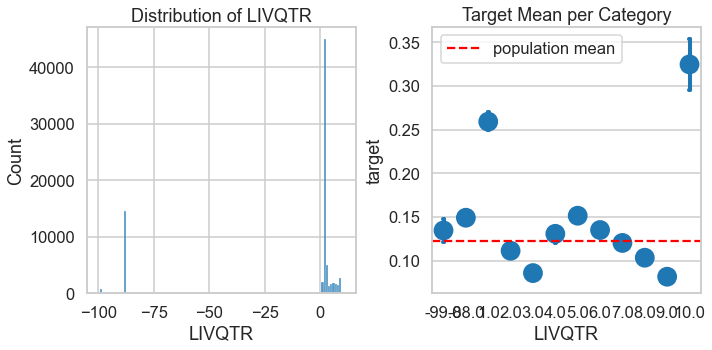

In [1351]:
dstools.explore_data_catbin(['LIVQTR'], df, 'target')

In [1352]:
# LIVQTR will need to be OHE, but I can combine some labels and not lose
# much information

df['LIVQTR'].value_counts()

 2.0     44955
-88.0    14502
 3.0      4975
 9.0      2730
 1.0      1921
 6.0      1746
 5.0      1729
 7.0      1562
 8.0      1479
 4.0      1254
-99.0      698
 10.0      274
Name: LIVQTR, dtype: int64

Category labels from the data dictionary:
1. A mobile home
2. A one-family house detached from any other house
3. A one-family house attached to one or more houses
4. A building with 2 apartments
5. A building with 3 or 4 apartment
6. A building with 5 to 9 apartments
7. A building with 10 to 19 apartments
8. A building with 20 to 49 apartments 
9. A building with 50 or more apartments
10. Boat, RV, van, etc.

-99. Question seen but category not selected

-88. Missing / Did not report

I will combine these 10 categories into 4:
- 1) Mobile home
- 2 and 3 -> 2) House
- 4 through 9 -> 3) Apartment
- 10 -> 4) Boat, RV, van


In [1353]:
# Combine some of the categories in my engineered feature LIVQTR_2
df.loc[df['LIVQTR']==1, 'LIVQTR_2'] = 1
df.loc[df['LIVQTR'].isin([2, 3]), 'LIVQTR_2'] = 2
df.loc[df['LIVQTR'].isin([4,5,6,7,8,9]), 'LIVQTR_2'] = 3
df.loc[df['LIVQTR']==10, 'LIVQTR_2'] = 4

In [1354]:
df['LIVQTR_2'].value_counts()

2.0    49930
3.0    10500
1.0     1921
4.0      274
Name: LIVQTR_2, dtype: int64

In [1355]:
df['LIVQTR_2'].isna().sum()

15200

In [1356]:
# Fill in -88 and -99 values from original feature
df.loc[df['LIVQTR']==-88, 'LIVQTR_2'] = -88
df.loc[df['LIVQTR']==-99, 'LIVQTR_2'] = -99
print(df['LIVQTR_2'].value_counts())
df['LIVQTR_2'].isna().sum()

 2.0     49930
-88.0    14502
 3.0     10500
 1.0      1921
-99.0      698
 4.0       274
Name: LIVQTR_2, dtype: int64


0

In [1357]:
# Combine a few rare Married Status labels
# Adding 3 - divorced and 4 - separated into 2 - Widowed (all sound single now
# but used to be married)
# 1 is married, and 5 is never married

df.loc[df['MS']==1, 'MS_2'] = 1
df.loc[df['MS'].isin([2, 3, 4]), 'MS_2'] = 2
df.loc[df['MS']==5, 'MS_2'] = 3
df.loc[df['MS']==-88, 'MS_2'] = -88
df.loc[df['MS']==-99, 'MS_2'] = -99
print(df['MS_2'].value_counts())
df['MS_2'].isna().sum()

 1.0     45740
 2.0     17835
 3.0     13762
-99.0      488
Name: MS_2, dtype: int64


0

In [1358]:
# Review TNUM_PS
df['TNUM_PS'].value_counts()

 0.0     45969
-88.0    15652
 1.0     10678
 2.0      3138
-99.0     1525
 3.0       863
Name: TNUM_PS, dtype: int64

In [1359]:
# These represent the number of people in the household who plan to go to
# post-secondary classes in 2021. Since there aren't a lot of 2 and 3 values,
# will combine them into 1 so it's just a Yes have people who plan to take
# PS classes, or No have none in the household.

df['TNUM_PS_2'] = df['TNUM_PS']
df.loc[df['TNUM_PS_2'].isin([2, 3]), 'TNUM_PS_2'] = 1

df['TNUM_PS_2'].value_counts()

 0.0     45969
-88.0    15652
 1.0     14679
-99.0     1525
Name: TNUM_PS_2, dtype: int64

In [1360]:
# drop UI_RECV from cat_cols, as majority of values are -88 missing
df['UI_RECV'].value_counts(normalize=True)

-88.0    0.847941
 1.0     0.121825
 2.0     0.027857
-99.0    0.002377
Name: UI_RECV, dtype: float64

In [1361]:
# Update running lists of categorical and numeric columns
cat_cols_orig.remove('UI_RECV')

cat_cols_eng.append('MS_2')
cat_cols_eng.append('LIVQTR_2')
cat_cols_eng.append('TNUM_PS_2')

## Review Locations of -88 Missing
There are some sets of predictor columns that seem to have the same number of -88 values, from looking at the value counts. But the data dictionary doesn't provide much info on what -88 represents.

I will try to visualize these to see if there are patterns. Perhaps I can use combine missing indicator columns.

In [1362]:
# original predictor columns, ordered by when questions were presented in
# the questionnaire

q_order = ['TBIRTH_YEAR','EGENDER','RHISPANIC','RRACE','EEDUC','MS',
           'THHLD_NUMKID','THHLD_NUMADLT','RECVDVACC','HADCOVID',
           'WRKLOSS','EXPCTLOSS','ANYWORK','TW_START','UI_APPLY','UI_RECV',
           'SSA_RECV','SSA_APPLY','EIP','EXPNS_DIF','SPNDSRC1',
           'SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5','SPNDSRC6','SPNDSRC7',
           'SPNDSRC8','FEWRTRIPS','FEWRTRANS','PLNDTRIPS','CURFOODSUF',
           'FREEFOOD','SNAP_YN','TSPNDFOOD','TSPNDPRPD','ANXIOUS','WORRY',
           'INTEREST','DOWN','HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 
           'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8','DELAY','NOTGET',
           'PRESCRIPT','MH_SVCS','MH_NOTGET','TENURE','LIVQTR','ENROLL1',
           'ENROLL2','ENROLL3','TNUM_PS','INCOME']

In [1363]:
# create a copy of the columns so I can replace -88 with nulls and visualize
nan_viz = df[q_order].copy()
print(list(nan_viz.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [1364]:
# replace -88s with nans
nan_viz.replace(-88, np.nan, inplace=True)
print(list(nan_viz.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 65991, 519, 795, 2212, 2915, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7771, 8032, 8195, 10775, 11054, 12614, 12614, 12614, 12614, 13204, 13204, 13204, 13204, 13204, 13204, 13204, 13204, 13906, 13906, 13906, 13906, 13906, 14502, 14502, 57437, 57437, 57437, 15652, 16311]


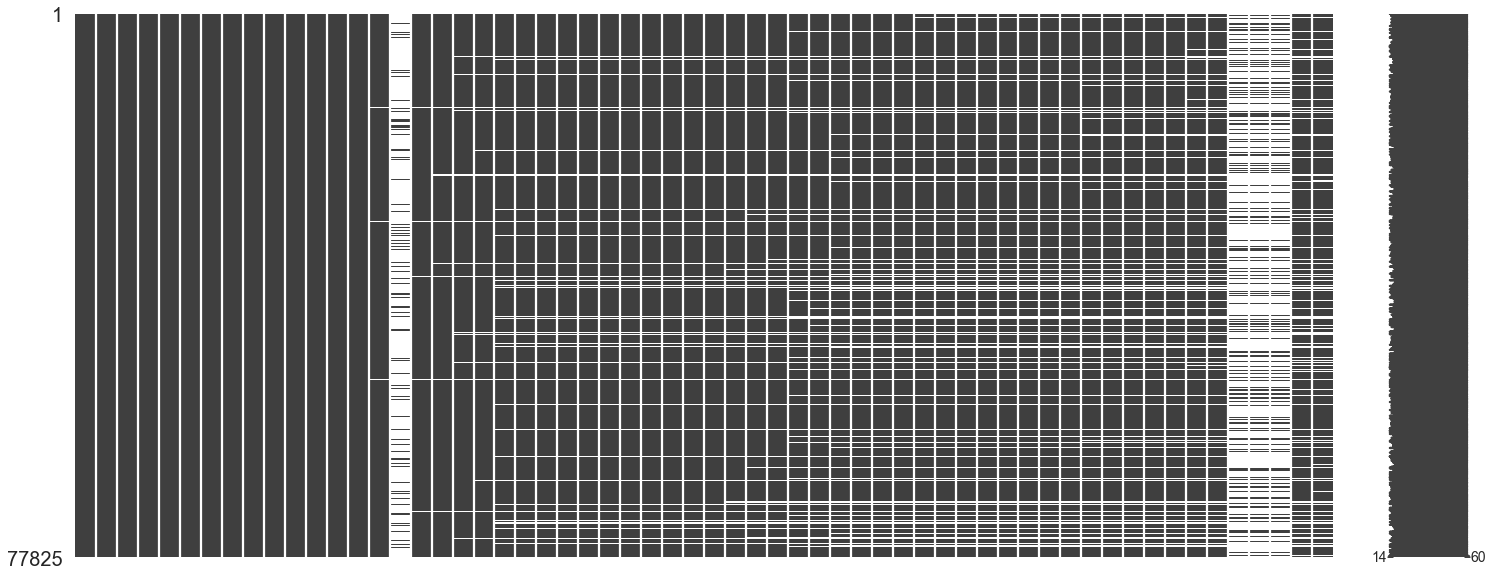

In [1365]:
# visualize where the -88 values are
missingno.matrix(nan_viz);

Hmm, when I look at them in the order the questions were presented, I see that with the exception of a few columns that have a lot of nans, once missing answers start showing up, the rest of that record has missing answers.

**I suspect that the -88 Missing placeholder indicates that the respondent exited the questionnaire prematurely, and Census kept the incomplete answers in the sample.**

After re-reviewing the technical documentation, I found this paragraph buried towards the end:

>Responses are made up of complete interviews and sufficient partial interviews. A sufficient partial interview is an incomplete interview in which the household or person answered enough of the questionnaire to be considered a complete interview. Some remaining questions may have been edited or imputed to fill in missing values. Insufficient partial interviews are considered to be nonrespondents.

But there are a few columns that stand out as having a lot of -88 values and aren't following this pattern. I would like to look further into those before deciding how to proceed.

In [1366]:
# look at sum of missing values for each question, in order they were asked
# Which columns don't follow the steady increase?
missing_sum = nan_viz.isna().sum(axis=0)
missing_sum.loc[q_order]

TBIRTH_YEAR          0
EGENDER              0
RHISPANIC            0
RRACE                0
EEDUC                0
MS                   0
THHLD_NUMKID         0
THHLD_NUMADLT        0
RECVDVACC            0
HADCOVID             0
WRKLOSS              0
EXPCTLOSS            0
ANYWORK              0
TW_START             0
UI_APPLY           197
UI_RECV          65991
SSA_RECV           519
SSA_APPLY          795
EIP               2212
EXPNS_DIF         2915
SPNDSRC1          7438
SPNDSRC2          7438
SPNDSRC3          7438
SPNDSRC4          7438
SPNDSRC5          7438
SPNDSRC6          7438
SPNDSRC7          7438
SPNDSRC8          7438
FEWRTRIPS         7438
FEWRTRANS         7438
PLNDTRIPS         7438
CURFOODSUF        7771
FREEFOOD          8032
SNAP_YN           8195
TSPNDFOOD        10775
TSPNDPRPD        11054
ANXIOUS          12614
WORRY            12614
INTEREST         12614
DOWN             12614
HLTHINS1         13204
HLTHINS2         13204
HLTHINS3         13204
HLTHINS4   

It looks like the four columns that don't fit the pattern are `UI_RECV`, `ENROLL1`, `ENROLL2`, and `ENROLL3`. 

I already confirmed above that the school enrollment questions which had a bunch of -88 values were mostly people who reported 0 kids in the household, so I don't need to confirm that again.

I had also already removed `UI_RECV` from my list of columns to explore further because if the high number of -88 values, but I'll look at it again here to make sure what I see fits my hypothesis about the meaning of the -88 values.

In [1367]:
# UI_APPLY might be related to UI_RECV. Let's look at both and see.
df['UI_APPLY'].value_counts()

 0.0     65536
 1.0     11875
-99.0      217
-88.0      197
Name: UI_APPLY, dtype: int64

In [1368]:
df['UI_RECV'].value_counts()

-88.0    65991
 1.0      9481
 2.0      2168
-99.0      185
Name: UI_RECV, dtype: int64

In [1369]:
# What is the sum of people who answered No (0) or didn't answer 'UI_APPLY'?
print(65536 + 217 + 197)

65950


That's pretty darn close. I'm thinking `UI_RECV` was only presented to people who said they actually applied for unemployment benefits, so most people weren't shown it.

## Strategy for Incomplete Questionnaires

I found the section of the technical documentation that says there are incomplete questionnaires, and the patterns I can see in the responses matches that. Now I need to decide whether to simply drop these incomplete answers and use only the complete ones, or account for them in some way.

To decide, I'll take a look at the class distribution for incomplete versus complete questionnaires and see if there appears to be a difference.

In [1370]:
# drop the columns I know weren't shown to everyone
q_order.remove('ENROLL1')
q_order.remove('ENROLL2')
q_order.remove('ENROLL3')
q_order.remove('UI_RECV')

In [1371]:
# populate incomplete column with sum of -88 values in top-level q columns
def sum_neg88(row):
    missing = row.isin([-88]).sum(axis=0)
    return missing

df['incomplete'] = df[q_order].apply(sum_neg88, axis=1)

df['incomplete']

0        37
1         0
2        39
3         0
4         0
         ..
77820     0
77821     0
77822     0
77823     0
77824     0
Name: incomplete, Length: 77825, dtype: int64

In [1372]:
# Add 'incomplete' to the list of engineered cat_cols
cat_cols_eng.append('incomplete')

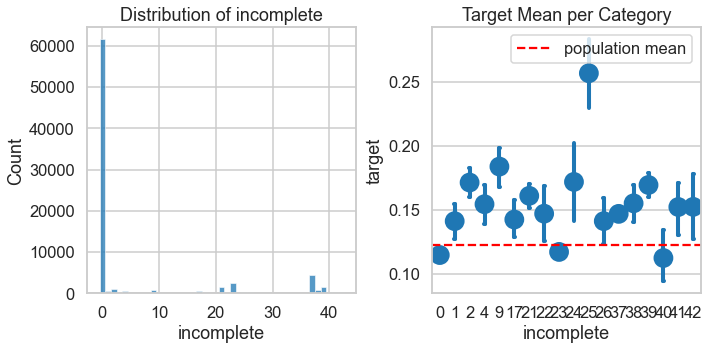

In [1373]:
# plot number of incomplete questionnaires against target
dstools.explore_data_catbin(['incomplete'], df, 'target')

Interesting, so there is some variability based on number of questions.

I will keep the `incomplete` column that has the count of complete questions for each respondent (i.e. how many questions were left when they exited) but also create a binary column to indicate whether they finished the whole thing or not.

To make it easy to get rid of the -88 values I will set them equal to the 'first', or lowest value in the column, and when I use sklearn's OneHotEncoder, I will drop the first column.

I will convert -88 to -2 so it will be 'first' and will convert -99, which represents someone viewing but skipping a particular question, as -1.

In [1374]:
# Create inc_binary column
df.loc[df['incomplete'] == 0, 'inc_binary'] = 0
df.loc[df['incomplete'] > 0, 'inc_binary'] = 1

df['inc_binary'].value_counts()

0.0    61514
1.0    16311
Name: inc_binary, dtype: int64

In [1375]:
df['inc_binary'].isna().sum()

0

I'll do the same thing for -99 values. I'll create a numeric column to indicate the number of skipped questions based on -99, and will also OHE the -99 category for each categorical column so I can try modeling both ways and see which does better.

In [1376]:
# populate skipped column with sum of -88 values in top-level q columns
def sum_neg99(row):
    missing = row.isin([-99]).sum(axis=0)
    return missing

df['skipped'] = df[q_order].apply(sum_neg99, axis=1)

df['skipped'].value_counts()

0     54560
1      8389
7      4782
2      2647
6      2188
3      1344
5      1261
4       920
8       758
9       345
10      160
11       70
12       48
13       34
14       32
23       27
21       24
29       23
18       20
17       18
15       17
16       16
19       16
20       15
25       15
22       15
26       12
27        9
30        8
24        7
28        7
39        6
34        6
32        6
31        4
33        3
35        3
36        3
38        3
37        2
40        2
Name: skipped, dtype: int64

In [1377]:
# add new columns to lists
num_cols_eng.append('incomplete')
num_cols_eng.append('skipped')
cat_cols_eng.append('inc_binary')

In [1378]:
# replace -88 with -2 and -99 with -1 for all cat cols
# I will still need to deal with some missing values in num cols

for col in cat_cols_orig + cat_cols_eng:
    df.loc[df[col] == -88, col] = -2
    df.loc[df[col] == -99, col] = -1

# check for remaining -88 and -99 values
print(list(df[cat_cols_orig + cat_cols_eng].isin([-88, -99]).sum(axis=0)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [1379]:
# take a look at which num cols have -88 or -99 values
df[num_cols_eng + num_cols_orig].isin([-88, -99]).sum(axis=0)

PROP_FOODSPEND_HOME    14015
AGE                        0
incomplete                 0
skipped                    0
THHLD_NUMADLT              0
THHLD_NUMKID               0
TNUM_PS                17177
dtype: int64

I will need to remember to do something else with these numerical values when I prepare the data for modeling, as they will need to be replaced with something. But for now, so I can chart the columns against the target, I will see if it's safe to assign -2 and -1 to my placeholders. I want to set them on a scale that will work well with the rest of the values when I chart them on a continuous x axis, but also be easy to single out for replacement with something else later.

In [1380]:
# are there any values less than 0 other than -88 and -99?
df.loc[df['PROP_FOODSPEND_HOME'] < 0, ['PROP_FOODSPEND_HOME']].value_counts()

PROP_FOODSPEND_HOME
-88.0                  10805
-99.0                   3210
dtype: int64

In [1381]:
# are there any values less than 0 other than -88 and -99?
df.loc[df['TNUM_PS'] < 0, ['TNUM_PS']].value_counts()

TNUM_PS
-88.0      15652
-99.0       1525
dtype: int64

In [1382]:
# Both columns look fine to replace with -2 and -1
for col in ['TNUM_PS', 'PROP_FOODSPEND_HOME']:
    df.loc[df[col] == -88, col] = -2
    df.loc[df[col] == -99, col] = -1

# EXPLORE
Now I have my predictors fairly cleaned up: some rare labels combined, a better understanding of the -99 (now -1) and -88 (now -2) missing indicators, and a few features engineered.

I will visualize each variable's distribution and relationship to the target to see if any need further engineering.

In [1383]:
rerun_viz = False

In [1384]:
# reset my lists of categorical and numeric columns after engineering
# I'll have a new list for potentially ordinal columns,
# because they will be treated differently in preprocessing

# These are the columns that only have one version
cat_cols = ['ANYWORK','CHNGHOW1','CHNGHOW10','CHNGHOW11','CHNGHOW12',
            'CHNGHOW2','CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6',
            'CHNGHOW7','CHNGHOW8','CHNGHOW9','DELAY','EGENDER','EIP',
            'EXPCTLOSS','FEWRTRANS','FEWRTRIPS','FREEFOOD','HADCOVID',
            'MH_NOTGET', 'MH_SVCS','NOTGET','PLNDTRIPS','PRESCRIPT','RHISPANIC',
            'RRACE','SNAP_YN','SPNDSRC1','SPNDSRC2','SPNDSRC3',
            'SPNDSRC4','SPNDSRC5','SPNDSRC6','SPNDSRC7','SPNDSRC8',
            'SSA_APPLY','SSA_RECV','TENURE','TW_START','UI_APPLY','WRKLOSS']

# I engineered versions of these columns, but these are the originals
# They have more rare labels, and provide more detail than the engineered 
# versions
cat_cols_v1 = ['HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 
               'HLTHINS6', 'HLTHINS7', 'HLTHINS8', 'ENROLL1', 'ENROLL2', 
               'ENROLL3', 'EST_MSA', 'LIVQTR', 'MS']

# These are the engineered versions of the columns that I can try if the
# original versions don't perform well
cat_cols_v2 = ['HLTHINS','inc_binary','IN_METRO_AREA', 'SCHOOL_KIDS', 
               'LIVQTR_2', 'MS_2', 'TNUM_PS_2']

# These are the columns that are categorical, but I think can be treated as
# numbers
ord_cols = ['ANXIOUS','CURFOODSUF','DOWN','EEDUC','EXPNS_DIF','INCOME',
            'INTEREST','WORRY']

# Numeric columns
# incomplete is listed here because I'm going to include it either way
num_cols = ['THHLD_NUMADLT','THHLD_NUMKID','PROP_FOODSPEND_HOME','AGE']

# I'll replace incomplete with inc_binary, which is a categorical column
num_cols_v1 = ['incomplete', 'TNUM_PS']

# I can try out this column instead of OHE -99 as separate columns
num_cols_v2 = ['skipped']

In [1385]:
# Map v1 columns to v2 columns so I know which versions are connected
v1_v2_map = [{'v1': ['HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 
                     'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8'], 
              'v2': ['HLTHINS'], 'priority': 'v1'},
             {'v1': ['ENROLL1', 'ENROLL2', 'ENROLL3'], 'v2': ['SCHOOL_KIDS'], 
              'priority': 'v2'},
             {'v1': ['EST_MSA'], 'v2': ['IN_METRO_AREA'], 'priority': 'v1'},
             {'v1': ['LIVQTR'], 'v2': ['LIVQTR_2'], 'priority': 'v1'},
             {'v1': ['MS'], 'v2': ['MS_2'], 'priority': 'v1'},
             {'v1': ['TNUM_PS'], 'v2': ['TNUM_PS_2'], 'priority': 'v1'},
             {'v1': ['incomplete'], 'v2': ['inc_binary'], 'priority': 'v1'}
    
]

## Target

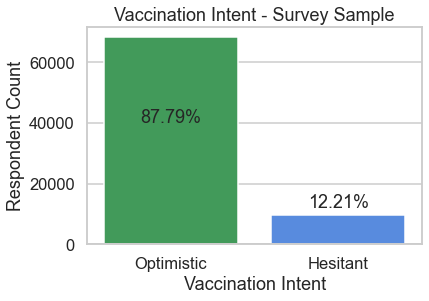

In [1386]:
# Visualize Target Distribution
# some code adapted from:
# https://github.com/mwaskom/seaborn/issues/1027

with sns.plotting_context(context='talk'):

    colors = sns.color_palette(['#34a853', '#4285f4'])

    fig, ax = plt.subplots()

    sns.barplot(x='target', y='target', data=df, 
                estimator=lambda x: len(x), ci=68, ax=ax, palette=colors)

    ax.set_title('Vaccination Intent - Survey Sample')
    ax.set_ylabel('Respondent Count')
    ax.set_xlabel('Vaccination Intent')
    
    ax.text(x=0, y=40000, s=f"{opt_per}%", ha='center')
    ax.text(x=1, y=12000, s=f"{pes_per}%", ha='center')
    ax.set_xticklabels(['Optimistic', 'Hesitant']);

In [1387]:
opt_per = np.round(df['target'].value_counts(1).loc[0.0] * 100, 2)
pes_per = np.round(df['target'].value_counts(1).loc[1.0] * 100, 2)
print(opt_per, pes_per)

87.79 12.21


In [1388]:
# Check whether numeric columns should be visulized separately or with cat_cols
# depending on how many unique values they have
for col in num_cols + num_cols_v1 + num_cols_v2:
    print(f"Column {col} has {len(df[col].value_counts())} values.")

Column THHLD_NUMADLT has 10 values.
Column THHLD_NUMKID has 6 values.
Column PROP_FOODSPEND_HOME has 2097 values.
Column AGE has 71 values.
Column incomplete has 18 values.
Column TNUM_PS has 6 values.
Column skipped has 41 values.


I really only have 4 numeric values in terms of how I want to visualize them: `PROP_FOODSPEND_HOME`, `AGE`, `incomplete`, and `skipped`. The other 3 are numbers but are discrete and have few values.

## Categorical Features

In [1389]:
cats_viz = cat_cols + cat_cols_v1 + cat_cols_v2

if rerun_viz:
    dstools.explore_data_catbin(cats_viz, df, 'target')

### Chi-Squared for Categorical versus Target

In [1390]:
import scipy.stats as stats

In [1391]:
# calculate chi-squared statistic for each categorical predictor with target
# Make a list of any independent variables, which could be removed
# dependent variables are ones we want to keep

ind_cats = []
prob = 0.95

for col in cat_cols + cat_cols_v1 + cat_cols_v2:
    # get the contingency table using crosstab
    crosstab = pd.crosstab(df['target'], df[col])

    # use scipy to get chi2 statistic and other info
    stat, p, dof, expected = stats.chi2_contingency(crosstab)

    #https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
    # interpret test-statistic
    critical = stats.chi2.ppf(prob, dof)
    # append features that are not dependent on target to list
    if abs(stat) <= critical:
        ind_cats.append([col, stat, p])
        
ind_cats_df = pd.DataFrame(ind_cats, columns=['feature name', 'chi2 stat', 'p-value'])
ind_cats_df

,feature name,chi2 stat,p-value
0,SSA_APPLY,2.973671,0.395702


Chi-squared test confirmed what I guessed from the visualizations, which is that all the categorical features have a dependent relationship on the target, with the exception of `SSA_APPLY`.

In [1392]:
# RRACE category labels are:
#1) White, Alone
#2) Black, Alone
#3) Asian, Alone
#4) Any other race alone, or race in combination

# Are the proportions of respondents similar to population proportions?
df['RRACE'].value_counts(normalize=True)

1.0    0.825609
2.0    0.078073
3.0    0.050434
4.0    0.045885
Name: RRACE, dtype: float64

In [1393]:
df['RHISPANIC'].value_counts(normalize=True)

0.0    0.904953
1.0    0.095047
Name: RHISPANIC, dtype: float64

The [2020 Census statistics](https://www.census.gov/quickfacts/fact/table/US/PST045219) report that the US population is about 76% White, 13% Black, and about 6% Asian. About 18% of the population identifies as Hispanic or Latinx.

In this data, White respondents are overrepresented, Black respondents are far underrepresented, Asian respondents are slightly underrepresented, and Hispanic/Latinx respondents are far underrepresented.

Focusing on the actual answers (values of 0 and above):
- `RRACE` has few respondents who are not white. In this data, White respondents are overrepresented, Black and Hispanic/Latinx respondents are far underrepresented, and Asian respondents are slightly underrepresented.
- `SPNDSRC8` value of 1 has a much higher target mean than the population. Looking at that question, it's related to whether the respondent used SNAP funds in the past 7 days. Since I already have a column to indicate SNAP participation, I'll drop this column.

Focusing on the -2 and -1 answers, few respondents opted not to answer any given question. I'm considering whether to do something similar to what I did with Incomplete where I create a single column to represent whether the respondent skipped ANY questions.

In [1394]:
# drop `SPNDSRC8`
cat_cols.remove('SPNDSRC8')

## Ordinal Categorical Features

In [1395]:
# explore ordinal categorical columns
if rerun_viz:
    dstools.explore_data_catbin(ord_cols + ['THHLD_NUMADLT', 'THHLD_NUMKID'], 
                            df, 'target')

Focusing on the actual answers (values of 0 and above):
- `ANXIOUS`, `DOWN`, `INTEREST` and `WORRY` all share a similar pattern. 
    - Responses of 1 (Not at All) are fairly close to the population mean but a bit below
    - Responses of 2 (Several Days) are well below population mean
    - Responses of 3 (More than half the days) are again fairly close to the population mean but a bit above
    - Responses of 4 (Nearly every day) are well above the population mean
    
    I'm not sure I can treat these as numbers, I think I have to OHE them.


- `THHLD_NUMADLT` doesn't appear to have much of a linear relationship with target mean. Most values are pretty close to the mean, and those that appear to deviate have very few observations. I'm going to keep this column, but consolidate the number of adults above 3 with 3.


- The rest of the features do show a linear relationship with the target mean, so I will treat them as numeric columns.

In [1396]:
# Combine THHLD_NUMADLT > 3 with 3
df.loc[df['THHLD_NUMADLT'] > 3, 'THHLD_NUMADLT'] = 3
df['THHLD_NUMADLT'].value_counts()

2.0    43223
1.0    17308
3.0    17294
Name: THHLD_NUMADLT, dtype: int64

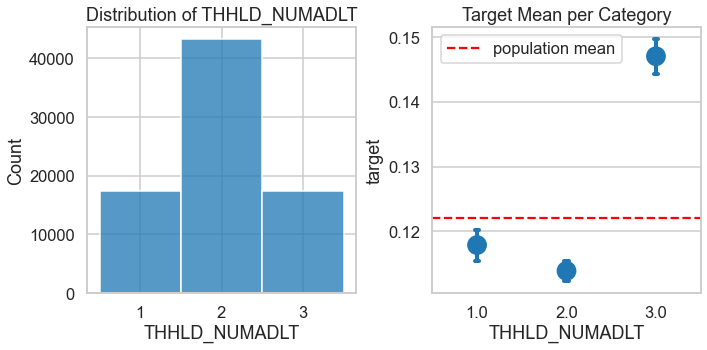

In [1397]:
# review THHLD_NUMADLT's new distribution
dstools.explore_data_catbin(['THHLD_NUMADLT'], df, 'target')

In [1398]:
# Reorganize my lists of columns by type, based on what I've learned and updated here
cat_cols = cat_cols + ['ANXIOUS', 'DOWN', 'INTEREST', 'WORRY', 'THHLD_NUMADLT']

for col in ['ANXIOUS', 'DOWN', 'INTEREST', 'WORRY']:
    ord_cols.remove(col)
    
num_cols.remove('THHLD_NUMADLT')

print(cat_cols)
print(ord_cols)
print(num_cols)

['ANYWORK', 'CHNGHOW1', 'CHNGHOW10', 'CHNGHOW11', 'CHNGHOW12', 'CHNGHOW2', 'CHNGHOW3', 'CHNGHOW4', 'CHNGHOW5', 'CHNGHOW6', 'CHNGHOW7', 'CHNGHOW8', 'CHNGHOW9', 'DELAY', 'EGENDER', 'EIP', 'EXPCTLOSS', 'FEWRTRANS', 'FEWRTRIPS', 'FREEFOOD', 'HADCOVID', 'MH_NOTGET', 'MH_SVCS', 'NOTGET', 'PLNDTRIPS', 'PRESCRIPT', 'RHISPANIC', 'RRACE', 'SNAP_YN', 'SPNDSRC1', 'SPNDSRC2', 'SPNDSRC3', 'SPNDSRC4', 'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', 'SSA_APPLY', 'SSA_RECV', 'TENURE', 'TW_START', 'UI_APPLY', 'WRKLOSS', 'ANXIOUS', 'DOWN', 'INTEREST', 'WORRY', 'THHLD_NUMADLT']
['CURFOODSUF', 'EEDUC', 'EXPNS_DIF', 'INCOME']
['THHLD_NUMKID', 'PROP_FOODSPEND_HOME', 'AGE']


## Numeric Features

In [1399]:
if rerun_viz:
    dstools.explore_data_catbin(num_cols + num_cols_v1 + num_cols_v2, df, 
                                'target', pred_type='cont')

Looking at AGE, I see the histogram is not smooth, but rather appears to have spikes in certain areas. After reviewing the data dictionary again, I notice there are some columns indicating imputed values for some features. I'd like to understand the proportion of imputed values.

In [1400]:
imputed_ind = ['ABIRTH_YEAR','AGENDER','AHISPANIC','ARACE','AEDUC',
           'AHHLD_NUMPER','AHHLD_NUMKID']

for col in imputed_ind:
    print(np.round(df[col].value_counts(normalize=True) * 100, 4))
    print()

2.0    99.5027
1.0     0.4973
Name: ABIRTH_YEAR, dtype: float64

2.0    99.6646
1.0     0.3354
Name: AGENDER, dtype: float64

2.0    97.8901
1.0     2.1099
Name: AHISPANIC, dtype: float64

2.0    97.903
1.0     2.097
Name: ARACE, dtype: float64

2.0    99.7019
1.0     0.2981
Name: AEDUC, dtype: float64

2.0    96.6553
1.0     3.3447
Name: AHHLD_NUMPER, dtype: float64

2.0    98.4041
1.0     1.5959
Name: AHHLD_NUMKID, dtype: float64



None of the percentages of imputed values look too large. I'm comfortable with this.

Focusing on the actual answers (values of 0 and above):

- I don't see much difference in feature distribution of `PROP_FOODSPEND_HOME` for the different target classes 

## Exploring States
I initially chose to leave out the State, as it has high cardinality and I'd prefer to use the other features such as in metro area instead. But perhaps a visualization will help me decide if I want to try to include it somehow.


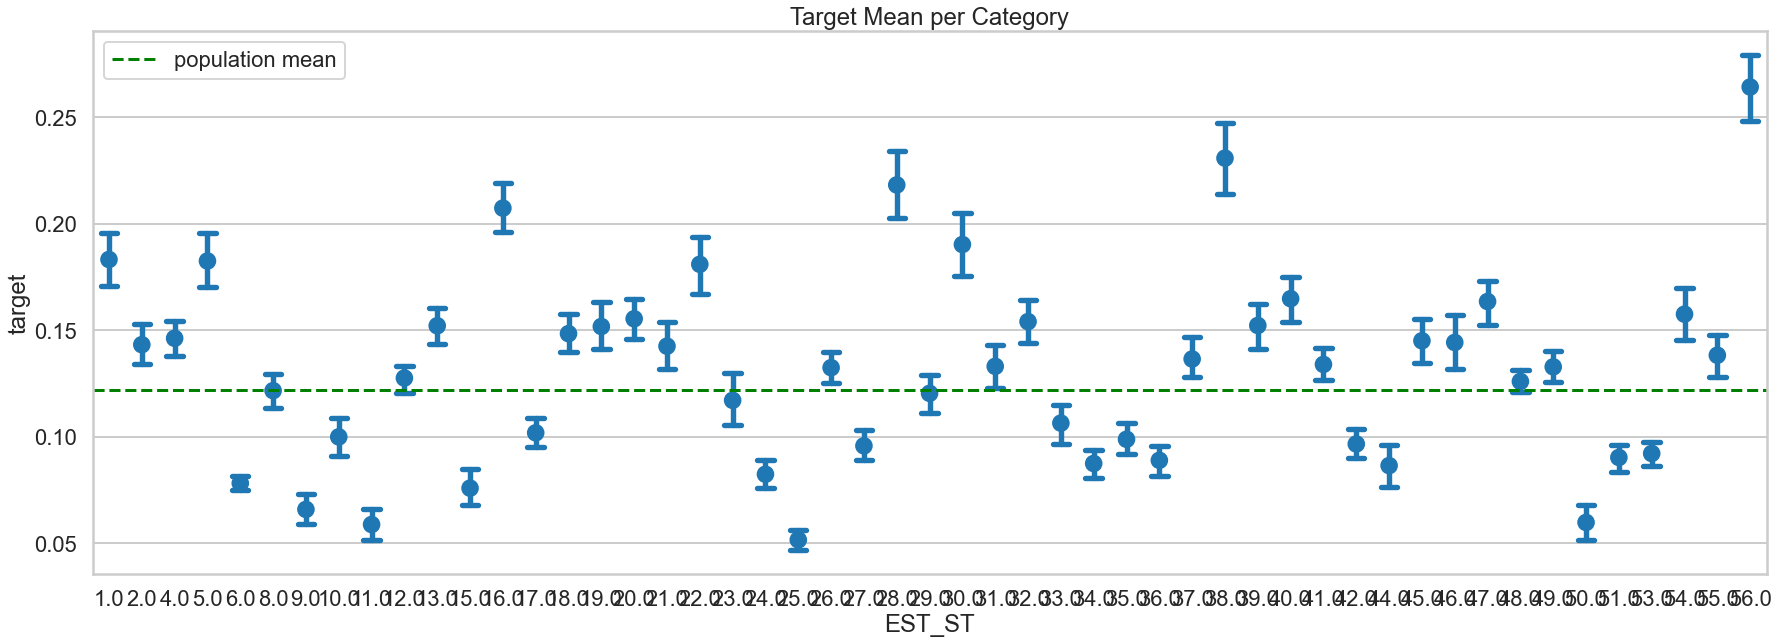

In [1401]:
# plot mean of target for each state and compare against target mean for whole sample
pop_mean = np.round(df['target'].mean(), 4)

with sns.plotting_context(context='poster'):

    fig, ax = plt.subplots(figsize=(30, 10))

    sns.pointplot(data=df, x='EST_ST', y='target', 
                  ci=68, ax=ax, join=False, scale=1, capsize=0.5)
    ax.set_title("Target Mean per Category")
    ax.axhline(pop_mean, color='green', ls='dashed', label='population mean')
    ax.legend();

In [1402]:
# using data from https://www.archives.gov/electoral-college/2020,
# separate states based on the political party to which they allocated 
# the majority of their electoral college votes in the 2020 presidential 
# election

# data dictionary maps state codes to names
dems = [4, 6, 8, 9, 10, 11, 13, 15, 17, 23, 24, 25, 26, 27, 32, 33, 34, 35, 
        36, 41, 42, 44, 50, 51, 53, 55]
reps = [1, 2, 5, 12, 16, 18, 19, 20, 21, 22, 28, 29, 30, 31, 37, 38, 39, 40, 
        45, 46, 47, 48, 49, 54, 56]

df.loc[df['EST_ST'].isin(dems), 'polit'] = 'Dem'
df.loc[df['EST_ST'].isin(reps), 'polit'] = 'Rep'
df['polit'].value_counts()

Dem    45211
Rep    32614
Name: polit, dtype: int64

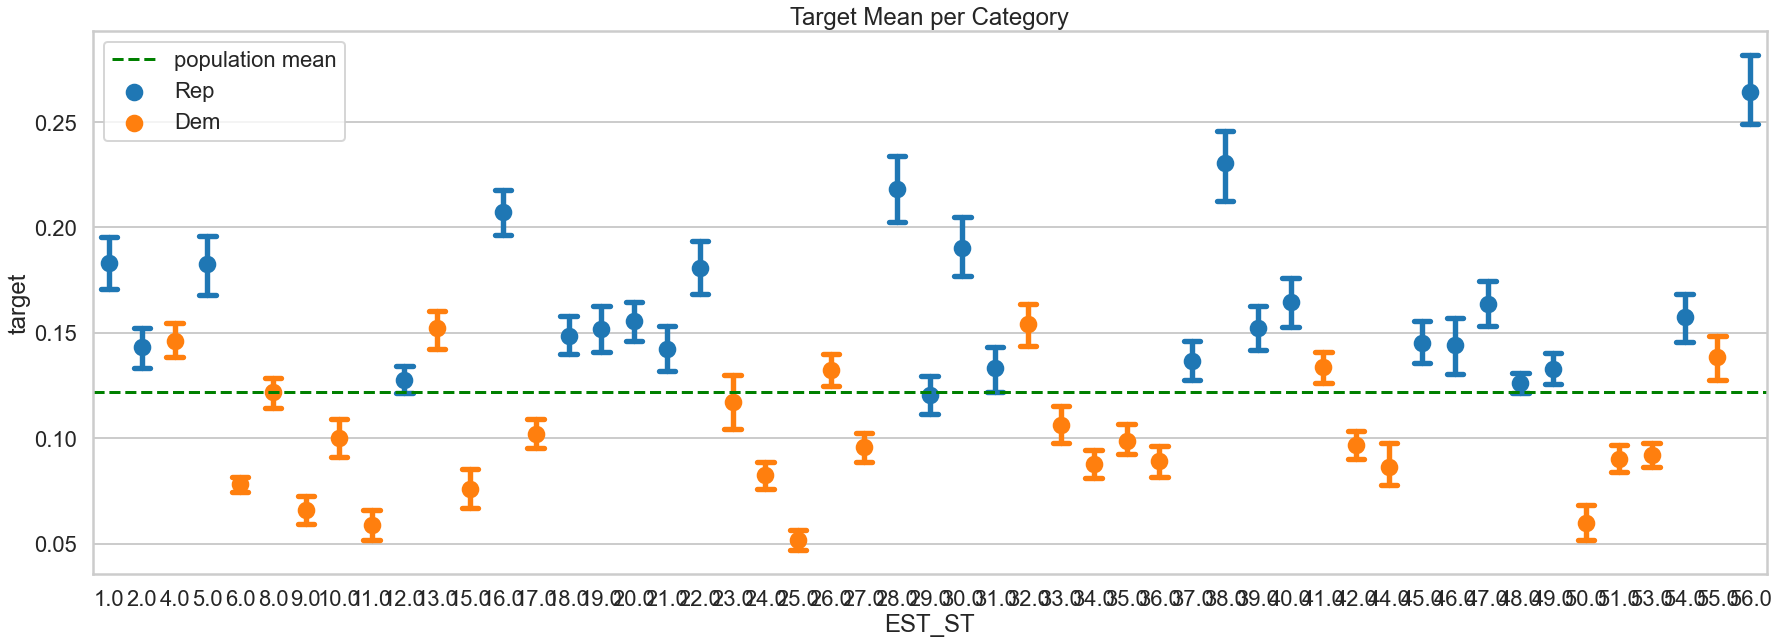

In [1403]:
# plot target means per state, color coded by democratic or republican vote
# for presidential candidate in the last election

with sns.plotting_context(context='poster'):
    fig, ax = plt.subplots(figsize=(30, 10))

    sns.pointplot(data=df, x='EST_ST', y='target', hue='polit',
                  ci=68, ax=ax, join=False, scale=1, capsize=0.5)
    ax.set_title("Target Mean per Category")
    ax.axhline(pop_mean, color='green', ls='dashed', label='population mean')
    ax.legend();

It does look like all of the states that cast the majority of their electoral college votes for Trump in the 2020 presidential election are at or above population mean, so they lean more towards vaccine hesitancy. 

Some of the states that voted for Biden (orange) are at or above population mean too. But almost all of the states that are below population mean (lean more towards vaccine optimism) are Democratic majority.

Much as I wanted to avoid playing up the perception of a political divide, it does appear to be supported by the data. I will create a binary variable where 1 indicates the household was in a 'red' state, and 0 indicates a household in a 'blue' state.

In [1404]:
# Majority Democratic will be 0; majority Republican will be 1
df.loc[df['EST_ST'].isin(dems), 'polit'] = 0
df.loc[df['EST_ST'].isin(reps), 'polit'] = 1

cat_cols.append('polit')

df['polit'].value_counts()

0    45211
1    32614
Name: polit, dtype: int64

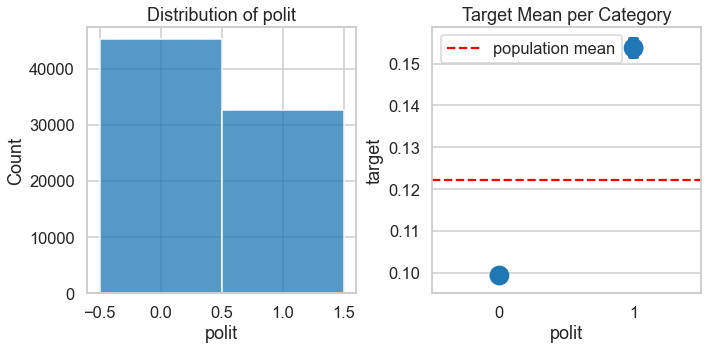

In [1405]:
# review polit's new distribution
dstools.explore_data_catbin(['polit'], df, 'target')

## Plan to deal with missing values in preprocessing

I need to decide how each set of columns will be preprocessed. Categorical columns will be OHE and I can drop a label or not. Numeric columns will be standardized, but I need to decide how to deal with placeholders and impute values.

In [1406]:
# get a list of all the columns I intend to model with
all_cols = cat_cols + cat_cols_v1 + cat_cols_v2 + ord_cols + num_cols + \
           num_cols_v1 + num_cols_v2

print(len(all_cols))
print(len(set(all_cols)))

79
79


### Categorical Columns
Some of my categorical columns have -2 values, which I will want to drop during OHE and will be replaced with the engineered 'incomplete' column. I need to separate these from the categorical columns which do NOT have -2 values, because I won't drop anything from those.

In [1407]:
# Create new dataframe including only the features I'll want to try out
# in my initial models
X = df[all_cols].copy()
y = df['target'].copy()

X.head()

,ANYWORK,CHNGHOW1,CHNGHOW10,CHNGHOW11,CHNGHOW12,CHNGHOW2,CHNGHOW3,CHNGHOW4,CHNGHOW5,CHNGHOW6,...,CURFOODSUF,EEDUC,EXPNS_DIF,INCOME,THHLD_NUMKID,PROP_FOODSPEND_HOME,AGE,incomplete,TNUM_PS,skipped
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-2.0,4.0,1.0,-2.0,0.0,-2.000000,65.0,37,-2.0,0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,5.0,3.0,6.0,1.0,0.800000,26.0,0,0.0,0
2,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,6.0,-2.0,-2.0,0.0,-2.000000,60.0,39,-2.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,4.0,4.0,3.0,0.0,1.000000,50.0,0,0.0,0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,6.0,2.0,4.0,1.0,0.322581,80.0,0,0.0,2


In [1408]:
# Loop through categorical columns and determine which have -2 and will need
# to have their first label dropped

all_cats = cat_cols + cat_cols_v1 + cat_cols_v2

cat_drop_first = []
cat_drop_none = []

for col in all_cats:
    if len(X.loc[X[col]==-2, col]) > 0:
        cat_drop_first.append(col)
    else:
        cat_drop_none.append(col)

In [1409]:
# Loop through lists to confirm results
for col in cat_drop_first:
    print(X[col].value_counts())

 0.0    38740
 1.0    34878
-2.0     4207
Name: CHNGHOW1, dtype: int64
 0.0    68799
 1.0     4819
-2.0     4207
Name: CHNGHOW10, dtype: int64
 0.0    72049
-2.0     4207
 1.0     1569
Name: CHNGHOW11, dtype: int64
 0.0    54509
 1.0    19109
-2.0     4207
Name: CHNGHOW12, dtype: int64
 0.0    56443
 1.0    17175
-2.0     4207
Name: CHNGHOW2, dtype: int64
 0.0    67959
 1.0     5659
-2.0     4207
Name: CHNGHOW3, dtype: int64
 0.0    51444
 1.0    22174
-2.0     4207
Name: CHNGHOW4, dtype: int64
 0.0    71127
-2.0     4207
 1.0     2491
Name: CHNGHOW5, dtype: int64
 0.0    36929
 1.0    36689
-2.0     4207
Name: CHNGHOW6, dtype: int64
 0.0    67489
 1.0     6129
-2.0     4207
Name: CHNGHOW7, dtype: int64
 0.0    58778
 1.0    14840
-2.0     4207
Name: CHNGHOW8, dtype: int64
 0.0    56697
 1.0    16921
-2.0     4207
Name: CHNGHOW9, dtype: int64
 0.0    46448
 1.0    17044
-2.0    13906
-1.0      427
Name: DELAY, dtype: int64
 4.0    49102
 3.0    12221
 1.0     7574
 2.0     6201
-2.0   

In [1410]:
# Loop through lists to confirm results
for col in cat_drop_none:
    print(X[col].value_counts())

 1.0    44266
 0.0    33312
-1.0      247
Name: ANYWORK, dtype: int64
0.0    46326
1.0    31499
Name: EGENDER, dtype: int64
 0.0    66184
 1.0    11349
-1.0      292
Name: EXPCTLOSS, dtype: int64
 0.0    68660
 1.0     8527
-1.0      638
Name: HADCOVID, dtype: int64
0.0    70428
1.0     7397
Name: RHISPANIC, dtype: int64
1.0    64253
2.0     6076
3.0     3925
4.0     3571
Name: RRACE, dtype: int64
 0.0    42009
 1.0    32097
-1.0     3719
Name: TW_START, dtype: int64
 0.0    48766
 1.0    28874
-1.0      185
Name: WRKLOSS, dtype: int64
2.0    43223
1.0    17308
3.0    17294
Name: THHLD_NUMADLT, dtype: int64
0    45211
1    32614
Name: polit, dtype: int64
0.0        51865
47900.0     3050
35620.0     2111
37980.0     2071
14460.0     2020
42660.0     1848
41860.0     1842
31080.0     1751
19100.0     1680
16980.0     1679
26420.0     1632
38060.0     1429
40140.0     1229
19820.0     1222
12060.0     1220
33100.0     1176
Name: EST_MSA, dtype: int64
 1.0    45740
 5.0    13762
 3.0    1

### Numeric and Ordinal columns
Now I have the numeric and ordinal columns which I will treat as numeric.

These will not be OHE, they will be standardized. I will need to determine the best way to remove the missing placeholders and impute them. 

I think I will want to simply nullify and impute the -2 values, since their info will be covered by the 'incomplete' column. But for -1 values indicating someone skipped just that question, I will probably want to create another column to indicate the respondent skipped that particular question.

In [1411]:
# populate lists of numeric and ordinal columns that will not be OHE
# and which have placholders to be removed and imputed  
# versus those which are fully filled
num_cols_filled = []
to_impute = []

for col in num_cols + num_cols_v1 + num_cols_v2 + ord_cols:
    vals = X[col].value_counts()
    if len(vals.loc[vals.index < 0]) > 0:
        to_impute.append(col)
    else:
        num_cols_filled.append(col)
        
print(to_impute)
print(num_cols_filled)

['PROP_FOODSPEND_HOME', 'TNUM_PS', 'CURFOODSUF', 'EXPNS_DIF', 'INCOME']
['THHLD_NUMKID', 'AGE', 'incomplete', 'skipped', 'EEDUC']


In [1412]:
def missingind_prep(df, col, dummy_val=-1):
    """Prepares numeric columns that have placeholders for modeling.
    
    Create a separate missing indicator column where col is populated
    with `dummy_val`.
    
    Replace all values less than 0 with np.nan, since these numbers represent
    placeholders in this dataset.
    
    Graph the distribution to help me decide which statistic would be 
    appropriate for imputing missing values.
    """
    skipped = col + '_skipped'
    
    # Create missing indicator column
    df.loc[df[col]==dummy_val, skipped] = 1
    df.loc[df[skipped].isna(), skipped] = 0

    # Nullify the -2 and -1 values to see the proportion distribution
    df.loc[df[col]<0, col] = np.nan

    # print descriptive statistics
    print(df[col].describe())

    #chart histogram
    fig, ax = plt.subplots()
    sns.histplot(df[col])
    plt.show();
    
    return df, skipped

count    63810.000000
mean         0.745933
std          0.225950
min          0.000000
25%          0.636364
50%          0.769231
75%          0.923077
max          1.000000
Name: PROP_FOODSPEND_HOME, dtype: float64


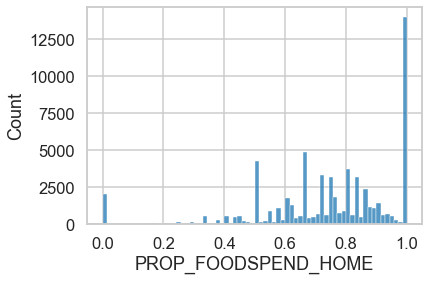

count    60648.000000
mean         0.322237
std          0.638175
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: TNUM_PS, dtype: float64


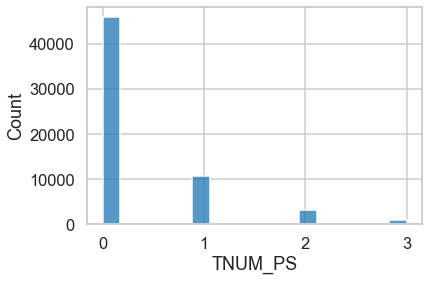

count    69644.000000
mean         1.340288
std          0.624428
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: CURFOODSUF, dtype: float64


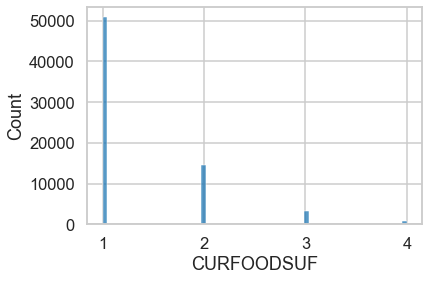

count    74463.000000
mean         1.801942
std          1.010840
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: EXPNS_DIF, dtype: float64


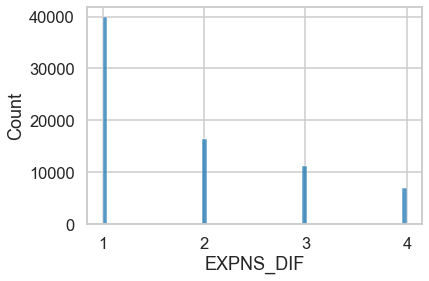

count    59429.000000
mean         4.640916
std          2.079498
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max          8.000000
Name: INCOME, dtype: float64


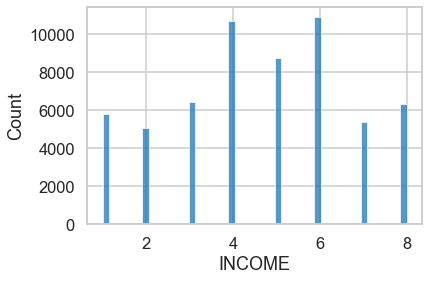

['PROP_FOODSPEND_HOME_skipped',
 'TNUM_PS_skipped',
 'CURFOODSUF_skipped',
 'EXPNS_DIF_skipped',
 'INCOME_skipped']

In [1413]:
missing_inds = []

for col in to_impute:
    # Create a missing indicator for -1 values
    X, ind_col = missingind_prep(X, col)
    missing_inds.append(ind_col)
    
missing_inds

PROP_FOODSPEND_HOME
- Represents the proportion of food spend that went towards food to be prepared at home versus food that already was prepared.
- By far the most common value is 1. Mean and median are around 0.75. I think the best bet is to impute this with mode.

TNUM_PS
- Represents the number of people in the household who plan to attend post-secondary classes.
- 0 is by far the most common, so will impute with mode.

CURFOODSUF
- Represents the level of food insufficiency in the past 7 days.
- 1 is by far the most common, so will impute with mode.

EXPNS_DIF
- Represents degree of difficulty meeting expenses
- Median and mode are both 1, but mean is significantly higher at 1.8 I think imputing with mean here is most representative.

INCOME
- Ordinally encoded income range pre-tax
- Mean seems like the most representative statistic to impute here.



In [1414]:
# append missing indicator columns to cat_col lists
cat_cols = cat_cols + missing_inds
cat_drop_none = cat_drop_none + missing_inds

num_cols_mode = ['PROP_FOODSPEND_HOME', 'TNUM_PS', 'CURFOODSUF']

num_cols_mean = ['EXPNS_DIF', 'INCOME']

## Summary of Explore

During the Explore phase, I reviewed distributions of the original and engineered features. I also visualized the impact of each feature on the target, focusing on the target mean for categorical variables. Since target is binary, the mean of the target for each feature class is a representation of the proportion of vaccine hesitant respondents in that feature class.

There were a handful of features that didn't appear to have much impact on target mean, but at this point I'm not removing anything. I will model all of the features in their near-original forms first to get a baseline, and will iterate to remove features or substitute engineered versions of features to improve performance.

Going into the modeling phase, I have several lists of feature columns which have been split up based on how I intend to preprocess them, and whether they are the 'original' or more engineered features:

- **cat_drop_none**:
    - All categorical features, both original and engineered
    - Did not have any respondents who didn't answer because they prematurely exited the questionnaire. If -1 values exist indicating the respondent didn't answer that particular question only, these will be dummied in initial model.
    
- **cat_drop_first**:
    - All categorical features, both original and engineered
    - Had some respondents who didn't answer because they prematurely exited the questionnaire. These have value -2, so will drop first. If -1 values exist indicating the respondent didn't answer that particular question only, these will be dummied in initial model.
    
- **num_cols_mode**:
    - (almost) Original numeric features where values of -2 and -1 have been nullified
    - These will be scaled, since they're numeric
    - Null values to be imputed with mode
    
- **num_cols_mean**:
    - (almost) Original numeric features where values of -2 and -1 have been nullified
    - These will be scaled, since they're numeric
    - Null values to be imputed with mean

- **num_cols_filled**:
    - Numeric features I will include in my first model and that do not need to be imputed.

- **cat_cols**:
    - Categorical features that I didn't engineer anything additional for. These don't have a corresponding eng feature I can substitute.
    
- **cat_cols_v1**:
    - Original version of the categorical features that I did engineer. I will try these first, but am keeping a separate list so I can easily switch the engineered versions for these.
    
- **cat_cols_v2**:
    - Engineered versions of categorical features. These will not be included in initial model, but I'll transform them and keep them around so I can test them out if the original features don't perform too well.
- **num_cols_v1**:
    - Original versions of numeric features, which at this point is actually only the 'incomplete' feature. It will be replaced with 'inc_binary' in v2.
    
- **num_cols_v2**:
    - Engineered versions of numeric features, which at this point is actually only the 'skipped' feature. Depending on how the OHE -1 dummy columns and numeric "_skipped" columns perform, I can substitute those for this one.

# MODEL

I will focus on F1_macro score, since I am modeling primarily for interpretation as opposed to prediction. I want the model to be as balanced as possible between precision and recall, and I definitely want to make sure the model will be able to predict my target class of 1 - Hesitant even though it's imbalanced.

Because I have so many categorical features which will be dummied into one-hot columns, and the spread of my numeric features isn't too wide, I will use a Min-Max scaler instead of Standard scaler, because there will be more consistency between categorical and numeric that way.

In [1547]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, \
    RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_validate, \
    cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2, \
    mutual_info_classif, f_classif, SelectFromModel
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import joblib


## Initial Preprocessing

### Train-Test-Split

In [1416]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42)

X_train.head()

,ANYWORK,CHNGHOW1,CHNGHOW10,CHNGHOW11,CHNGHOW12,CHNGHOW2,CHNGHOW3,CHNGHOW4,CHNGHOW5,CHNGHOW6,...,PROP_FOODSPEND_HOME,AGE,incomplete,TNUM_PS,skipped,PROP_FOODSPEND_HOME_skipped,TNUM_PS_skipped,CURFOODSUF_skipped,EXPNS_DIF_skipped,INCOME_skipped
29019,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,NaN,45.0,37,NaN,0,0.0,0.0,0.0,0.0,0.0
5621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.862069,58.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
67031,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,67.0,0,0.0,7,0.0,0.0,0.0,0.0,0.0
1855,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.800000,61.0,0,0.0,1,0.0,0.0,0.0,0.0,0.0
4408,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,34.0,0,0.0,2,1.0,0.0,0.0,0.0,0.0


In [1417]:
print(y_train.value_counts(1))
y_train.value_counts()

0.0    0.878615
1.0    0.121385
Name: target, dtype: float64


0.0    51283
1.0     7085
Name: target, dtype: int64

In [1418]:
print(y_test.value_counts(1))
y_test.value_counts()

0.0    0.875623
1.0    0.124377
Name: target, dtype: float64


0.0    17037
1.0     2420
Name: target, dtype: int64

My target exhibits class imbalance.

The primary classification models I intend to test are:
- Decision Tree <-- has a class_weight parameter
- Random Forest <-- has a class_weight parameter

I will use SMOTE to resample my data and create a version of X_train that is resampled, so I can test its performance versus not adjusting and using class_weight=balanced.

### Impute, OHE, Scale

Before I can resample to address class imbalance using SMOTE, I need to impute null values, since SMOTE doesn't like null values.

I may as well just build a column transformer of pipelines.

In [1439]:
# Pipeline for numeric columns imputing the mean
num_tf_mean = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
    ])

# Pipeline for numeric columns imputing the mode
num_tf_mode = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
    ])

# Pipeline for categorical columns where the first label will be dropped
cat_tf_dfirst = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse=False, drop='first'))
    ])

# Pipeline for categorical columns where the no label will be dropped
cat_tf_dnone = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse=False))
    ])

# create column transformer to do all the transformations

# Transforming and scaling all my X_train data, including some columns
# I may or may not end up using. This will avoid having to do it again later.

# Note that I'm adding and num_cols_filled with the mean 
# transformer just to get them scaled somewhere; 
# they have no missing values to be imputed

col_trans = ColumnTransformer(transformers=[
    ('num_mean', num_tf_mean, num_cols_mean + num_cols_filled),
    ('num_mode', num_tf_mode, num_cols_mode),
    ('cat_dfirst', cat_tf_dfirst, cat_drop_first),
    ('cat_dnone', cat_tf_dnone, cat_drop_none)
    ])

In [1440]:
from sklearn import set_config
set_config(display='diagram')

col_trans

ColumnTransformer(transformers=[('num_mean',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['EXPNS_DIF', 'INCOME', 'THHLD_NUMKID', 'AGE',
                                  'incomplete', 'skipped', 'EEDUC']),
                                ('num_mode',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['PROP_FOODSPEND_HOME', 'TNUM_PS',
                                  'CURFOODSUF']),
                                ('...
                                  'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', ...]),
                                ('cat_dnone',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['ANYWORK', 'EGENDER', 'EXPCTLOSS', 'HADCOVID',
                                  'RHISPANIC', 'RRACE', 'TW_START', 'WRKLOSS',
                                  'THHLD_NUMADLT', 'polit', 'EST_MSA', 'MS',
                                  'inc_binary', 'IN_METRO_AREA', 'MS_2',
                                  'PROP_FOODSPEND_HOME_skipped',
                                  'TNUM_PS_skipped', 'CURFOODSUF_skipped',
                                  'EXPNS_DIF_skipped', 'INCOME_skipped'])])

In [1441]:
# transform training data
X_train_tf = col_trans.fit_transform(X_train)
X_test_tf = col_trans.transform(X_test)

In [1442]:
# Do X_train and X_test have the same number of columns? They might not
# if I had rare columns in train but not test
print(X_train_tf.shape)
print(X_test_tf.shape)

(58368, 241)
(19457, 241)


In [1443]:
# Turn the X dfs into dataframes
nums = num_cols_mean + num_cols_filled + num_cols_mode

# I'm assuming here that we had the same categories in X_test and X_train
ohe1 = list(col_trans.named_transformers_['cat_dfirst'].\
            named_steps['encoder'].get_feature_names(cat_drop_first))
ohe2 = list(col_trans.named_transformers_['cat_dnone'].\
            named_steps['encoder'].get_feature_names(cat_drop_none))

all_x_cols = nums + ohe1 + ohe2

X_train_df = pd.DataFrame(X_train_tf, columns=all_x_cols, index=X_train.index)
X_test_df = pd.DataFrame(X_test_tf, columns=all_x_cols, index=X_test.index)

display(X_train_df.head())
display(X_test_df.head())

,EXPNS_DIF,INCOME,THHLD_NUMKID,AGE,incomplete,skipped,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,...,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
29019,0.000000,0.520189,0.4,0.385714,0.880952,0.000,1.000000,1.000000,0.0,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5621,0.666667,0.714286,0.0,0.571429,0.000000,0.000,0.500000,0.862069,0.0,0.333333,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
67031,0.000000,1.000000,0.0,0.700000,0.000000,0.175,1.000000,0.400000,0.0,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1855,0.000000,0.571429,0.2,0.614286,0.000000,0.025,0.666667,0.800000,0.0,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4408,0.333333,0.571429,0.0,0.228571,0.000000,0.050,0.500000,1.000000,0.0,0.333333,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


,EXPNS_DIF,INCOME,THHLD_NUMKID,AGE,incomplete,skipped,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,...,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
47933,0.333333,0.285714,0.0,0.714286,0.0,0.05,0.666667,1.0,0.000000,0.333333,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
14435,0.000000,0.285714,0.0,0.842857,0.0,0.05,1.000000,1.0,0.000000,0.000000,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
77494,1.000000,0.285714,0.2,0.414286,0.0,0.00,0.500000,1.0,0.666667,1.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
50202,0.000000,0.571429,0.0,0.542857,0.0,0.00,0.833333,1.0,0.000000,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
35105,0.333333,0.428571,0.0,0.685714,0.0,0.00,0.666667,0.8,0.000000,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [1444]:
# How many -1 skipped question columns do I have now?
cols_skipped = list(filter(lambda x: x.endswith('-1.0'), 
                           list(X_train_df.columns)))
cols_skipped

['DELAY_-1.0',
 'EIP_-1.0',
 'FEWRTRANS_-1.0',
 'FEWRTRIPS_-1.0',
 'FREEFOOD_-1.0',
 'MH_NOTGET_-1.0',
 'MH_SVCS_-1.0',
 'NOTGET_-1.0',
 'PLNDTRIPS_-1.0',
 'PRESCRIPT_-1.0',
 'SNAP_YN_-1.0',
 'SSA_APPLY_-1.0',
 'SSA_RECV_-1.0',
 'TENURE_-1.0',
 'UI_APPLY_-1.0',
 'ANXIOUS_-1.0',
 'DOWN_-1.0',
 'INTEREST_-1.0',
 'WORRY_-1.0',
 'HLTHINS1_-1.0',
 'HLTHINS2_-1.0',
 'HLTHINS3_-1.0',
 'HLTHINS4_-1.0',
 'HLTHINS5_-1.0',
 'HLTHINS6_-1.0',
 'HLTHINS7_-1.0',
 'HLTHINS8_-1.0',
 'ENROLL1_-1.0',
 'ENROLL2_-1.0',
 'ENROLL3_-1.0',
 'LIVQTR_-1.0',
 'HLTHINS_-1.0',
 'SCHOOL_KIDS_-1.0',
 'LIVQTR_2_-1.0',
 'TNUM_PS_2_-1.0',
 'ANYWORK_-1.0',
 'EXPCTLOSS_-1.0',
 'HADCOVID_-1.0',
 'TW_START_-1.0',
 'WRKLOSS_-1.0',
 'MS_-1.0',
 'MS_2_-1.0']

### SMOTE

In [1445]:
from imblearn.over_sampling import SMOTENC

In [1446]:
# list columns to create a boolean mask for categorical
list(X_train_df.columns)

['EXPNS_DIF',
 'INCOME',
 'THHLD_NUMKID',
 'AGE',
 'incomplete',
 'skipped',
 'EEDUC',
 'PROP_FOODSPEND_HOME',
 'TNUM_PS',
 'CURFOODSUF',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW10_0.0',
 'CHNGHOW10_1.0',
 'CHNGHOW11_0.0',
 'CHNGHOW11_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW3_0.0',
 'CHNGHOW3_1.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW5_0.0',
 'CHNGHOW5_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW7_0.0',
 'CHNGHOW7_1.0',
 'CHNGHOW8_0.0',
 'CHNGHOW8_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'DELAY_-1.0',
 'DELAY_0.0',
 'DELAY_1.0',
 'EIP_-1.0',
 'EIP_1.0',
 'EIP_2.0',
 'EIP_3.0',
 'EIP_4.0',
 'FEWRTRANS_-1.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_2.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_-1.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'FREEFOOD_-1.0',
 'FREEFOOD_0.0',
 'FREEFOOD_1.0',
 'MH_NOTGET_-1.0',
 'MH_NOTGET_0.0',
 'MH_NOTGET_1.0',
 'MH_SVCS_-1.0',
 'MH_SVCS_0.0',
 'MH_SVCS_1.0',
 'NOTGET_-1.0',
 'NOTGET_0.0',
 'NOTGET_1.0',
 'PLNDTRIPS_-1

Luckily, the OHE columns were all put at the end, so I can easily make a boolean mask. The first 10 columns are False, and the rest are True.

In [1447]:
cat_mask = np.array([True]*10 + [False]*230)
print(len(cat_mask))
cat_mask

240


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [1449]:
# create SMOTEd versions of training data
sm = SMOTENC(cat_mask, random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_df, y_train) 

In [1450]:
# check to make sure class imbalance has been resolved
print(y_train_sm.value_counts(1))
print(y_train_sm.value_counts())


1.0    0.5
0.0    0.5
Name: target, dtype: float64
1.0    51283
0.0    51283
Name: target, dtype: int64


### Group Features

I would like to create an initial model on the base (only one version) features and original / v1 features. This way I can compare the base+v1 model to the base+v2 features that are the versions I engineered.

I have different lists, but now that I've OHE many features, the lists aren't exact anymore.

I'll make a dataframe of columns in my training set and code which feature group each column should be part of.

Again, 'base' features are those that only have one version, so there isn't anything to trade out. Each v1 original column has at least one engineered v2 version I want to try instead.

Here is a summary of the main differences between v1 and v2 column sets:

| Root column | V1 | V2 |
|:-|:-|:-|
| HLTHINS | Multiple choice question consisting of 8 options that represented different types of health insurance coverage. Kept as separate columns which were OHE, including -1 for skipped. | Engineered into a single binary column representing whether the person has any health insurance coverage or not. |
| LIVQTR | Single choice question about housing, where there were separate choices for detached versus attached house, and apartment buildings with different numbers of apartments. | Combined both house choices and all apartment choices to consolidate them |
| TNUM_PS | Numeric column representing how many individuals in the household intended to attend post-secondary classes in 2021. Max reported was 3, most were 0. | Engineered into a single binary column representing whether anyone in the household planned to attend post-secondary classes. |
| EST_MSA | Categorical column populated with different values for the metropolitan area the household was in. Only top 10 metro areas were imputed at all. | Engineered into a single binary column representing whether the household was in a top 10 metro area or not. |
| ENROLL | Multiple choice question consisting of 3 options that represented whether the household contained children enrolled in school outside the home or homeschooled, or not enrolled in school. Kept as separate columns which were OHE, including -1 for skipped. | Engineered into single binary column representing whether the household contained any children who were attending school outside the home (homeschooled is 0) |
| MS | Single choice question about married status. Divorced, Widowed, and Separated were separate choices. | Combined Divorced, Widowed, and Separated into a single category, leaving Married, Never Married, and Was Married but aren't anymore |
| incomplete | Numeric column representing how many questions were left incomplete when the respondent prematurely exited the questionnaire. Value of 0 means they finished the whole thing. | Binary column indicating 1 for prematurely exited at any point, 0 for finished the whole thing. |
| skipped | Populated missing indicator columns for numeric, and OHE -1 values for categorical features to indicate which specific questions a respondent didn't answer. Each question has its oen skipped indicator in some form in V1. This is different from incomplete, which indicates the entire questionnaire was exited at a certain point; skipped just means they skipped a particular question and kept going. | Numeric column with the number of questions the respondent skipped. This replaces all the individual skipped indicator columns. |

In [1451]:
# create a dataframe with the preprocessed column names as the index and
# a single column filled with nans
df_feats = pd.DataFrame(np.full([len(X_train_df.columns), 2], np.nan), 
                        columns=['col_root', 'feat_group'], 
                        index=list(X_train_df.columns))

# Where index doesn't end with '.0', the column is NOT OHE and col_root 
# should be index
find = ~df_feats.index.str.endswith('.0')
df_feats.loc[find, 'col_root'] = df_feats[find].index

# what ends with '.0' is OHE and I need to take off the label part
find = df_feats.index.str.endswith('.0')

# split off the last bit after an underscore, knowing some roots have _ too
roots = ['_'.join(x.split('_')[:-1]) for x in df_feats[find].index]
# also split off the 'skipped'
roots = [x.replace('_skipped', '') for x in roots]

# update roots for OHE columns into df
df_feats.loc[find, 'col_root'] = roots

# Update polit
find = df_feats.index.str.startswith('polit_')
df_feats.loc[find, 'col_root'] = 'polit'

with pd.option_context('display.max_rows', 250):
    display(df_feats)

,col_root,feat_group
EXPNS_DIF,EXPNS_DIF,NaN
INCOME,INCOME,NaN
THHLD_NUMKID,THHLD_NUMKID,NaN
AGE,AGE,NaN
incomplete,incomplete,NaN
skipped,skipped,NaN
EEDUC,EEDUC,NaN
PROP_FOODSPEND_HOME,PROP_FOODSPEND_HOME,NaN
TNUM_PS,TNUM_PS,NaN
CURFOODSUF,CURFOODSUF,NaN


In [1452]:
# fill in feat_group based on root column from lists
base = num_cols_mode + num_cols_mean + num_cols_filled + cat_cols
v1 = cat_cols_v1 + num_cols_v1
v2 = num_cols_v2 + cat_cols_v2

df_feats.loc[df_feats['col_root'].isin(base), 'feat_group'] = 'base'
df_feats.loc[df_feats['col_root'].isin(v1), 'feat_group'] = 'v1'
df_feats.loc[df_feats['col_root'].isin(v2), 'feat_group'] = 'v2'

# I will include the _-1.0 and _skipped cols in v1 but not v2, since v2 has a
# single 'skipped' column for any skipped questions
# need to change those columns from feat_group = base to v1
find = df_feats.index.str.endswith('_-1.0')
df_feats.loc[(find) & (df_feats['feat_group']=='base'), 'feat_group'] = 'v1'
find = df_feats.index.str.endswith('_skipped_1.0')
df_feats.loc[(find) & (df_feats['feat_group']=='base'), 'feat_group'] = 'v1'

# _-1.0 skipped columns for v2 engineered features will be replaced with the 
# general skipped column, so can be removed
find = df_feats.index.str.endswith('_-1.0')
df_feats.loc[(find) & (df_feats['feat_group']=='v2'), 'feat_group'] = 'removed'

# The numeric columns have skipped_0.0 which I don't need in any sets
# since I have their actual answers instead
find = df_feats.index.str.endswith('_skipped_0.0')
df_feats.loc[find, 'feat_group'] = 'removed'

df_feats.sort_index(axis=0, inplace=True)

df_feats.head()

,col_root,feat_group
AGE,AGE,base
ANXIOUS_-1.0,ANXIOUS,v1
ANXIOUS_1.0,ANXIOUS,base
ANXIOUS_2.0,ANXIOUS,base
ANXIOUS_3.0,ANXIOUS,base


In [1453]:
# Drop Category 0 or 1 from OHE variables
# I'm not going to drop -1 because they are so rare. 0 or 1 is the best option

# filter out the _-1.0 skipped because I don't want to drop those as reference
no_skipped = ~df_feats.index.str.endswith('_-1.0')

# filter out a list of columns that won't need to have a cat dropped
# or need to be dealt with manually
manual = ['CURFOODSUF','ENROLL1','ENROLL2','ENROLL3','EXPNS_DIF','INCOME',
          'LIVQTR','LIVQTR_2','PROP_FOODSPEND_HOME','TNUM_PS']
no_manual = ~df_feats['col_root'].isin(manual)

# filter for only columns that are OHE (root is listed more than once)
roots = df_feats.groupby('col_root')['col_root'].count()
ohe_roots = df_feats['col_root'].isin(list(roots[roots > 1].index))

# group by root, to get count of dummy columns in each category
# -1.0 skipped dummy columns filtered out already
dummies = df_feats.loc[(df_feats['feat_group'].isin(['base', 'v1', 'v2'])) 
             & (no_skipped) & (ohe_roots) & (no_manual), 'col_root']

dummies

ANXIOUS_1.0          ANXIOUS
ANXIOUS_2.0          ANXIOUS
ANXIOUS_3.0          ANXIOUS
ANXIOUS_4.0          ANXIOUS
ANYWORK_0.0          ANYWORK
                     ...    
WRKLOSS_1.0          WRKLOSS
inc_binary_0.0    inc_binary
inc_binary_1.0    inc_binary
polit_0                polit
polit_1                polit
Name: col_root, Length: 162, dtype: object

In [1454]:
# loop through and mark first remaining non-1 column for each root to be dropped
for root in list(set(dummies)):
    fam = dummies.loc[df_feats['col_root']==root].sort_index(axis=0)
    first_ix = fam.index[0]
    df_feats.loc[df_feats.index == first_ix, 'feat_group'] = 'dummy_drop'
    

with pd.option_context('display.max_rows', 250):
    display(df_feats)

,col_root,feat_group
AGE,AGE,base
ANXIOUS_-1.0,ANXIOUS,v1
ANXIOUS_1.0,ANXIOUS,dummy_drop
ANXIOUS_2.0,ANXIOUS,base
ANXIOUS_3.0,ANXIOUS,base
ANXIOUS_4.0,ANXIOUS,base
ANYWORK_-1.0,ANYWORK,v1
ANYWORK_0.0,ANYWORK,dummy_drop
ANYWORK_1.0,ANYWORK,base
CHNGHOW10_0.0,CHNGHOW10,dummy_drop


In [1455]:
# LIVQTR manually drop the most common scenario
manual_cols = ['LIVQTR', 'LIVQTR_2']
for col in manual_cols:
    # get most common label from original df
    most_common = str(df[col].value_counts().index[0])
    drop_ix = col + '_' + most_common
    # update df_feats to dummy that col
    df_feats.loc[df_feats.index == drop_ix, 'feat_group'] = 'dummy_drop'

df_feats.loc[df_feats['col_root'].isin(manual_cols)]

,col_root,feat_group
LIVQTR_-1.0,LIVQTR,v1
LIVQTR_1.0,LIVQTR,v1
LIVQTR_10.0,LIVQTR,v1
LIVQTR_2.0,LIVQTR,dummy_drop
LIVQTR_2_-1.0,LIVQTR_2,removed
LIVQTR_2_1.0,LIVQTR_2,v2
LIVQTR_2_2.0,LIVQTR_2,dummy_drop
LIVQTR_2_3.0,LIVQTR_2,v2
LIVQTR_2_4.0,LIVQTR_2,v2
LIVQTR_3.0,LIVQTR,v1


In [1456]:
# create lists of v1 and v2 cols from dataframe
v1_cols = df_feats.loc[df_feats['feat_group'].isin(['base', 'v1'])].index.to_list()
v2_cols = df_feats.loc[df_feats['feat_group'].isin(['base', 'v2'])].index.to_list()

v1_cols.sort()
v2_cols.sort()

In [1457]:
# Confirm columns that are in X_train but not in either v1 or v2 cols
# they should be only _skipped_0.0
# and _-1.0 versions of v2 features I engineered
# and also dummy OHE labels that I dropped
set(X_train_df.columns) - set(v1_cols + v2_cols)

{'ANXIOUS_1.0',
 'ANYWORK_0.0',
 'CHNGHOW10_0.0',
 'CHNGHOW11_0.0',
 'CHNGHOW12_0.0',
 'CHNGHOW1_0.0',
 'CHNGHOW2_0.0',
 'CHNGHOW3_0.0',
 'CHNGHOW4_0.0',
 'CHNGHOW5_0.0',
 'CHNGHOW6_0.0',
 'CHNGHOW7_0.0',
 'CHNGHOW8_0.0',
 'CHNGHOW9_0.0',
 'CURFOODSUF_skipped_0.0',
 'DELAY_0.0',
 'DOWN_1.0',
 'EGENDER_0.0',
 'EIP_1.0',
 'EST_MSA_0.0',
 'EXPCTLOSS_0.0',
 'EXPNS_DIF_skipped_0.0',
 'FEWRTRANS_1.0',
 'FEWRTRIPS_0.0',
 'FREEFOOD_0.0',
 'HADCOVID_0.0',
 'HLTHINS1_0.0',
 'HLTHINS2_0.0',
 'HLTHINS3_0.0',
 'HLTHINS4_0.0',
 'HLTHINS5_0.0',
 'HLTHINS6_0.0',
 'HLTHINS7_0.0',
 'HLTHINS8_0.0',
 'HLTHINS_-1.0',
 'HLTHINS_0.0',
 'INCOME_skipped_0.0',
 'INTEREST_1.0',
 'IN_METRO_AREA_0.0',
 'LIVQTR_2.0',
 'LIVQTR_2_-1.0',
 'LIVQTR_2_2.0',
 'MH_NOTGET_0.0',
 'MH_SVCS_0.0',
 'MS_1.0',
 'MS_2_-1.0',
 'MS_2_1.0',
 'NOTGET_0.0',
 'PLNDTRIPS_0.0',
 'PRESCRIPT_0.0',
 'PROP_FOODSPEND_HOME_skipped_0.0',
 'RHISPANIC_0.0',
 'RRACE_1.0',
 'SCHOOL_KIDS_-1.0',
 'SCHOOL_KIDS_0.0',
 'SNAP_YN_0.0',
 'SPNDSRC1_0.0',
 'S

## Create Dummy Model


In [1458]:
labels = ['Optimistic', 'Hesitant']

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     51283
         1.0       0.12      0.12      0.12      7085

    accuracy                           0.78     58368
   macro avg       0.50      0.50      0.50     58368
weighted avg       0.79      0.78      0.79     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     17037
         1.0       0.14      0.13      0.14      2420

    accuracy                           0.79     19457
   macro avg       0.51      0.51      0.51     19457
weighted avg       0.79      0.79      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.4993
        Training Macro Recall = 0.4993
   Training Balanced Accuracy = 0.4993



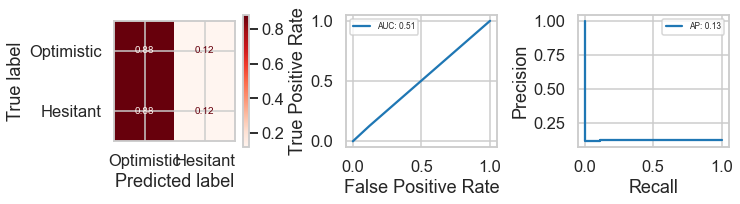

In [1459]:
# dummy classifier on non-SMOTEd data
dum = DummyClassifier(strategy='stratified')

dum.fit(X_train_df[v1_cols], y_train)

dstools.eval_clf_model(dum, X_test_df, y_test, X_train_df[v1_cols], y_train, 
               labels=labels)

Performs appropriately poorly. Let's try on the SMOTEd data as well.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.50      0.88      0.64     51283
         1.0       0.50      0.12      0.20     51283

    accuracy                           0.50    102566
   macro avg       0.50      0.50      0.42    102566
weighted avg       0.50      0.50      0.42    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88     17037
         1.0       0.12      0.11      0.12      2420

    accuracy                           0.79     19457
   macro avg       0.50      0.50      0.50     19457
weighted avg       0.78      0.79      0.78     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.4178
        Training Macro Recall = 0.5007
   Training Balanced Accuracy = 0.5007



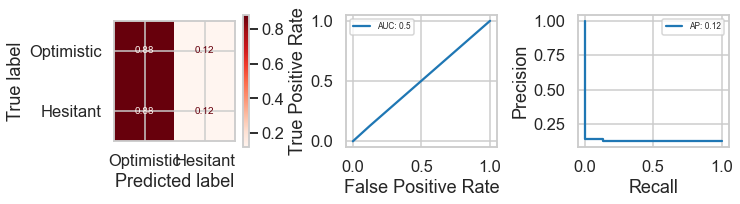

In [1460]:
dum_bal = DummyClassifier(strategy='stratified')

dum_bal.fit(X_train_sm[v1_cols], y_train_sm)

dstools.eval_clf_model(dum, X_test_df, y_test, X_train_sm[v1_cols], y_train_sm, 
               labels=labels)

Also performs quite poorly. Great, now I can start modeling for real!

## Initial Models
I'll start by creating initial vanilla models using both the SMOTEd data, and original unbalanced data with the `class_weight='balanced'` parameter.

I'll use the 'v1' columns, aka the columns most close to the original data. I think it makes sense to use these for my baseline, so I can perform feature selection and compare model performance with those features to the baselines.

This will serve two purposes: I want to get some baseline models to compare to later once I start tuning, and also see if I can suss out which class imbalance approach will be best for this data set.

### Logistic Regression

Here I create two different logistic regression models without regularization, testing whether letting sklearn address class imbalance or using SMOTEd data is a better result.

I initially used the default `lbfgs` solver and had to bump up the max iterations to 300 to get it to converge. When I tried to cross validate, the models failed to converge even with max iter of 500. I switched to `saga` solver, which worked better for this larger dataset.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51283
         1.0       0.27      0.75      0.39      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.61     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.74      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6073
        Training Macro Recall = 0.7323
   Training Balanced Accuracy = 0.7323



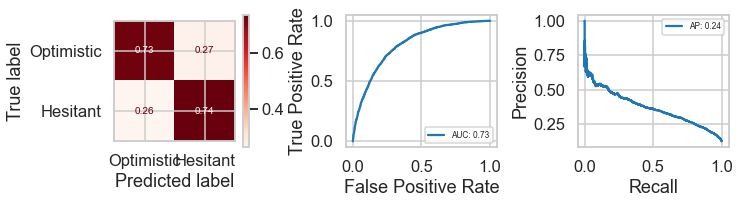

In [1461]:
# unSMOTEd data
lr_ub = LogisticRegression(C=1e12, class_weight='balanced', max_iter=500, 
                           solver='saga')

lr_ub.fit(X_train_df[v1_cols], y_train)

dstools.eval_clf_model(lr_ub, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74     51283
         1.0       0.74      0.76      0.75     51283

    accuracy                           0.75    102566
   macro avg       0.75      0.75      0.75    102566
weighted avg       0.75      0.75      0.75    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.73      0.83     17037
         1.0       0.27      0.69      0.39      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.71      0.61     19457
weighted avg       0.86      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.7453
        Training Macro Recall = 0.7454
   Training Balanced Accuracy = 0.7454



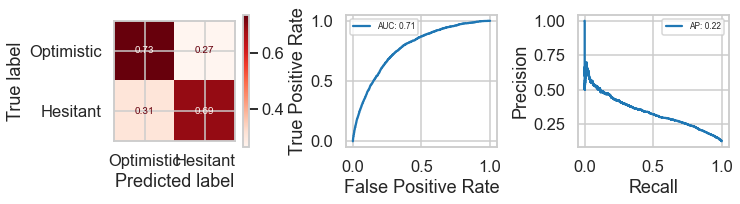

In [1462]:
# SMOTEd data
lr_sm = LogisticRegression(C=1e12, max_iter=500, solver='saga')

lr_sm.fit(X_train_sm[v1_cols], y_train_sm)

dstools.eval_clf_model(lr_sm, X_test_df[v1_cols], y_test, X_train_sm[v1_cols], 
               y_train_sm, labels=labels)

In [1463]:
# perform cross validation to get average scores
lr_ub_scores = cross_val_score(lr_ub, X_train_df[v1_cols], y_train, 
                               scoring='f1_macro', cv=5, n_jobs=-1)

lr_sm_scores = cross_val_score(lr_sm, X_train_sm[v1_cols], y_train_sm, 
                               scoring='f1_macro', cv=5, n_jobs=-1)
print('*** sklearn macro f1 ***')
print(lr_ub_scores)
print(lr_ub_scores.mean())
print()
print('*** SMOTE macro f1 ***')
print(lr_sm_scores)
print(lr_sm_scores.mean())

*** sklearn macro f1 ***
[0.59541909 0.60237545 0.61124799 0.60720976 0.6035011 ]
0.6039506779066629

*** SMOTE macro f1 ***
[0.70621408 0.75017478 0.75334281 0.74661744 0.75225136]
0.7417200936570019


The vanilla model run on SMOTEd data did quite a bit better in terms of macro F1 using cross validation on training data. 

However, with SMOTEd data there was a greater difference between F1 macro scores on train versus test. This looks like it's overfit. I'm concerned that by generating data using SMOTE, it has amplified noise in the training set that doesn't exist in the test set.

### Random Forests
Starting with `max_depth =10` because the default parameter of `None` still resulted in a very overfit model.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     51283
         1.0       0.32      0.79      0.46      7085

    accuracy                           0.77     58368
   macro avg       0.64      0.78      0.66     58368
weighted avg       0.89      0.77      0.81     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84     17037
         1.0       0.29      0.69      0.41      2420

    accuracy                           0.75     19457
   macro avg       0.62      0.72      0.63     19457
weighted avg       0.86      0.75      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6551
        Training Macro Recall = 0.7784
   Training Balanced Accuracy = 0.7784



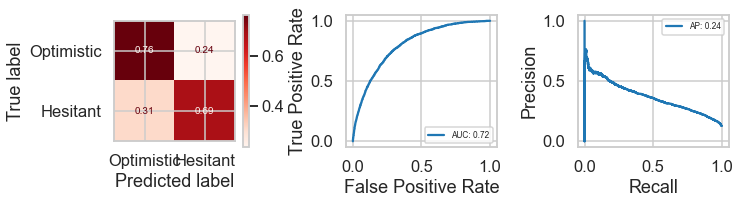

In [1464]:
# unSMOTEd data
rf_ub = RandomForestClassifier(class_weight='balanced', n_jobs=-1, 
                               max_depth=10)

rf_ub.fit(X_train_df[v1_cols], y_train)

dstools.eval_clf_model(rf_ub, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89     51283
         1.0       0.87      0.91      0.89     51283

    accuracy                           0.89    102566
   macro avg       0.89      0.89      0.89    102566
weighted avg       0.89      0.89      0.89    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     17037
         1.0       0.33      0.47      0.39      2420

    accuracy                           0.82     19457
   macro avg       0.63      0.67      0.64     19457
weighted avg       0.85      0.82      0.83     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.8915
        Training Macro Recall = 0.8915
   Training Balanced Accuracy = 0.8915



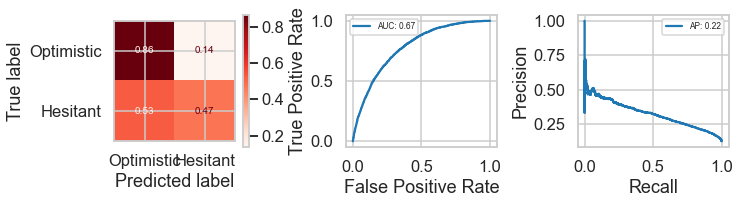

In [1465]:
# SMOTEd data
rf_sm = RandomForestClassifier(n_jobs=-1, max_depth=10)

rf_sm.fit(X_train_sm[v1_cols], y_train_sm)

dstools.eval_clf_model(rf_sm, X_test_df[v1_cols], y_test, X_train_sm[v1_cols], 
               y_train_sm, labels=labels)

In [1466]:
# cross validate
rf_ub_scores = cross_val_score(rf_ub, X_train_df[v1_cols], y_train, 
                               scoring='f1_macro', cv=5, n_jobs=-1)

rf_sm_scores = cross_val_score(rf_sm, X_train_sm[v1_cols], y_train_sm, 
                               scoring='f1_macro', cv=5, n_jobs=-1)
print('*** sklearn macro f1 ***')
print(rf_ub_scores)
print(rf_ub_scores.mean())
print()
print('*** SMOTE macro f1 ***')
print(rf_sm_scores)
print(rf_sm_scores.mean())

*** sklearn macro f1 ***
[0.60752231 0.61563641 0.62162022 0.62559749 0.61902865]
0.6178810154029126

*** SMOTE macro f1 ***
[0.72689128 0.91460209 0.91678938 0.91587565 0.91388697]
0.8776090748190419


Decision Trees are prone to overfitting but a using a Random Forest should help combat that, especially with a max_depth parameter of only 10 considering I have many features.

I see the same pattern here between SMOTEd and weighted balancing where although SMOTEd data performs higher on training F1 macro, it looks way overfit on test.

I'm going proceed with using the original data and asking sklearn to balance it for me.

## GridSearch for Best Params
Since I decided to go with original unbalanced data, I want to determine the best parameters for these models using v1 features before I proceed to reducing features.

In [1467]:
rerun_gridsearch = False

### Logistic Regression

Although I chose F1 macro as my primary statistic, recall would also be a good choice, since I definitely want my model to find as many of the Hesitant class as possible.

I did a grid search optimizing for both statistics, and compared, to see how different the 'best' parameters would be.

In [1468]:
# Logistic regression, optimized for f1_macro
lr = LogisticRegression(max_iter=600, class_weight='balanced')

param_grid = {
    'C':[0.01, 1, 100, 1e6],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

gs_lr = GridSearchCV(lr, param_grid, scoring='f1_macro', n_jobs=-1,  verbose=True)

if rerun_gridsearch:
    gs_lr.fit(X_train_df[v1_cols], y_train)

    print(gs_lr.best_estimator_)
    print(gs_lr.best_score_)

In [1469]:
# Logistic regression, optimized for recall_macro
lr = LogisticRegression(max_iter=600, class_weight='balanced')

param_grid = {
    'C':[0.01, 1, 100, 1e6],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

gs_lr = GridSearchCV(lr, param_grid, scoring='recall_macro', n_jobs=-1,  
                     verbose=True)

if rerun_gridsearch:
    gs_lr.fit(X_train_df[v1_cols], y_train)

    print(gs_lr.best_estimator_)
    print(gs_lr.best_score_)

**Best params for F1 macro**:
- LogisticRegression(C=1, class_weight='balanced', max_iter=600, penalty='l2', solver='saga')
- 0.6046278796323324

**Best params for recall macro**:
- LogisticRegression(C=1, class_weight='balanced', max_iter=600, penalty='l1', solver='liblinear')
- 0.7278955046732235

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51283
         1.0       0.27      0.74      0.39      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.61     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.74      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6069
        Training Macro Recall = 0.7318
   Training Balanced Accuracy = 0.7318



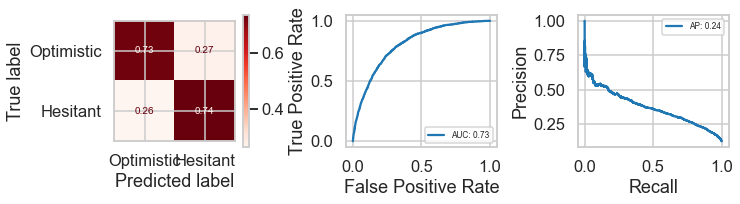

In [1470]:
# Check out results on test for recall optizmiation
lr = LogisticRegression(C=1, class_weight='balanced', max_iter=600, 
                        penalty='l1', solver='liblinear')
lr.fit(X_train_df[v1_cols], y_train)

dstools.eval_clf_model(lr, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51283
         1.0       0.27      0.75      0.39      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.61     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.74      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6073
        Training Macro Recall = 0.7324
   Training Balanced Accuracy = 0.7324



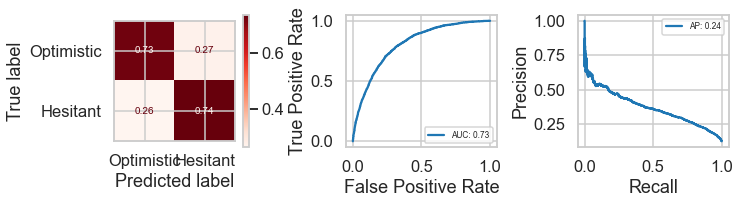

In [1471]:
# Check out results on test for F1 optizmiation
lr = LogisticRegression(C=1, class_weight='balanced', max_iter=600, 
                        penalty='l2', solver='saga')
lr.fit(X_train_df[v1_cols], y_train)

dstools.eval_clf_model(lr, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

These aren't much different, they're both pretty good, with very small differences between training and test.

I think F1 is a better balance, so I'm going to use those params.

### Random Forest

In [1472]:
# Random Forest, optimized for f1_macro
rf = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [5, 10, 30],
    'min_samples_split': [1, 5, 20],
    'min_impurity_decrease': [0, 0.01, 0.02],
    'max_features': [10, 20],
    'max_leaf_nodes': [6000, 2000, 500]
}

gs_rf = GridSearchCV(rf, param_grid, scoring='f1_macro', n_jobs=-1,  
                     verbose=True)

if rerun_gridsearch:
    gs_rf.fit(X_train_df[v1_cols], y_train)

    print(gs_rf.best_estimator_)
    print(gs_rf.best_score_)

**Best RandomForest params optimizing for F1_macro**:
- RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=30, max_features=10, max_leaf_nodes=2000,                 min_impurity_decrease=0, min_samples_split=20)
- 0.6557975680550348

This is pretty close to the F1 macro I got using only max_depth = 10.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95     51283
         1.0       0.58      0.88      0.70      7085

    accuracy                           0.91     58368
   macro avg       0.78      0.89      0.82     58368
weighted avg       0.93      0.91      0.92     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     17037
         1.0       0.37      0.49      0.42      2420

    accuracy                           0.83     19457
   macro avg       0.65      0.69      0.66     19457
weighted avg       0.86      0.83      0.84     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.8209
        Training Macro Recall = 0.8937
   Training Balanced Accuracy = 0.8937



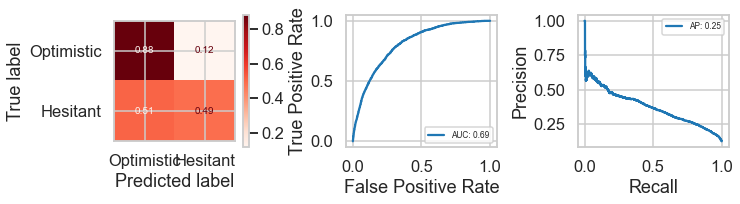

In [1473]:
# Review model performance for a model with these optimal params
rf = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                            max_depth=30, max_features=10, 
                            max_leaf_nodes=2000, min_samples_split=20)


rf.fit(X_train_df[v1_cols], y_train)

dstools.eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

Not great on test. Let's take out some of the params that were at the high end of my grid search; maybe they were the best just because they were highest, and higher would actually be better.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     51283
         1.0       1.00      1.00      1.00      7085

    accuracy                           1.00     58368
   macro avg       1.00      1.00      1.00     58368
weighted avg       1.00      1.00      1.00     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93     17037
         1.0       0.58      0.03      0.07      2420

    accuracy                           0.88     19457
   macro avg       0.73      0.52      0.50     19457
weighted avg       0.84      0.88      0.83     19457


****************************** Training Scores ******************************
            Training Macro F1 = 1.0
        Training Macro Recall = 1.0
   Training Balanced Accuracy = 1.0

*********

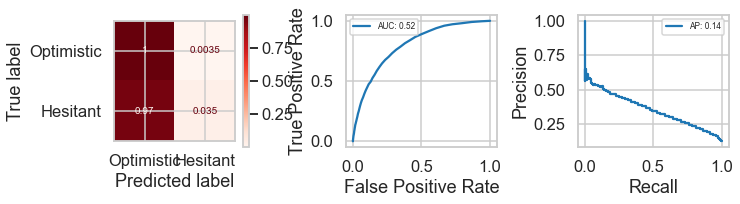

In [1474]:
# Review model performance for a model with optimal params that weren't the
# max in the grid search.
rf = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                            max_features=10)


rf.fit(X_train_df[v1_cols], y_train)

dstools.eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

Definitely not doing well on test still.

Maybe I'm overthinking it trying too many parameters in my grid search. I'll simplify it to just `criterion` and `max_depth`.

In [1475]:
# How about trying another grid search with just max_depth and criterion?
rf = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [5, 10, 30]
}

gs_rf = GridSearchCV(rf, param_grid, scoring='f1_macro', n_jobs=-1,  
                     verbose=True)

if rerun_gridsearch:
    gs_rf.fit(X_train_df[v1_cols], y_train)

    print(gs_rf.best_estimator_)
    print(gs_rf.best_score_)

This time I got:

- RandomForestClassifier(class_weight='balanced', max_depth=10)
- 0.624889713409605

Which is what I had tried before and did pretty well. I don't think trying to fine tune more parameters using grid search is helping.


## Feature Selection

I have some decent baseline models using the v1_cols that are closest to the originals.

Now I'll go through a feature selection process considering ALL the columns, to narrow down the feature space. This process should also help identify if any of the features I engineered might be useful to sub in for the originals.

In [1476]:
v1_v2_cols = list(set(v1_cols + v2_cols))

### Variance Threshold


In [1477]:
# I'm pretty sure from my EDA that I don't have any features with 0 variance
# so I'm going to start with a threshold of .95

# since most of my variables are OHE, I'll use the formula p(1-p) to generate
# the appropriate variace threshold 
# More here: (https://scikit-learn.org/stable/modules/feature_selection.html)
threshold = 0.99*(1-0.99)

sel = VarianceThreshold(threshold)
sel.fit(X_train_df[v1_v2_cols])

# Review columns to be removed
list(X_train_df[v1_v2_cols].loc[:, sel.get_support()==False].head().columns)

['MH_NOTGET_-1.0',
 'ANYWORK_-1.0',
 'LIVQTR_-1.0',
 'SSA_RECV_-1.0',
 'SNAP_YN_-1.0',
 'PLNDTRIPS_-1.0',
 'ANXIOUS_-1.0',
 'SSA_APPLY_-1.0',
 'EXPCTLOSS_-1.0',
 'FEWRTRANS_-1.0',
 'FEWRTRIPS_-1.0',
 'HLTHINS7_1.0',
 'FREEFOOD_-1.0',
 'CURFOODSUF_skipped_1.0',
 'EXPNS_DIF_skipped_1.0',
 'MS_-1.0',
 'INTEREST_-1.0',
 'LIVQTR_10.0',
 'EIP_-1.0',
 'WRKLOSS_-1.0',
 'DOWN_-1.0',
 'NOTGET_-1.0',
 'LIVQTR_2_4.0',
 'UI_APPLY_-1.0',
 'DELAY_-1.0',
 'HADCOVID_-1.0',
 'PRESCRIPT_-1.0',
 'skipped',
 'MH_SVCS_-1.0',
 'TENURE_-1.0',
 'WORRY_-1.0']

Almost all of these are skipped indicator columns for specific questions, which makes sense because those are sparsely populated. 

I'll come back to this if the other processes don't filter these features out using their methods.

### Univariate Feature Selection
There are 3 different algorithms to univariate feature selection methods that are suitable for classification problems. I decided to try each one out and give them an equal vote in terms of which features to keep.

For each algorithm, I asked for `k=50` features.

In [1478]:
# using mutual info
selk = SelectKBest(mutual_info_classif, k=50)
selk.fit(X_train_df[v1_v2_cols], y_train)

# Review features that it would keep
keep50_mutual = list(X_train_df[v1_v2_cols].loc[:, selk.get_support()]\
                     .head().columns)
keep50_mutual

['MS_2_2.0',
 'IN_METRO_AREA_1.0',
 'EEDUC',
 'HLTHINS3_1.0',
 'SNAP_YN_-1.0',
 'CHNGHOW1_1.0',
 'EXPCTLOSS_1.0',
 'ENROLL2_-1.0',
 'ANXIOUS_4.0',
 'EIP_4.0',
 'FREEFOOD_-1.0',
 'SPNDSRC1_1.0',
 'THHLD_NUMKID',
 'UI_APPLY_1.0',
 'HLTHINS1_1.0',
 'WRKLOSS_1.0',
 'CHNGHOW4_1.0',
 'polit_1',
 'LIVQTR_2_1.0',
 'FEWRTRIPS_1.0',
 'ANYWORK_1.0',
 'TW_START_1.0',
 'CHNGHOW6_1.0',
 'incomplete',
 'PROP_FOODSPEND_HOME',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'CHNGHOW8_1.0',
 'AGE',
 'LIVQTR_1.0',
 'DOWN_2.0',
 'NOTGET_-1.0',
 'SNAP_YN_1.0',
 'CHNGHOW12_1.0',
 'PLNDTRIPS_1.0',
 'ANXIOUS_2.0',
 'THHLD_NUMADLT_2.0',
 'DELAY_1.0',
 'ENROLL2_1.0',
 'CHNGHOW2_1.0',
 'INCOME',
 'FEWRTRANS_3.0',
 'SSA_RECV_1.0',
 'HLTHINS_1.0',
 'HADCOVID_1.0',
 'MS_2_3.0',
 'MS_5.0',
 'EXPNS_DIF',
 'ENROLL3_-1.0',
 'ENROLL1_1.0']

In [1479]:
# Using chi2
selk2 = SelectKBest(chi2, k=50)
selk2.fit(X_train_df[v1_v2_cols], y_train)

# Review features that it would keep
keep50_chi2 = list(X_train_df[v1_v2_cols].loc[:, selk2.get_support()]\
                   .head().columns)
keep50_chi2

['EIP_3.0',
 'HLTHINS8_-1.0',
 'HLTHINS4_-1.0',
 'IN_METRO_AREA_1.0',
 'RRACE_3.0',
 'EEDUC',
 'HLTHINS3_1.0',
 'CHNGHOW1_1.0',
 'EXPCTLOSS_1.0',
 'ENROLL2_-1.0',
 'HLTHINS7_-1.0',
 'DOWN_4.0',
 'SPNDSRC1_1.0',
 'THHLD_NUMKID',
 'UI_APPLY_1.0',
 'TENURE_3.0',
 'EST_MSA_41860.0',
 'WRKLOSS_1.0',
 'CHNGHOW4_1.0',
 'polit_1',
 'LIVQTR_2_1.0',
 'FEWRTRIPS_1.0',
 'HLTHINS4_1.0',
 'TW_START_1.0',
 'LIVQTR_10.0',
 'CHNGHOW6_1.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'RRACE_4.0',
 'AGE',
 'LIVQTR_1.0',
 'SCHOOL_KIDS_1.0',
 'SPNDSRC4_1.0',
 'LIVQTR_2_4.0',
 'SNAP_YN_1.0',
 'CHNGHOW12_1.0',
 'PLNDTRIPS_1.0',
 'HLTHINS5_-1.0',
 'ANXIOUS_2.0',
 'ENROLL2_1.0',
 'CHNGHOW2_1.0',
 'INCOME',
 'HLTHINS6_-1.0',
 'SSA_RECV_1.0',
 'HADCOVID_1.0',
 'MS_2_3.0',
 'MS_5.0',
 'EXPNS_DIF',
 'ENROLL3_-1.0',
 'ENROLL1_1.0']

In [1480]:
# Using f
selk3 = SelectKBest(f_classif, k=50)
selk3.fit(X_train_df[v1_v2_cols], y_train)

# Review features that it would keep
keep50_f = list(X_train_df[v1_v2_cols].loc[:, selk3.get_support()]\
                .head().columns)
keep50_f

['EIP_3.0',
 'WORRY_2.0',
 'HLTHINS4_-1.0',
 'IN_METRO_AREA_1.0',
 'RRACE_3.0',
 'EEDUC',
 'HLTHINS3_1.0',
 'CHNGHOW1_1.0',
 'EXPCTLOSS_1.0',
 'ENROLL2_-1.0',
 'EIP_4.0',
 'HLTHINS7_-1.0',
 'SPNDSRC1_1.0',
 'THHLD_NUMKID',
 'UI_APPLY_1.0',
 'TENURE_3.0',
 'HLTHINS1_1.0',
 'WRKLOSS_1.0',
 'CHNGHOW4_1.0',
 'polit_1',
 'LIVQTR_2_1.0',
 'FEWRTRIPS_1.0',
 'HLTHINS4_1.0',
 'TW_START_1.0',
 'CHNGHOW6_1.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'RRACE_4.0',
 'AGE',
 'LIVQTR_1.0',
 'SCHOOL_KIDS_1.0',
 'SPNDSRC4_1.0',
 'SNAP_YN_1.0',
 'CHNGHOW12_1.0',
 'PLNDTRIPS_1.0',
 'HLTHINS5_-1.0',
 'ANXIOUS_2.0',
 'ENROLL2_1.0',
 'CHNGHOW2_1.0',
 'INCOME',
 'FEWRTRANS_3.0',
 'HLTHINS6_-1.0',
 'SSA_RECV_1.0',
 'HLTHINS_1.0',
 'HADCOVID_1.0',
 'MS_2_3.0',
 'MS_5.0',
 'EXPNS_DIF',
 'ENROLL3_-1.0',
 'ENROLL1_1.0']

### Select From Model - Logit
When I ran logistic regression, it found that L2 was the best performing regularization technique with `saga` solver, but now I'll use L1 Lasso with a  to see how well it can reduce features for me.

I also tried this with a LinearSVC model, but even at 4000 max iterations, it failed to converge.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51283
         1.0       0.27      0.74      0.39      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.61     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.74      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6074
        Training Macro Recall = 0.7319
   Training Balanced Accuracy = 0.7319



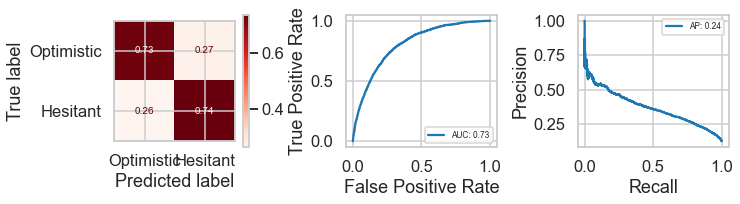

In [1481]:
# fitting on all columns, since will be using for feature selection
# Using best CV params optimizing for recall since it performed as well
# as f1 macro's best but using L1
lr = LogisticRegression(C=1, class_weight='balanced', max_iter=600, 
                        penalty='l1', solver='liblinear')
lr.fit(X_train_df[v1_v2_cols], y_train)

dstools.eval_clf_model(lr, X_test_df[v1_v2_cols], y_test, 
                       X_train_df[v1_v2_cols], y_train, labels=labels)

In [1482]:
model_sel = SelectFromModel(lr, prefit=True)
model_sel.get_support()

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [1483]:
# what would it get rid of?
keep_lr = list(X_train_df[v1_v2_cols].loc[:, model_sel.get_support()==False]\
               .head().columns)
keep_lr

['MS_4.0',
 'FEWRTRANS_-1.0',
 'WORRY_4.0',
 'LIVQTR_1.0',
 'MS_2.0',
 'skipped',
 'EST_MSA_35620.0',
 'LIVQTR_4.0']

### Select from Model - Forest

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     51283
         1.0       0.32      0.78      0.46      7085

    accuracy                           0.77     58368
   macro avg       0.64      0.78      0.66     58368
weighted avg       0.89      0.77      0.81     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84     17037
         1.0       0.29      0.68      0.41      2420

    accuracy                           0.75     19457
   macro avg       0.62      0.72      0.63     19457
weighted avg       0.86      0.75      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.657
        Training Macro Recall = 0.7784
   Training Balanced Accuracy = 0.7784

*

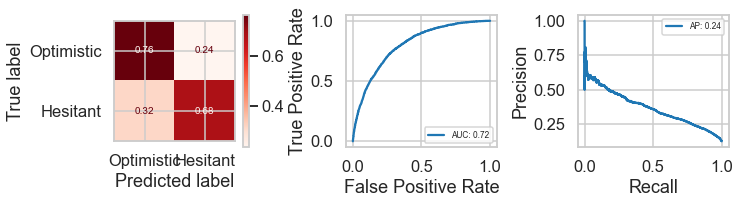

In [1484]:
# Using best minimal params from grid search
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')

rf.fit(X_train_df[v1_v2_cols], y_train)

dstools.eval_clf_model(rf, X_test_df[v1_v2_cols], y_test, 
               X_train_df[v1_v2_cols], y_train, labels=labels)

In [1485]:
model_sel_f = SelectFromModel(rf, prefit=True)
model_sel_f.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False,  True, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False,  True,  True, False, False, False,  True, False,
        True, False,  True,  True, False, False,  True, False,  True,
       False, False, False, False,  True, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,

In [1486]:
# what would it keep?
keep_tree = list(X_train_df[v1_v2_cols].loc[:, model_sel_f.get_support()]\
                 .head().columns)
keep_tree

['IN_METRO_AREA_1.0',
 'RRACE_3.0',
 'EEDUC',
 'HLTHINS3_1.0',
 'CHNGHOW1_1.0',
 'SPNDSRC1_1.0',
 'THHLD_NUMKID',
 'UI_APPLY_1.0',
 'HLTHINS1_1.0',
 'WRKLOSS_1.0',
 'CHNGHOW4_1.0',
 'polit_1',
 'FEWRTRIPS_1.0',
 'ANYWORK_1.0',
 'HLTHINS4_1.0',
 'TW_START_1.0',
 'CHNGHOW6_1.0',
 'PROP_FOODSPEND_HOME',
 'CURFOODSUF',
 'AGE',
 'SCHOOL_KIDS_1.0',
 'SNAP_YN_1.0',
 'CHNGHOW12_1.0',
 'PLNDTRIPS_1.0',
 'ANXIOUS_2.0',
 'CHNGHOW2_1.0',
 'INCOME',
 'FEWRTRANS_3.0',
 'skipped',
 'SSA_RECV_1.0',
 'HLTHINS_1.0',
 'HADCOVID_1.0',
 'EXPNS_DIF',
 'ENROLL3_-1.0',
 'ENROLL1_1.0']

### Combine Votes for Features
This looks pretty reasonable.

Let's compare features across the different feature selection methods and see which are most commonly kept.

In [1487]:
# create dataframe with selected features from each process
feat_dict = {
    'univ_mutual' : list(selk.get_support()),
    'univ_chi2' : list(selk2.get_support()),
    'univ_f' : list(selk3.get_support()),
    'model_lr' : list(model_sel.get_support()),
    'model_rf' : list(model_sel_f.get_support())
    }

feat_votes_ib = pd.DataFrame.from_dict(feat_dict, orient='index', 
                                    columns=v1_v2_cols)

# convert True to 1 and False to 0
# really useful: 
#https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
feat_votes_ib = feat_votes_ib*1


feat_votes_ib

,EIP_3.0,FREEFOOD_1.0,SPNDSRC7_1.0,TENURE_2.0,INCOME_skipped_1.0,MS_4.0,HLTHINS8_-1.0,MH_NOTGET_-1.0,WORRY_2.0,MS_2_2.0,...,LIVQTR_5.0,EXPNS_DIF,INTEREST_2.0,CHNGHOW10_1.0,EST_MSA_14460.0,MH_SVCS_1.0,WORRY_-1.0,ANXIOUS_3.0,ENROLL3_-1.0,ENROLL1_1.0
univ_mutual,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,1
univ_chi2,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1
univ_f,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
model_lr,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
model_rf,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1


In [1488]:
# sum votes for each column
votes_ib = feat_votes_ib.sum(axis=0)
sorted_votes_ib = votes_ib.sort_values(ascending=False)
print(list(sorted_votes_ib))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


It looks like there are a decent number of features that at least 2 of these feature selection methods voted for. I'm inclined to go with those, but let's take a look at what will be dropped if we exclude features that only 1 or no methods voted for.

In [1489]:
# What are the features that only 1 process voted for? 
# Are they all different processes?
feat_votes_ib[sorted_votes_ib.loc[sorted_votes_ib == 1].index].sum(axis=1)

univ_mutual     0
univ_chi2       0
univ_f          0
model_lr       91
model_rf        1
dtype: int64

So the logistic regression model was the main one that voted for features which no other process voted for.

This makes sense, since that model used L1 regularization to try to reduce feature coefficients to 0, and it may not have been able to do that for as many.

In [1490]:
# These columns would be kept
to_keep_ib = list(sorted_votes_ib.loc[sorted_votes_ib >= 2].index)
to_keep_ib.sort()

print(len(to_keep_ib))
to_keep_ib

67


['AGE',
 'ANXIOUS_2.0',
 'ANXIOUS_4.0',
 'ANYWORK_1.0',
 'CHNGHOW12_1.0',
 'CHNGHOW1_1.0',
 'CHNGHOW2_1.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_1.0',
 'CHNGHOW8_1.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'DELAY_1.0',
 'DOWN_2.0',
 'DOWN_4.0',
 'EEDUC',
 'EIP_3.0',
 'EIP_4.0',
 'ENROLL1_1.0',
 'ENROLL2_-1.0',
 'ENROLL2_1.0',
 'ENROLL3_-1.0',
 'EST_MSA_41860.0',
 'EXPCTLOSS_1.0',
 'EXPNS_DIF',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_1.0',
 'FREEFOOD_-1.0',
 'HADCOVID_1.0',
 'HLTHINS1_1.0',
 'HLTHINS3_1.0',
 'HLTHINS4_-1.0',
 'HLTHINS4_1.0',
 'HLTHINS5_-1.0',
 'HLTHINS6_-1.0',
 'HLTHINS7_-1.0',
 'HLTHINS8_-1.0',
 'HLTHINS_1.0',
 'INCOME',
 'IN_METRO_AREA_1.0',
 'LIVQTR_1.0',
 'LIVQTR_10.0',
 'LIVQTR_2_1.0',
 'LIVQTR_2_4.0',
 'MS_2_2.0',
 'MS_2_3.0',
 'MS_5.0',
 'NOTGET_-1.0',
 'PLNDTRIPS_1.0',
 'PROP_FOODSPEND_HOME',
 'RRACE_3.0',
 'RRACE_4.0',
 'SCHOOL_KIDS_1.0',
 'SNAP_YN_-1.0',
 'SNAP_YN_1.0',
 'SPNDSRC1_1.0',
 'SPNDSRC4_1.0',
 'SSA_RECV_1.0',
 'TENURE_3.0',
 'THHLD_NUMADLT_2.0',
 'THHLD_NUMKID',
 'TW_START

In [1491]:
# Mark direct selections in the feat_df

# update direct selections
df_feats.loc[df_feats.index.isin(to_keep_ib), 'selected'] = 'direct'

# add in family members
#selected_roots = df_feats.loc[df_feats['selected']=='direct', 'col_root']
#df_feats.loc[(df_feats['col_root'].isin(selected_roots)) & 
#             (df_feats['selected'].isna())
#             , 'selected'] = 'fam'

# This is the df filtered for only selected features
with pd.option_context('display.max_rows', 200):
    display(df_feats.loc[df_feats['selected'].isin(['direct'])])

,col_root,feat_group,selected
AGE,AGE,base,direct
ANXIOUS_2.0,ANXIOUS,base,direct
ANXIOUS_4.0,ANXIOUS,base,direct
ANYWORK_1.0,ANYWORK,base,direct
CHNGHOW12_1.0,CHNGHOW12,base,direct
CHNGHOW1_1.0,CHNGHOW1,base,direct
CHNGHOW2_1.0,CHNGHOW2,base,direct
CHNGHOW4_1.0,CHNGHOW4,base,direct
CHNGHOW6_1.0,CHNGHOW6,base,direct
CHNGHOW8_1.0,CHNGHOW8,base,direct


In [1492]:
# loop through v1 and v2 map and eliminate non-priority features so
# we don't have both
find = (df_feats['selected'].isin(['direct']))
updated_pairs = []

for pair in v1_v2_map:
    num_v1s = len(df_feats.loc[find & (df_feats['col_root'].isin(pair['v1']))])
    num_v2s = len(df_feats.loc[find & (df_feats['col_root'].isin(pair['v2']))])
    
    if num_v1s > 0 and num_v2s > 0:
        remove = 'v2' if pair['priority'] == 'v1' else 'v1'
        
        df_feats.loc[df_feats['col_root'].isin(pair[remove]), 
                     'selected'] = 'removed'
        updated_pairs = updated_pairs + pair['v1'] + pair['v2']

with pd.option_context('display.max_rows', 200):
    display(df_feats.loc[(df_feats['col_root'].isin(updated_pairs)) & 
                        (df_feats['selected'].isin(['direct', 'removed']))])      
    

,col_root,feat_group,selected
ENROLL1_-1.0,ENROLL1,v1,removed
ENROLL1_1.0,ENROLL1,v1,removed
ENROLL2_-1.0,ENROLL2,v1,removed
ENROLL2_1.0,ENROLL2,v1,removed
ENROLL3_-1.0,ENROLL3,v1,removed
ENROLL3_1.0,ENROLL3,v1,removed
EST_MSA_41860.0,EST_MSA,v1,direct
HLTHINS1_1.0,HLTHINS1,v1,direct
HLTHINS3_1.0,HLTHINS3,v1,direct
HLTHINS4_-1.0,HLTHINS4,v1,direct


Rather than bring in all labels of the category if any label was selected, I'm going to keep only the selected labels for modeling purposes.

In [1493]:
# get final list of features to keep
final_keep = list(df_feats.loc[df_feats['selected']=='direct'].index)
print(len(final_keep))
final_keep

57


['AGE',
 'ANXIOUS_2.0',
 'ANXIOUS_4.0',
 'ANYWORK_1.0',
 'CHNGHOW12_1.0',
 'CHNGHOW1_1.0',
 'CHNGHOW2_1.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_1.0',
 'CHNGHOW8_1.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'DELAY_1.0',
 'DOWN_2.0',
 'DOWN_4.0',
 'EEDUC',
 'EIP_3.0',
 'EIP_4.0',
 'EST_MSA_41860.0',
 'EXPCTLOSS_1.0',
 'EXPNS_DIF',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_1.0',
 'FREEFOOD_-1.0',
 'HADCOVID_1.0',
 'HLTHINS1_1.0',
 'HLTHINS3_1.0',
 'HLTHINS4_-1.0',
 'HLTHINS4_1.0',
 'HLTHINS5_-1.0',
 'HLTHINS6_-1.0',
 'HLTHINS7_-1.0',
 'HLTHINS8_-1.0',
 'INCOME',
 'LIVQTR_1.0',
 'LIVQTR_10.0',
 'MS_5.0',
 'NOTGET_-1.0',
 'PLNDTRIPS_1.0',
 'PROP_FOODSPEND_HOME',
 'RRACE_3.0',
 'RRACE_4.0',
 'SCHOOL_KIDS_1.0',
 'SNAP_YN_-1.0',
 'SNAP_YN_1.0',
 'SPNDSRC1_1.0',
 'SPNDSRC4_1.0',
 'SSA_RECV_1.0',
 'TENURE_3.0',
 'THHLD_NUMADLT_2.0',
 'THHLD_NUMKID',
 'TW_START_1.0',
 'UI_APPLY_1.0',
 'WORRY_2.0',
 'WRKLOSS_1.0',
 'incomplete',
 'polit_1']

## Modeling in Reduced Feature Space

### Logistic Regression

In [1494]:
param_grid = {
    'C':[0.01, 1, 100, 1e6],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

gs_lr = GridSearchCV(lr, param_grid, scoring='f1_macro', n_jobs=-1,  
                     verbose=True)

if rerun_gridsearch:
    gs_lr.fit(X_train_df[final_keep], y_train)

    print(gs_lr.best_estimator_)
    print(gs_lr.best_score_)

**Best LR params on reduced features**:
- LogisticRegression(C=100, class_weight='balanced')
    - default solver lbfgs and penalty l2 are implied, since they're defaults
- mean F1 macro: 0.60

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.71      0.82     51283
         1.0       0.26      0.73      0.39      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.72      0.60     58368
weighted avg       0.87      0.72      0.76     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.73      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6007
        Training Macro Recall = 0.7242
   Training Balanced Accuracy = 0.7242



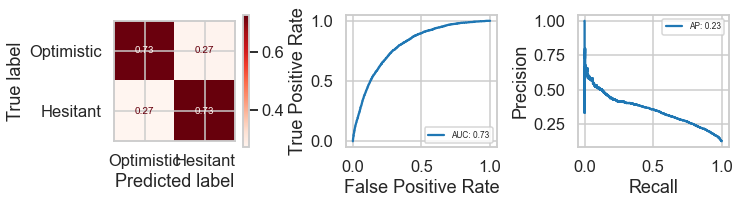

In [1496]:
# Logistic Regression with reduced features, optimal params from grid search
lr = LogisticRegression(C=100, class_weight='balanced', max_iter=600, 
                        solver='lbfgs', penalty='l2')

lr.fit(X_train_df[final_keep], y_train)

dstools.eval_clf_model(lr, X_test_df[final_keep], y_test, X_train_df[final_keep], 
               y_train, labels=labels)

Not much different from the original model on V1 features that didn't use regularization. So removing the features that the selection process voted were not important hasn't had much effect on Logistic Regression accuracy or F1.

This is OK; it just means I have simplified my model somewhat and honed in on the features that actually do help predictions. I don't think I can go any further with Logistic Regression; let's see how a Random Forest does on the adjusted feature space.

### Random Forest

In [1497]:
# grid search with just max_depth and criterion
rf = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [5, 10, 30]
}

gs_rf = GridSearchCV(rf, param_grid, scoring='f1_macro', n_jobs=-1,  
                     verbose=True)

if rerun_gridsearch:
    gs_rf.fit(X_train_df[final_keep], y_train)

    print(gs_rf.best_estimator_)
    print(gs_rf.best_score_)

These are the same best params from the previous gridsearch with v1 cols.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     51283
         1.0       0.32      0.78      0.46      7085

    accuracy                           0.78     58368
   macro avg       0.64      0.78      0.66     58368
weighted avg       0.89      0.78      0.81     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85     17037
         1.0       0.29      0.67      0.41      2420

    accuracy                           0.76     19457
   macro avg       0.62      0.72      0.63     19457
weighted avg       0.86      0.76      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6587
        Training Macro Recall = 0.7795
   Training Balanced Accuracy = 0.7795



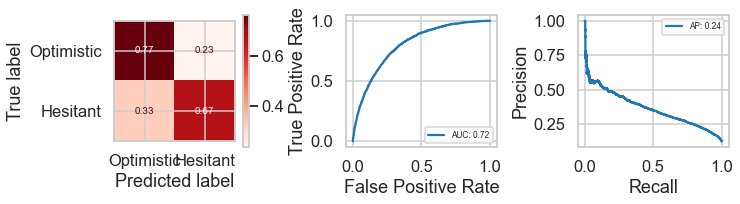

In [1498]:
# Random Forest with reduced features, optimal params from grid search
rf = RandomForestClassifier(class_weight='balanced', max_depth=10)

rf.fit(X_train_df[final_keep], y_train)

dstools.eval_clf_model(rf, X_test_df[final_keep], y_test, X_train_df[final_keep], 
               y_train, labels=labels)

Random Forest on the reduced features with best params from gridsearch yields f1 macro and accuracy, and performance on test data very similar to what I saw in my initial model on v1 cols.

I don't think I can tune further to get better performance, but the reduced features seem to provide just as accurate a result.

In [1499]:
# Saving final models out
joblib.dump(lr, 'final_lr_model.joblib') 
joblib.dump(rf, 'final_rf_model.joblib') 

['final_rf_model.joblib']

# iNTERPRET
I used the coefficients from the logistic regression model, since they allowed me to determine interpretable odds for predictors of both hesitancy and optimisim.

I did also initially review the feature importances and permutation importances from the random forest model. However, only some of these agreed with each other, and with the logistic regression coefficients. 

I reviewed which coefficients 2 out of 3 methods agreed on being in the top 30, and considered dropping those logistic regression coefficients that the random forest model didn't agree were as important. However, the random forest model's importances did not seem especially stable, and only `AGE` and `EEDUC` stood out from others, which were both predictors of optimism according to logistic regression. I ultimately decided to make my conclusions and recommendations based solely on the logistic regression coefficients, because I think this model type is less prone to making somewhat arbitrary decisions based on randomness, and performed the most consistently throughout the modeling process.

See the Extra section at the end of this notebook for the random forest importance work.

In [1500]:
# Load in models, if needed
#lr = joblib.load('final_lr_model.joblib')
#rf = joblib.load('final_rf_model.joblib')

## Logistic Regression Coefficients

In [1501]:
# convert logit coeffients from log odds to odds ratios
lr_odds = np.exp(lr.coef_[0])
lr_odds_s = pd.Series(lr_odds, index=final_keep, )
lr_odds_s.sort_values(ascending=False)[:10]

LIVQTR_10.0      2.450732
THHLD_NUMKID     2.411927
EXPNS_DIF        2.339470
CURFOODSUF       1.752039
LIVQTR_1.0       1.672512
FREEFOOD_-1.0    1.662378
FEWRTRANS_3.0    1.436470
RRACE_4.0        1.386821
HADCOVID_1.0     1.337070
polit_1          1.282261
dtype: float64

In [1502]:
# Odds greater than 1. Higher values represent greater odds of being vaccine
# hesitant, my target class of 1
np.round(lr_odds_s.loc[lr_odds_s >= 1]\
         .sort_values(ascending=False).head(10),2)

LIVQTR_10.0      2.45
THHLD_NUMKID     2.41
EXPNS_DIF        2.34
CURFOODSUF       1.75
LIVQTR_1.0       1.67
FREEFOOD_-1.0    1.66
FEWRTRANS_3.0    1.44
RRACE_4.0        1.39
HADCOVID_1.0     1.34
polit_1          1.28
dtype: float64

The top predictors of vaccine hesitancy increased odds over 50% are:

| Model Column Name | Description of Question | Odds of Hesitancy |
|:-|:-|:-|
| LIVQTR_10.0 | Household residence is a boat, RV, or van | 2.48 |
| THHLD_NUMKID | Number of individuals under 18 in the household | 2.29 |
| EXPNS_DIF | Level of difficulty meeting household expenses in the past 7 days | 2.24 |
| CURFOODSUF | Level of household food insufficiency in the past 7 days | 1.80 |
| LIVQTR_1.0 | Household residence is a mobile home | 1.73 |
| FEWRTRANS_3.0 | Respondent did not use public transportation such as bus, rail, or ride-share before the pandemic, so transportation did not change | 1.51 |


In [1503]:
# Odds less than 1. All odds here are related to being in the target class,
# so odds less than 1 are more likely to be in the 0 class.

# Using 1 / odds to convert to odds that respondent is in 0 class, or
# vaccine optimistic
np.round(1 / (lr_odds_s.loc[lr_odds_s < 1])\
         .sort_values(ascending=True).head(10), 2)

AGE                6.42
EEDUC              2.64
RRACE_3.0          2.22
EST_MSA_41860.0    2.15
CHNGHOW6_1.0       2.07
FEWRTRIPS_1.0      1.91
INCOME             1.79
incomplete         1.73
NOTGET_-1.0        1.49
TW_START_1.0       1.48
dtype: float64

The predictors of vaccine optimism with increased odds over 50% are:
    
| Model Column Name | Description of Question | Odds of Optimism |
|:-|:-|:-|
| AGE | Respondent's age in years | 6.06 |
| EEDUC | Level of education | 2.62 |
| RRACE_3.0 | Respondent identified as Asian | 2.22 |
| EST_MSA_41860.0 | Household is in the San Francisco-Oakland-Berkeley, CA Metro Area | 2.18 |
| CHNGHOW6_1.0 | Members of the household had avoided eating at restaurants in the prior 7 days | 2.03 |
| INCOME | Pre-tax income level | 1.89 |
| FEWRTRIPS_1.0 | Members of the household had taken fewer trips to stores because of the pandemic in the prior 7 days | 1.88 |
| TW_START_1.0 | At least one adult in the household substituted some or all of their typical in-person work for telework | 1.51 |

Since the household being in San Francisco isn't very applicable to the rest of the country, I'm going to leave it out of my recommendations.

# Interpretation Visualizations

In [1504]:
# Why Not reason columns and column mapping

hes_reason_cols = ['WHYNOT1', 'WHYNOT2', 'WHYNOT3', 'WHYNOT4', 'WHYNOT5', 
                   'WHYNOT6', 'WHYNOT7', 'WHYNOT8', 'WHYNOT9', 'WHYNOT10',
                   'WHYNOT11']

hes_reasonb_cols = ['WHYNOTB1', 'WHYNOTB2', 'WHYNOTB3', 'WHYNOTB4', 'WHYNOTB5',
                   'WHYNOTB6']

reasons_map = {
'WHYNOT1' : "Concerned about side effects",
'WHYNOT2' : "Don't know if it will work",
'WHYNOT3' : "Don't believe I need it",
'WHYNOT4' : "Don't like vaccines",
'WHYNOT5' : "Doctor has not recommended it",
'WHYNOT6' : "Plan to wait and see if it is safe -- may get it later",
'WHYNOT7' : "Other people need it more than I do right now",
'WHYNOT8' : "Concerned about the cost",
'WHYNOT9' : "Don't trust these vaccines",
'WHYNOT10' : "Don't trust the government",
'WHYNOT11' : "Other",
'WHYNOTB1' : "Already had COVID",
'WHYNOTB2' : "Not in a high risk group",
'WHYNOTB3' : "Plan to use masks and other precautions instead",
'WHYNOTB4' : "Don't believe COVID is a serious illness",
'WHYNOTB5' : "Don't think vaccines are beneficial",
'WHYNOTB6' : "Other"
}

In [1505]:
# create separate hesitant and optimistic columns for easy grouping
df.loc[df['target']==1, 'Hesitant'] = 1
df.loc[df['target']==0, 'Optimistic']= 1

df.loc[df['target']==1, 'target_str'] = 'Hesitant'
df.loc[df['target']==0, 'target_str']= 'Optimistic'


In [1506]:
# make initial df of hesitant respondents
hes_df = df.loc[(df['target']==1)].copy()

# remove the -88 and -99 values to leave only the responses
for col in hes_reason_cols + hes_reasonb_cols:
    hes_df.loc[hes_df[col].isin([-88, -99]), col] = np.nan

# drop rows where no why questions were answered
hes_df.dropna(axis=0, how='all', subset=hes_reason_cols + hes_reasonb_cols,
             inplace=True)
hes_df[hes_reason_cols + hes_reasonb_cols]

,WHYNOT1,WHYNOT2,WHYNOT3,WHYNOT4,WHYNOT5,WHYNOT6,WHYNOT7,WHYNOT8,WHYNOT9,WHYNOT10,WHYNOT11,WHYNOTB1,WHYNOTB2,WHYNOTB3,WHYNOTB4,WHYNOTB5,WHYNOTB6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
24,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77767,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77786,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77788,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
77812,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1507]:
def percent_cattarget_per_catpred(df, pred_col, 
                                  target_cols=['Hesitant', 'Optimistic']):
    """Creates a dataframe suitable for plotting the proportion of each
    label in a categorical predictor that falls into each target class.
    
    ***
    Args:
    
    df: type = Dataframe 
        Dataframe passed should include `pred_col` and `target_cols`. Any
        other columns will be ignored.
        Note that while for modeling target is typically represented in a
        single column, for this function each target class should be dummied
        into its own column, so that the number of observations in each class
        can be easily aggregated using the count() function.
        
    pred_col: type = string
        Column name of the categorical predictor in `df`.
        
    target_cols: type: list
        List of dummied target column names where each column represents a 
        target class.
        
    ***
    Returns a dataframe where each row represents the proportion of 
    observations grouped by `pred_col` and `target_cols`. Such a dataframe
    may be easily turned into a Seaborn bar graph that shows how the 
    proportion oftarget class changes for each categorical predictor label, 
    using `x="pred_col", y="percent", hue="target", data=df`.
    
    
    `pred_col`: using the original predictor column name
        Populated with the predictor labels.
        
    `target`:
        Populated with target classes taken from the dummied column names.
        
    `percent`:
        Proportion of observations that fell into predictor and target class
        represented by that row.
    """
    
    # get total count for each category of the predictor
    totals = df[pred_col].value_counts()
    
    # group by predictor and populate a column per target category with the
    # percentage of target cat in that pred category
    per = df.groupby(pred_col)[target_cols].count()\
     .apply(lambda x: x / totals.loc[x.name], axis=1)

    per.reset_index(inplace=True)
    
    melted = pd.melt(per, id_vars=pred_col, var_name="target", 
                     value_name="percent")
    return melted


In [1508]:
def top_n_whys_perpred(filt_df, pred_col, pred_vals, top_n=5, 
                       why_cols=hes_reason_cols,
                       mapper=reasons_map):
    
    # get total count of respondents in the filtered df, per pred
    # to use as percentage denominator
    if pred_col == None:
        total = len(filt_df)
    else:
        totals = filt_df[pred_col].value_counts()
    
    # get a list of the top n reasons people who belonged to pred_vals group
    # selected why they were hesitant
    if pred_vals == None:
        top_5_whys = list(filt_df[why_cols].sum()\
                          .sort_values(ascending=False)[:top_n].index)
    else:
        top_5_whys = list(filt_df.loc[filt_df[pred_col].isin(pred_vals), 
                    why_cols].sum().sort_values(ascending=False)[:top_n].index)
                      
    # group by predictor and populate a column per why reason with
    # percentage respondents who selected that reason
    # note that the reasons were multi-select, so respondents may have selected
    # more than one and they will probably not add to 100
    # also we are only choosing the top n most poplar out of 11 based on
    # most popular across all filtered pred values
    if pred_col == None:
        final = pd.DataFrame(filt_df[top_5_whys].count()\
                             .apply(lambda x: x / total), columns=['percent'])
        final.reset_index(inplace=True)
        
        final.rename(columns={'index':'target'}, inplace=True)
        
        # map reasons to column names
        final['target'].replace(mapper, inplace=True)

        
    else:
        filt_df = filt_df.groupby(pred_col)[top_5_whys].count()\
                   .apply(lambda x: x / totals.loc[x.name], axis=1)

        filt_df.reset_index(inplace=True)
    
        # map reasons to column names
        filt_df.rename(mapper=mapper, axis=1, inplace=True)

        final = pd.melt(filt_df, id_vars=pred_col, var_name="target", 
                         value_name="percent")
        
    return final


In [1509]:
colors = sns.color_palette(['#4285f4', '#34a853'])
sns.set_style("whitegrid")
sns.set_context('talk')

## Reasons for Hesitancy

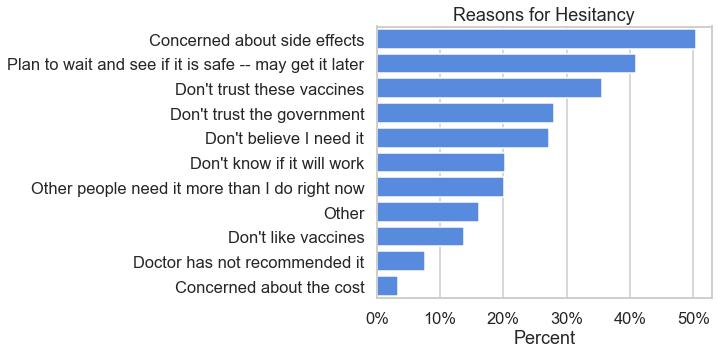

In [1510]:
# Plot reasons for hesitancy reported in descending order based on 
# percentage
pred = None
pred_pretty = 'Reasons for Hesitancy'

to_plot = top_n_whys_perpred(hes_df, pred, None, top_n=11)

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(y='target', x="percent", data=to_plot, ax=ax, orient='h', 
            color='#4285f4')


ax.set_title(f'Reasons for Hesitancy')
ax.set_xlabel('Percent')
ax.set_ylabel(None)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

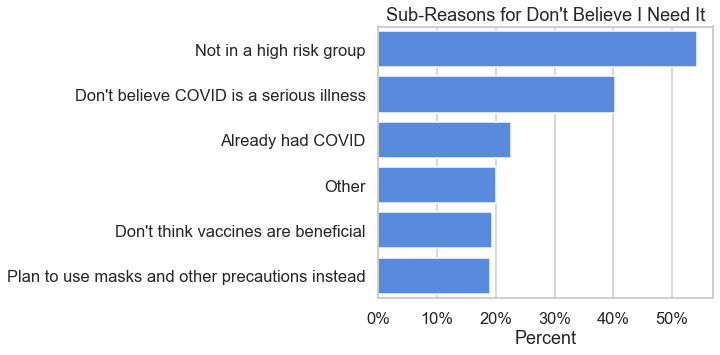

In [1511]:
# Plot subreasons for not beleiving they need it
pred = None
pred_pretty = 'Reasons for Hesitancy'

# get df filtered by people who were shown the subreasons because they said
# they didn't beleive they needed it

to_plot = top_n_whys_perpred(hes_df.loc[hes_df['WHYNOT3']==1], pred, None, 
                             why_cols=hes_reasonb_cols, top_n=6)

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(y='target', x="percent", data=to_plot, ax=ax, orient='h', 
            color='#4285f4')


ax.set_title(f"Sub-Reasons for Don't Believe I Need It")
ax.set_xlabel('Percent')
ax.set_ylabel(None)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

In [1512]:
# how many people chose both 'concerned about side effects' and 'wait and see'
# versus just one or the other?

# side effects only
only_side_effects = len(hes_df.loc[(hes_df['WHYNOT1']==1) & (hes_df['WHYNOT6'].isna())])
only_waitsee = len(hes_df.loc[(hes_df['WHYNOT6']==1) & (hes_df['WHYNOT1'].isna())])
both_effects_waitsee = len(hes_df.loc[(hes_df['WHYNOT6']==1) & (hes_df['WHYNOT1']==1)])
one_or_other = len(hes_df.loc[(hes_df['WHYNOT6']==1) | (hes_df['WHYNOT1']==1)])

print(f"Concerned about side effects only: {only_side_effects/one_or_other}")
print(f"Plan to wait and see only: {only_waitsee/one_or_other}")
print(f"Concerned about side effects AND will wait and see: {both_effects_waitsee/one_or_other}")

Concerned about side effects only: 0.3808158062460166
Plan to wait and see only: 0.23932441045251754
Concerned about side effects AND will wait and see: 0.3798597833014659


## Hesitancy - Type of Housing

In [1513]:
# mapper for LIVQTR_2
livqtr_map = {
    1.0:"Mobile home",
    2.0:"House",
    3.0:"Apartment",
    4.0:"Boat, RV,\nvan, etc."
}

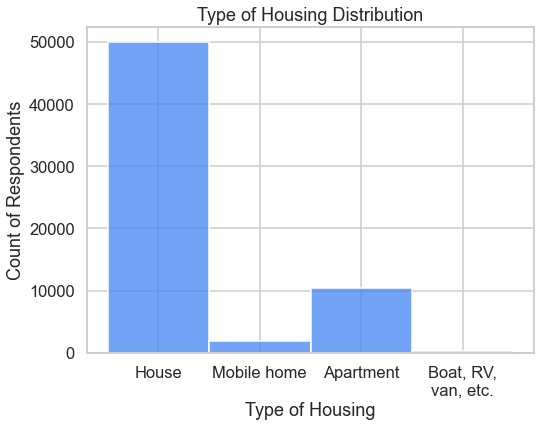

In [1514]:
# visualize distribution of people in each housing category

pred = 'LIVQTR_2'
pred_pretty = 'Type of Housing'

filter_df = df.loc[df[pred] > 0].copy()

# map placholder values to text
filter_df[pred].replace(livqtr_map, inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(x=filter_df[pred], color='#4285f4')

ax.set_title(f'{pred_pretty} Distribution')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Count of Respondents');


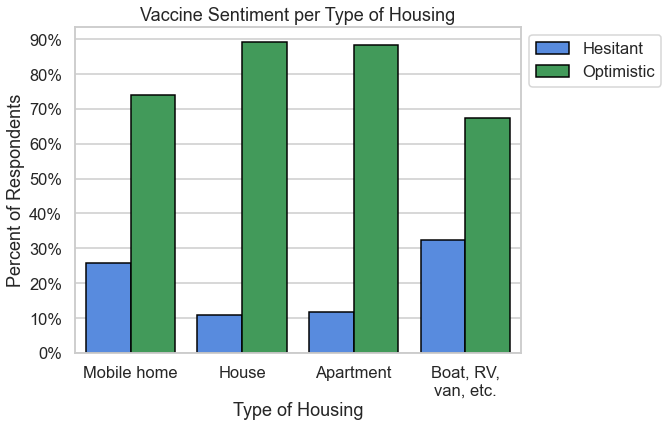

In [1515]:
# Plot sentiment for number of Housing Type

filter_df = df.loc[df[pred] > 0]
to_plot = percent_cattarget_per_catpred(filter_df, pred)

# map placholder values to text
to_plot[pred].replace(livqtr_map, inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=pred, y="percent", hue="target",\
                data=to_plot, palette=colors, ax=ax, edgecolor='black')


ax.set_title(f'Vaccine Sentiment per {pred_pretty}')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Percent of Respondents')
ax.legend(title=None, bbox_to_anchor=(1, 1), loc='upper left')
#ax.tick_params(axis='x', labelrotation = 45)
ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

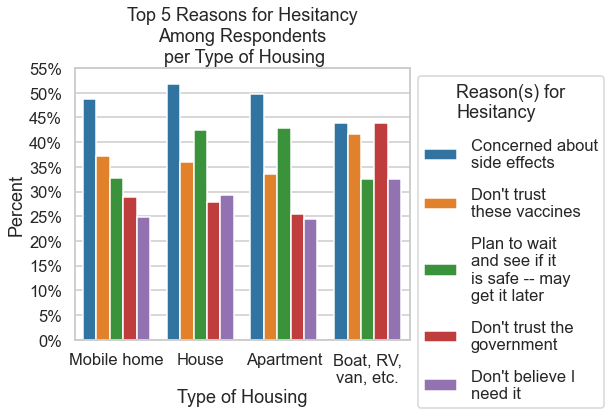

In [1516]:
# plot top 5 reasons respondents said why they didn't plan to get vaccinated
filt_df = hes_df.loc[hes_df[pred] > 0, [pred] + hes_reason_cols]

to_plot = top_n_whys_perpred(filt_df, pred, [1.0, 4.0])
# map placholder values to text
to_plot[pred].replace(livqtr_map, inplace=True)

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x=pred, y="percent", hue="target",\
                data=to_plot, ax=ax, orient='v')

# nifty wrap labels code from:
#https://stackoverflow.com/questions/47057789/matplotlib-wrap-text-in-legend
handles, labels = ax.get_legend_handles_labels()
labels = ['\n'.join(wrap(l, 15)) for l in labels]

ax.set_title(f'Top 5 Reasons for Hesitancy\nAmong Respondents\n per Type of Housing')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Percent')
ax.legend(handles=handles, labels=labels, title="Reason(s) for\nHesitancy", labelspacing=1,
          bbox_to_anchor=(1, 1), loc='upper left')
ax.yaxis.set_ticks(np.arange(0, 0.6, 0.05))

#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("#%d"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

## Hesitancy - Number of Children

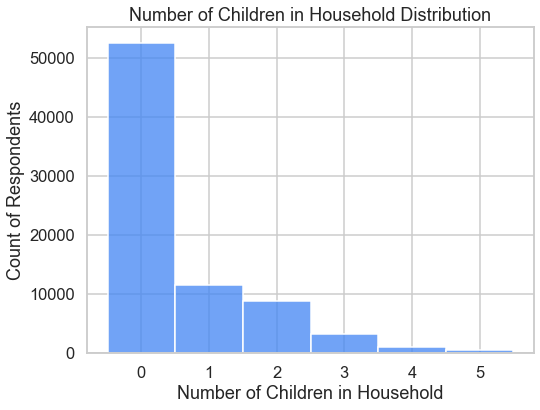

In [1517]:
# visualize distribution of number of children

pred = 'THHLD_NUMKID'
pred_pretty = 'Number of Children in Household'

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(x=df[pred], color='#4285f4', discrete=True)

ax.set_title(f'{pred_pretty} Distribution')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Count of Respondents');

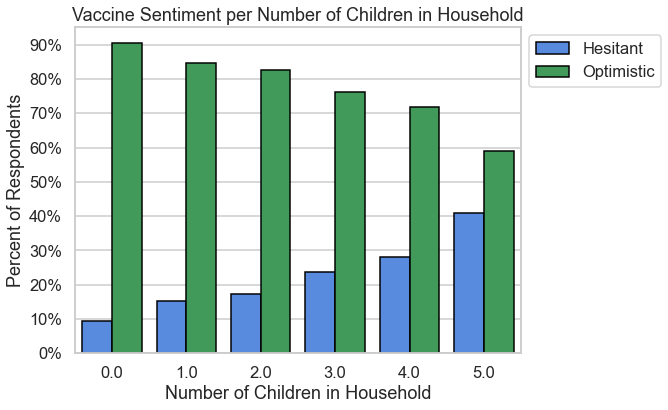

In [1518]:
# Plot sentiment for number of children in the household

to_plot = percent_cattarget_per_catpred(df, pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=pred, y="percent", hue="target",\
                data=to_plot, palette=colors, ax=ax, edgecolor='black')
ax.set_title(f'Vaccine Sentiment per {pred_pretty}')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Percent of Respondents')
ax.legend(title=None, bbox_to_anchor=(1, 1), loc='upper left')
ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

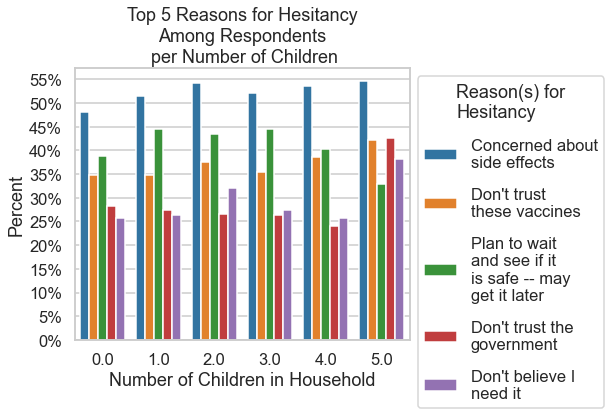

In [1519]:
# plot top 5 reasons respondents said why they didn't plan to get vaccinated
#filt_df = hes_df.loc[hes_df[pred] > 0, [pred] + hes_reason_cols]

to_plot = top_n_whys_perpred(hes_df, pred, [4.0, 5.0])

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x=pred, y="percent", hue="target",\
                data=to_plot, ax=ax, orient='v')

# nifty wrap labels code from:
#https://stackoverflow.com/questions/47057789/matplotlib-wrap-text-in-legend
handles, labels = ax.get_legend_handles_labels()
labels = ['\n'.join(wrap(l, 15)) for l in labels]

ax.set_title(f'Top 5 Reasons for Hesitancy\nAmong Respondents\n per Number of Children')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Percent')
ax.legend(handles=handles, labels=labels, title="Reason(s) for\nHesitancy", labelspacing=1,
          bbox_to_anchor=(1, 1), loc='upper left')
ax.yaxis.set_ticks(np.arange(0, 0.6, 0.05))

#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("#%d"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

## Hesitancy - Difficulty Meeting Household Expenses

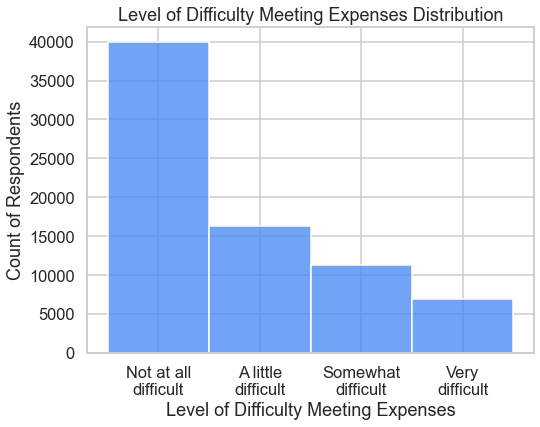

In [1520]:
# visualize distribution of expense difficulty

# mapper for EXPNS_DIF
expns_map = {
    1.0:"Not at all\ndifficult",
    2.0:"A little\ndifficult",
    3.0:"Somewhat\ndifficult",
    4.0:"Very\ndifficult"
}

pred = 'EXPNS_DIF'
pred_pretty = 'Level of Difficulty Meeting Expenses'

filter_df = df.loc[df[pred]>0, pred].copy()
filter_df.replace(expns_map, inplace=True)
filter_df = filter_df.astype('category')
filter_df.cat.set_categories(list(expns_map.values()), ordered=True, 
                             inplace=True)


fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(x=filter_df, color='#4285f4', discrete=True)

ax.set_title(f'{pred_pretty} Distribution')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Count of Respondents');

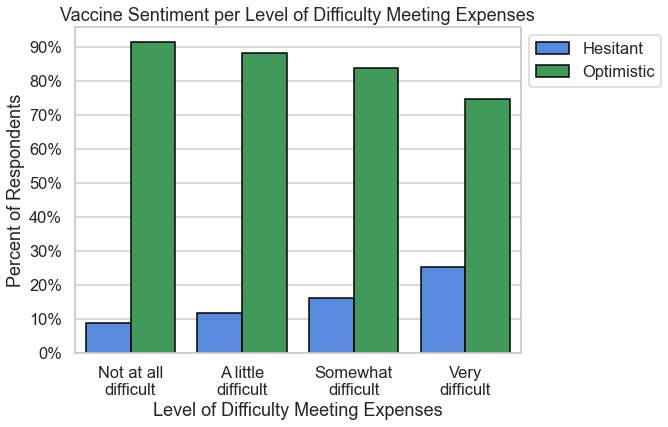

In [1521]:
# Plot sentiment for difficulty meeting expenses


filter_df = df.loc[df[pred] > 0]
to_plot = percent_cattarget_per_catpred(filter_df, pred)

# map placholder values to text
to_plot[pred].replace(expns_map, inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=pred, y="percent", hue="target",\
                data=to_plot, palette=colors, ax=ax, edgecolor='black')


ax.set_title(f'Vaccine Sentiment per {pred_pretty}')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Percent of Respondents')
ax.legend(title=None, bbox_to_anchor=(1, 1), loc='upper left')
#ax.tick_params(axis='x', labelrotation = 45)
ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

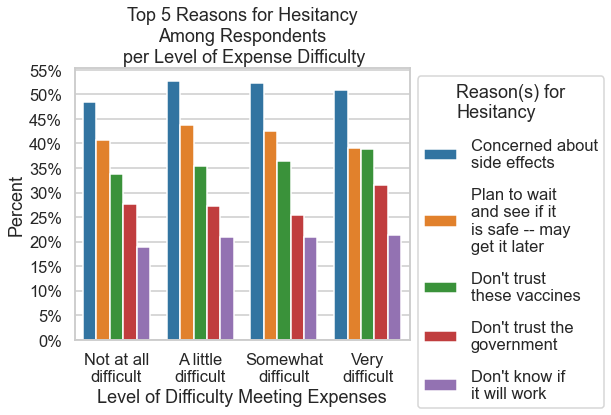

In [1522]:
# plot top 5 reasons respondents said why they didn't plan to get vaccinated
filt_df = hes_df.loc[hes_df[pred] > 0, [pred] + hes_reason_cols]

to_plot = top_n_whys_perpred(filt_df, pred, [4.0])
# map placholder values to text
to_plot[pred].replace(expns_map, inplace=True)

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x=pred, y="percent", hue="target",\
                data=to_plot, ax=ax, orient='v')

# nifty wrap labels code from:
#https://stackoverflow.com/questions/47057789/matplotlib-wrap-text-in-legend
handles, labels = ax.get_legend_handles_labels()
labels = ['\n'.join(wrap(l, 15)) for l in labels]

ax.set_title(f'Top 5 Reasons for Hesitancy\nAmong Respondents\n per Level of Expense Difficulty')
ax.set_xlabel(pred_pretty)
ax.set_ylabel('Percent')
ax.legend(handles=handles, labels=labels, title="Reason(s) for\nHesitancy", 
          labelspacing=1,
          bbox_to_anchor=(1, 1), loc='upper left')
ax.yaxis.set_ticks(np.arange(0, 0.6, 0.05))

#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("#%d"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

## Hesitancy - Food Insufficiency

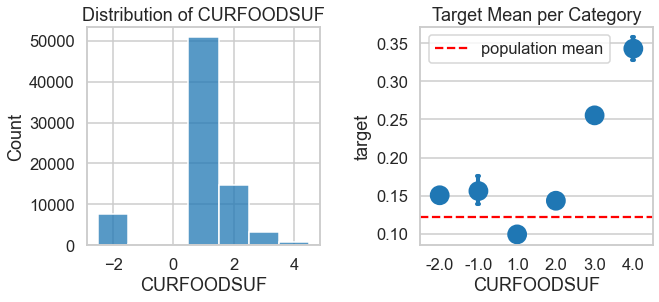

In [1523]:
dstools.explore_data_catbin(['CURFOODSUF'], df, 'target')

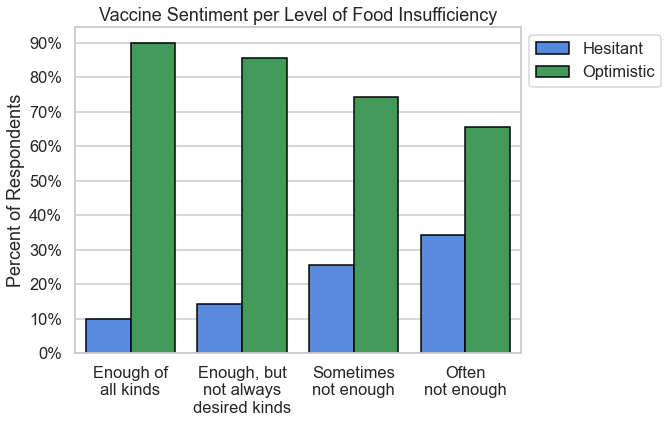

In [1524]:
# Plot sentiment for difficulty meeting expenses

# mapper for CURFOODSUF
food_map = {
    1.0:"Enough of\nall kinds",
    2.0:"Enough, but\nnot always\ndesired kinds",
    3.0:"Sometimes\nnot enough",
    4.0:"Often\nnot enough"
}

pred = 'CURFOODSUF'
pred_pretty = 'Level of Food Insufficiency'

filter_df = df.loc[df[pred] > 0]
to_plot = percent_cattarget_per_catpred(filter_df, pred)

# map placholder values to text
to_plot[pred].replace(food_map, inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=pred, y="percent", hue="target",\
                data=to_plot, palette=colors, ax=ax, edgecolor='black')


ax.set_title(f'Vaccine Sentiment per {pred_pretty}')
ax.set_xlabel(None)
ax.set_ylabel('Percent of Respondents')
ax.legend(title=None, bbox_to_anchor=(1, 1), loc='upper left')
#ax.tick_params(axis='x', labelrotation = 45)
ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

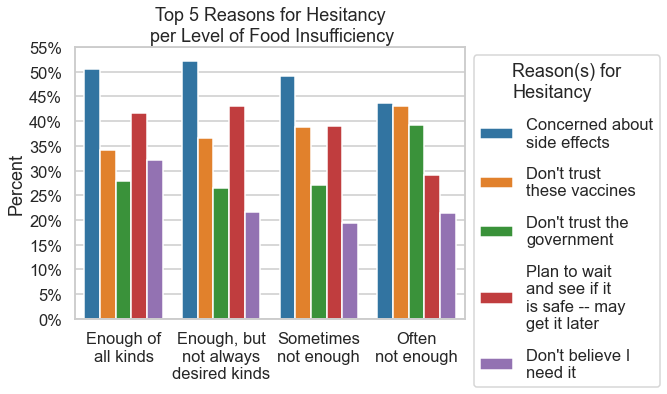

In [1525]:
# plot top 5 reasons respondents said why they didn't plan to get vaccinated
filt_df = hes_df.loc[hes_df[pred] > 0, [pred] + hes_reason_cols]

to_plot = top_n_whys_perpred(filt_df, pred, [4.0])
# map placholder values to text
to_plot[pred].replace(food_map, inplace=True)

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=pred, y="percent", hue="target",\
                data=to_plot, ax=ax, orient='v')

# nifty wrap labels code from:
#https://stackoverflow.com/questions/47057789/matplotlib-wrap-text-in-legend
handles, labels = ax.get_legend_handles_labels()
labels = ['\n'.join(wrap(l, 15)) for l in labels]

ax.set_title(f'Top 5 Reasons for Hesitancy\n per Level of Food Insufficiency')
ax.set_xlabel(None)
ax.set_ylabel('Percent')
ax.legend(handles=handles, labels=labels, title="Reason(s) for\nHesitancy", 
          labelspacing=1,
          bbox_to_anchor=(1, 1), loc='upper left')
ax.yaxis.set_ticks(np.arange(0, 0.6, 0.05))

#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("#%d"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));

## Optimism - Age

In [1526]:
hes_meanage = df.loc[df['target']==1, 'AGE'].mean()
hes_medianage = df.loc[df['target']==1, 'AGE'].median()
opt_meanage = df.loc[df['target']==0, 'AGE'].mean()
opt_medianage = df.loc[df['target']==0, 'AGE'].median()

print(f"Mean hesitant age: {hes_meanage}")
print(f"Median hesitant age: {hes_medianage}")
print(f"Mean optimistic age: {opt_meanage}")
print(f"Median optimistic age: {opt_medianage}")

Mean hesitant age: 47.279221462388215
Median hesitant age: 46.0
Mean optimistic age: 55.57539519906323
Median optimistic age: 57.0


In [1527]:
# are the sample distributions normal enough (or large enough) to perform a t-test?
stat, pval = stats.normaltest(df.loc[df['target']==1, 'AGE'])
print(f"Hesitant stat is {stat}")
print(f"Hesitant p-value is {pval}")

Hesitant stat is 267.84274050988984
Hesitant p-value is 6.8974393339571815e-59


In [1528]:
stat, pval = stats.normaltest(df.loc[df['target']==0, 'AGE'])
print(f"Optimistic stat is {stat}")
print(f"Optimistic p-value is {pval}")

Optimistic stat is 6938.611023197798
Optimistic p-value is 0.0


Both samples passed the normality test, so we can do a t-test to see if the differences in their means is statistically significant.

In [1529]:
# Is the difference in means statistically significant?
# will use welch's t-test since sample size is so different
t, pval = stats.ttest_ind(df.loc[df['target']==1, 'AGE'], 
                          df.loc[df['target']==0, 'AGE'])
print(f"t-statistic is {t}")
print(f"p-value is {pval}")

t-statistic is -48.377312249394244
p-value is 0.0


The p-value is very low and t-stat is very low, so the difference is statistically significant.

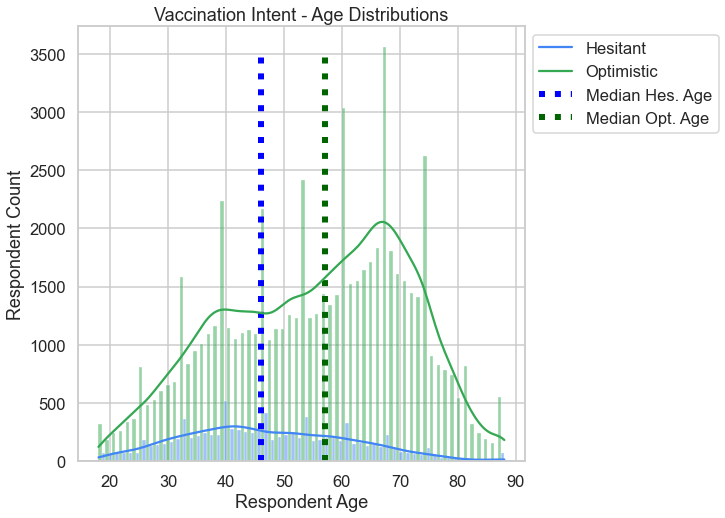

In [1530]:
# Plot age distributions by vaccine sentiment
hes_meanage = df.loc[df['target']==1, 'AGE'].mean()

colors = sns.color_palette(['#34a853', '#4285f4'])

fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(x='AGE', data=df, hue='target', ax=ax, palette=colors, 
             kde=True, multiple='dodge')

ax.set_title('Vaccination Intent - Age Distributions')
ax.set_ylabel('Respondent Count')
ax.set_xlabel('Respondent Age')


ax.vlines(hes_medianage, ymin=0, ymax=3500, 
          color='blue', linestyles='dotted', linewidth=6)
ax.vlines(opt_medianage, ymin=0, ymax=3500, 
          color='darkgreen', linestyles='dotted', linewidth=6)
ax.legend(labels=['Hesitant', 'Optimistic', 'Median Hes. Age', 
                  'Median Opt. Age'], bbox_to_anchor=(1, 1), loc='upper left');

# CONCLUSIONS & RECOMMENDATIONS

## Understanding the Hesitant Population

I see no clear pattern from the top predictors of hesitancy that might be used in targeted outreach programs. 

Although characteristics such as living in certain types of dwellings and having more children in the household indicate a higher likelihood of hesitancy, households with no children living with them and who live in houses and apartments are still hesitant at about the same percentage as the entire population. 

For characteristics that predicted a greater percentage of hesitant respondents, it was the rarest categories that had the highest percentage of hesitancy. It's possible that being in a group that could be considered in some sense on the fringe--in other words living under circumstances which are the least common among the population--is a sort of meta-predictor of hesitancy. 

Overall, my conclusion based on this analysis is that there is no one single characteristic that hesitant people have in common; their situations are varied. 

It's worth noting that the predictors I attempted to engineer to represent political leanings (household being in a "Red" versus "Blue" state, or being in a metropolitan area, which tend to be Blue) didn't make it into the top predictors of hesitancy or optimism. It's possible we would see different results if we had data on the specific household's political affiliations, but this data did not support the idea that vaccine hesitancy is largely a partisan issue.





## Reasons for Hesitancy

The top 5 reasons cited for hesitancy across the hesitant group were:

1. Concerned about side effects
2. Plan to wait and see if it's safe -- may get it later
3. Don't trust the vaccines
4. Don't trust the government
5. Don't believe I need it

Of people who said they didn't believe they needed the vaccine, top sub-reasons why were:
1. Not in a high risk group
2. Don't believe COVID is a serious illness

When we look at the top 5 reasons in the groups with the highest percentage of hesitancy, there is almost no difference compared to the groups with average percentage of hesitancy. The only group that differed was households who said it had been very difficult to meet household expenses, where the number 5 reason was "Don't believe it will work".

Approaches that address the top 5 hesitancy reasons should produce results across the board.

## Recommendations for Further Initiatives to Encourage Vaccination

### Address the concerns about side effects

Since concerns about side effects are a top reason cited for hesitancy, the government should try to ease these concerns.

Currently, the top result of Googling "COVID vaccine side effects" is [this CDC webpage](https://www.cdc.gov/coronavirus/2019-ncov/vaccines/expect/after.html). Although factually accurate, and I believe genuinely designed to educate the public on what to expect, seeing so many warnings can be scary. 

If we had more data on the likelihood of experiencing moderate to severe side effects, I think that would help put things in perspective. Moderate to severe side effects may be less common than people assume based on what they hear anecdotally, so statistics to understand their prevalence.

### Carry on with current campaigns offering perks and cash

The next most common reason was waiting to see if it was safe. This survey was conducted in early March, so by the time of this writing in late May, some people may already have been convinced. However, the existing campaigns offering money or perks such as food coupons may help sway the hesitant sooner, especially since they tended to be groups with lower income, greater difficulty meeting expenses, and greater food insufficiency.

Also, since only 61% of adults have been vaccinated at this point (compared to the 82% of people who said they were optimistic in the last survey from May 10) it's clear there are still people who actually do intend to get vaccinated, but just need the right motivation to get it done sooner. The existing campaigns may help convince people who are optimistic, but have held off for other reasons. 

# Potential Future Analysis

The Household Pulse Surveys are still ongoing, and there is already more recent microdata available than there was when this analysis was run. 

Continuing to evaluate the current machine learning models on new data may help validate the accuracy of these results.

It's also very possible that vaccine sentiment and reasons for hesitancy will shift over time as more people become vaccinated and it becomes more commonplace. Understanding how people's opinion changes over time may be useful for future public health endeavors, not only the current pandemic.

# Extra

In [1546]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/Users/jessicamiles/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Random Forest Feature Importances

In [ ]:
rf_im = pd.Series(rf.feature_importances_, index=final_keep)
rf_im.sort_values(ascending=False).head(20)

## Random Forest Permutation Importance

In [ ]:
rf_pi = permutation_importance(rf, X_test_df[final_keep], y_test, 
                               scoring='f1_macro', n_jobs=-1, n_repeats=15)
rf_pi.keys()

In [ ]:
rf_pi_s = pd.Series(rf_pi['importances_mean'], index=final_keep)

rf_pi_s.sort_values(ascending=False).head(30)

In [ ]:
# get index of importances array in order sorted by mean importance (ascending)
sorted_idx = rf_pi['importances_mean'].argsort()

# Get list of feature names sorted in importance order (ascending)
col_s = pd.Series(final_keep)
col_s[sorted_idx][-20:]

In [ ]:
# get lists of actual importance scores
rf_pi_sort = rf_pi['importances'][sorted_idx].transpose()
rf_pi_sort[:, -5:]

In [ ]:
# Plot top 20 (bottom 20 because sorted from lowest to highest)
# code from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(rf_pi_sort[:, -30:],vert=False, labels=col_s[sorted_idx][-30:])
ax.set_title("Permutation Importances (test set)");

## Voting on Features
Logistic regression coefficients were interpretable as both odds of hesitancy and odds of optimism.

Using those as a baseline, I compared to ranked features from the Random Forest feature importances and permutation importances.

Out of the 16 categories I identified from LR coefficients, 13 were corroborated by one or the other of the random forest models.

Hesitancy Predictors:

| Model Column Name | Description of Question | Odds of Hesitancy |
|:-|:-|:-|
| THHLD_NUMKID | Number of individuals under 18 in the household | 2.29 |
| CURFOODSUF | Level of household food insufficiency in the past 7 days | 1.8 |
| LIVQTR_1.0 | Household residence is a mobile home | 1.73 |
| FEWRTRANS_3.0 | Respondent did not use public transportation such as bus, rail, or ride-share before the pandemic, so transportation did not change | 1.51 |

Optimism Predictors:

| Model Column Name | Description of Question | Odds of Optimism |
|:-|:-|:-|
| AGE | Respondent's age in years | 6.06 |
| EEDUC | Level of education | 2.62 |
| RRACE_3.0 | Respondent identified as Asian | 2.22 |
| CHNGHOW6_1.0 | Members of the household had avoided eating at restaurants in the prior 7 days | 2.03 |
| INCOME | Pre-tax income level | 1.89 |
| FEWRTRIPS_1.0 | Members of the household had taken fewer trips to stores because of the pandemic in the prior 7 days | 1.88 |
| TW_START_1.0 | At least one adult in the household substituted some or all of their typical in-person work for telework | 1.51 |
| ANXIOUS_2.0 | Had felt anxious several out of the past 7 days | 1.38 |
| HLTHINS3_1.0 | Respondent covered by Medicare | 1.34 |

## Chi-Squared for categorical features

In [ ]:
import itertools

In [ ]:
# calculate chi-squared statistic for each categorical predictor 
# against the others

In [ ]:
def chi2_multicol(df, cols, prob=0.95):
    """Run chi-squared tests for all combinations of columns in cols list
    and returns a dataframe with column pair names, statistic, and p-value.
    
    This is intended for nominal categorical variables, so pass a list of
    just those columns in the dataframe.
    
    p-values can be filtered in resulting dataframe to determine which columns
    have NO relationship (null hypotheses) and which columns have SOME 
    relationship (alternative hypothesis).
    
    OHE the categorical columns first to get chi-2 test results on individual
    labels.
    """
    results = []
    
    cols.sort()

    cat_combos = list(itertools.combinations(cols, 2))

    for combo in cat_combos:

        # get the contingency table using crosstab
        crosstab = pd.crosstab(df[combo[0]], df[combo[1]])

        # use scipy to get chi2 statistic and other info
        stat, p, dof, expected = stats.chi2_contingency(crosstab)

        #https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
        # interpret test-statistic
        critical = stats.chi2.ppf(prob, dof)
        # append features that are NOT independent of each other to the list
        #if abs(stat) >= critical:
        results.append([combo[0] + '/' + combo[1], stat, p])

    results_df = pd.DataFrame(results, columns=['feature names', 
                                                'chi2 stat', 'p-value'])
    return results_df
        

In [ ]:
# These are the columns that only have one version
cat_cols = ['ANYWORK','CHNGHOW1','CHNGHOW10','CHNGHOW11','CHNGHOW12',
            'CHNGHOW2','CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6',
            'CHNGHOW7','CHNGHOW8','CHNGHOW9','DELAY','EGENDER','EIP',
            'EXPCTLOSS','FEWRTRANS','FEWRTRIPS','FREEFOOD','HADCOVID',
            'MH_NOTGET', 'MH_SVCS','NOTGET','PLNDTRIPS','PRESCRIPT','RHISPANIC',
            'RRACE','SNAP_YN','SPNDSRC1','SPNDSRC2','SPNDSRC3',
            'SPNDSRC4','SPNDSRC5','SPNDSRC6','SPNDSRC7','SPNDSRC8',
            'SSA_APPLY','SSA_RECV','TENURE','TW_START','UI_APPLY','WRKLOSS']

# I engineered versions of these columns, but these are the originals
# They have more rare labels, and provide more detail than the engineered 
# versions
cat_cols_v1 = ['HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 
               'HLTHINS6', 'HLTHINS7', 'HLTHINS8', 'ENROLL1', 'ENROLL2', 
               'ENROLL3', 'EST_MSA', 'LIVQTR', 'MS']

# These are the engineered versions of the columns that I can try if the
# original versions don't perform well
cat_cols_v2 = ['HLTHINS','inc_binary','IN_METRO_AREA', 'SCHOOL_KIDS', 
               'LIVQTR_2', 'MS_2', 'TNUM_PS_2']

all_cats = cat_cols + cat_cols_v1 + cat_cols_v2

dep_cats_df = chi2_multicol(df, all_cats)
dep_cats_df

In [ ]:
# which categorical variables are INdependent based on chi2 stats?
dep_cats_df.loc[dep_cats_df['p-value'] > 0.05]

This means almost all of my categorical variables have a dependent relationship between at least one of their respective labels, but I would need to OHE them and do do this again to determine which labels.

In [ ]:
# which individual categorical labels are correlated with each other?
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit(df[all_cats])
df_ohecats = pd.DataFrame(ohe2.transform(df[all_cats]), 
                          columns=ohe2.get_feature_names(df[all_cats].columns))
df_ohecats

In [ ]:
# run chi-2 tests on each combo of OHE dummy columns
ohe_dep_cats_df = chi2_multicol(df_ohecats, list(df_ohecats.columns))
ohe_dep_cats_df

In [ ]:
# which categorical labels are INdependent based on chi2 stats?
ohe_dep_cats_df.loc[ohe_dep_cats_df['p-value'] > 0.05]